# 분류기법을 활용한 정기 예금 고객 예측

## Import Library

In [1]:
# 데이터 조작
import numpy as np
import pandas as pd

# 변수 검정
from scipy import stats

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 숨김
import warnings
warnings.filterwarnings('ignore')

# 한글폰트 사용
plt.rc('font', family = 'Malgun Gothic')
plt.rc('axes', unicode_minus = False)

# 레티나 설정
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Import Data
* [Kaaggle Bank Customers Survey](https://www.kaggle.com/sharanmk/bank-marketing-term-deposit)

In [2]:
df = pd.read_csv('data/bank_customer_survey.csv')
print(df.shape)
df.head()

(45211, 17)


age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47          blue  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome  y  
0  unknown    5   may       261         1     -1         0  unknown  0  
1  unknown    5   may       151         1     -1         0  unknown  0  
2  unknown    5   may        76         1     -1         0  unknown  0  
3  unknown    5   may        92         1     -1         0  unknown  0  
4  unknown    5   may       198         1     -1         0  unknown  0

## Meaning of Columns
[UCI Machine Learning Repository - Bank Marketing Data Set](https://archive.ics.uci.edu/ml/datasets/bank+marketing#)

<고객 개인 정보>
* age : 나이 (연속형, int)
* job : 직업 (범주형, obj)
    - 노동자('blue'), 관리직('management'), 기술직('technician'), 관리직('admin'), 
    - 서비스직('services'), 은퇴('retired'), 자영업자('self'), 사업가('entrepreneur'), 
    - 무직('unemployed'), 주부('housemaid'), 학생('student'), 알 수 없음('unknown')
    
    
* marital : 결혼 여부 (범주형, obj)
    - 이혼/사별('divorced'), 기혼('married'), 미혼('single')
    
    
* education : 교육 수준 (범주형, obj)
    - 초등교육('primary'), 중등교육('secondary'), 고등교육(tertiary'), 알 수 있음('unknown')
    
<은행 관련 정보>
* balance : 잔고 (연속형, int)
* default : 채무 불이행 유무 (범주형, obj)
    - 'no', yes'
* loan : 개인 대출 유무 (범주형, obj)
    - 'no', 'yes'
* housing : 주택 담보 대출 유무 (범주형, obj)
    - 'no', 'yes'
    
<텔레마케팅 관련 정보>
* contact : 연락 방법 (범주형, obj)
    - 핸드폰('cellular'), 집전화('telephone'), 알 수 없음('unknown')
* duration : 총 통화 시간(초) (연속형, int)  
* campaign : 이번 캠페인에 고객에게 연락한 수 (연속형, int)
    - 마지막 연락까지 횟수에 포함
* day : 마지막으로 연락된 일 (연속형, int)
* month : 마지막으로 연락된 월 (범주형, obj)
    - 1월('jan') ~ 12월('dec'), 
    - 2018년 5월 ~ 2010년 11월에 수집  
* pdays : 고객이 이전 캠페인에 대해 연락을 받은 후 경과일 (연속형, int)
    - '-1' : 이전 캠페인에 대해 연락을 받지 않음

<이전과 이번 마케팅 결과>
* previous : 캠페인 이전 연락 수 (연속형, int)
* poutcome : 이전 캠페인의 결과 (범주형, obj)
    - 'failure', 'other', 'success', 'unknown'
* y : 정기 예금 설계 여부
    - 0 : 'no', 1 : 'yes'

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 5.9+ MB


## EDA

### 결측치 확인

In [4]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [5]:
# 'unknown' 도 결측치
print('job:', (df['job'] == 'unknown').sum())
print('education:', (df['education'] == 'unknown').sum())
print('contact:', (df['contact'] == 'unknown').sum())
print('poutcome:', (df['poutcome'] == 'unknown').sum())

job: 288
education: 1857
contact: 13020
poutcome: 36959


85% 가 결측치이므로 poutcome 컬럼을 제거해야 합니다.

결측치(%): 85.81761075844373


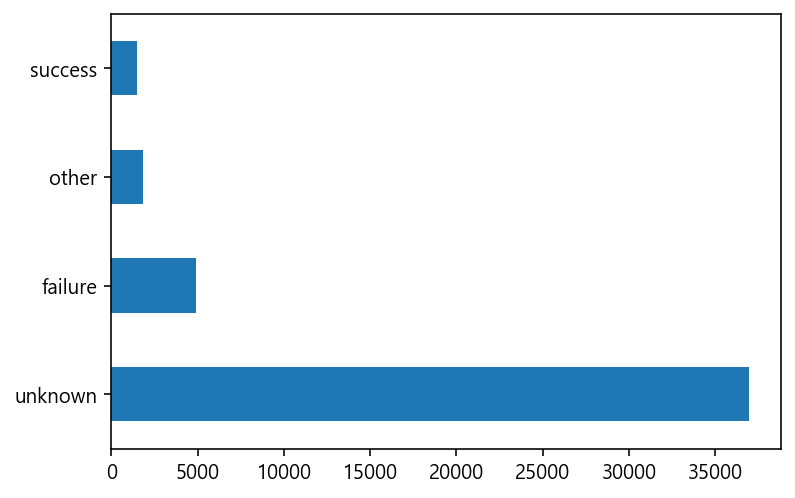

In [6]:
total = df['poutcome'].shape[0]
null = df.loc[(df['poutcome'] == 'unknown')|(df['poutcome'] == 'other'), 'poutcome'].shape[0]
print('결측치(%):', null / total * 100)

df['poutcome'].value_counts().plot.barh()

### 중복값 확인

In [7]:
print(df.shape)
df = df[~df.duplicated()]
df.shape

(45211, 17)


(45211, 17)

In [8]:
df.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

### 시각화

#### 타겟 변수

캠페인 결과로 정기 예금을 들지 않은 고객('No')이 88%로 데이터 불균형 문제가 있습니다.

0    0.883015
1    0.116985
Name: y, dtype: float64


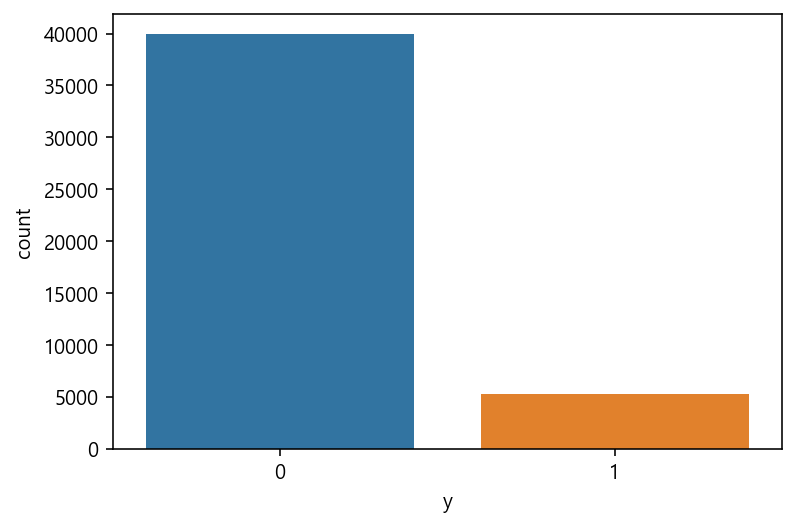

In [9]:
print(df['y'].value_counts(normalize=True))
sns.countplot(data=df, x='y')

#### 연속형 변수

age 와 day 외 다른 연속형 변수는 모두 이상치가 확인됩니다.

In [10]:
num_cols = df.dtypes[df.dtypes != 'object'].index.tolist()[:-1]
print(num_cols)
df.describe()

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous             y  
count  45211.000000  45211.000000  45211.000000  
mean      40.197828      0.580323      0.116985  
std      100.128746      2.303441      0.321406  
min       -1.000000      0.000000      0.000000  
25%       -1.000000      0.000000      0.000000  
50%       -1.000000      0.000000      0.000000  
75%       -1.000000      0.000000      0.000000  
max      871.000000    275.000000      1.000000

age 외 대부분의 컬럼이 정규분포를 따르지 않아 차후 스케일링이 필요합니다.

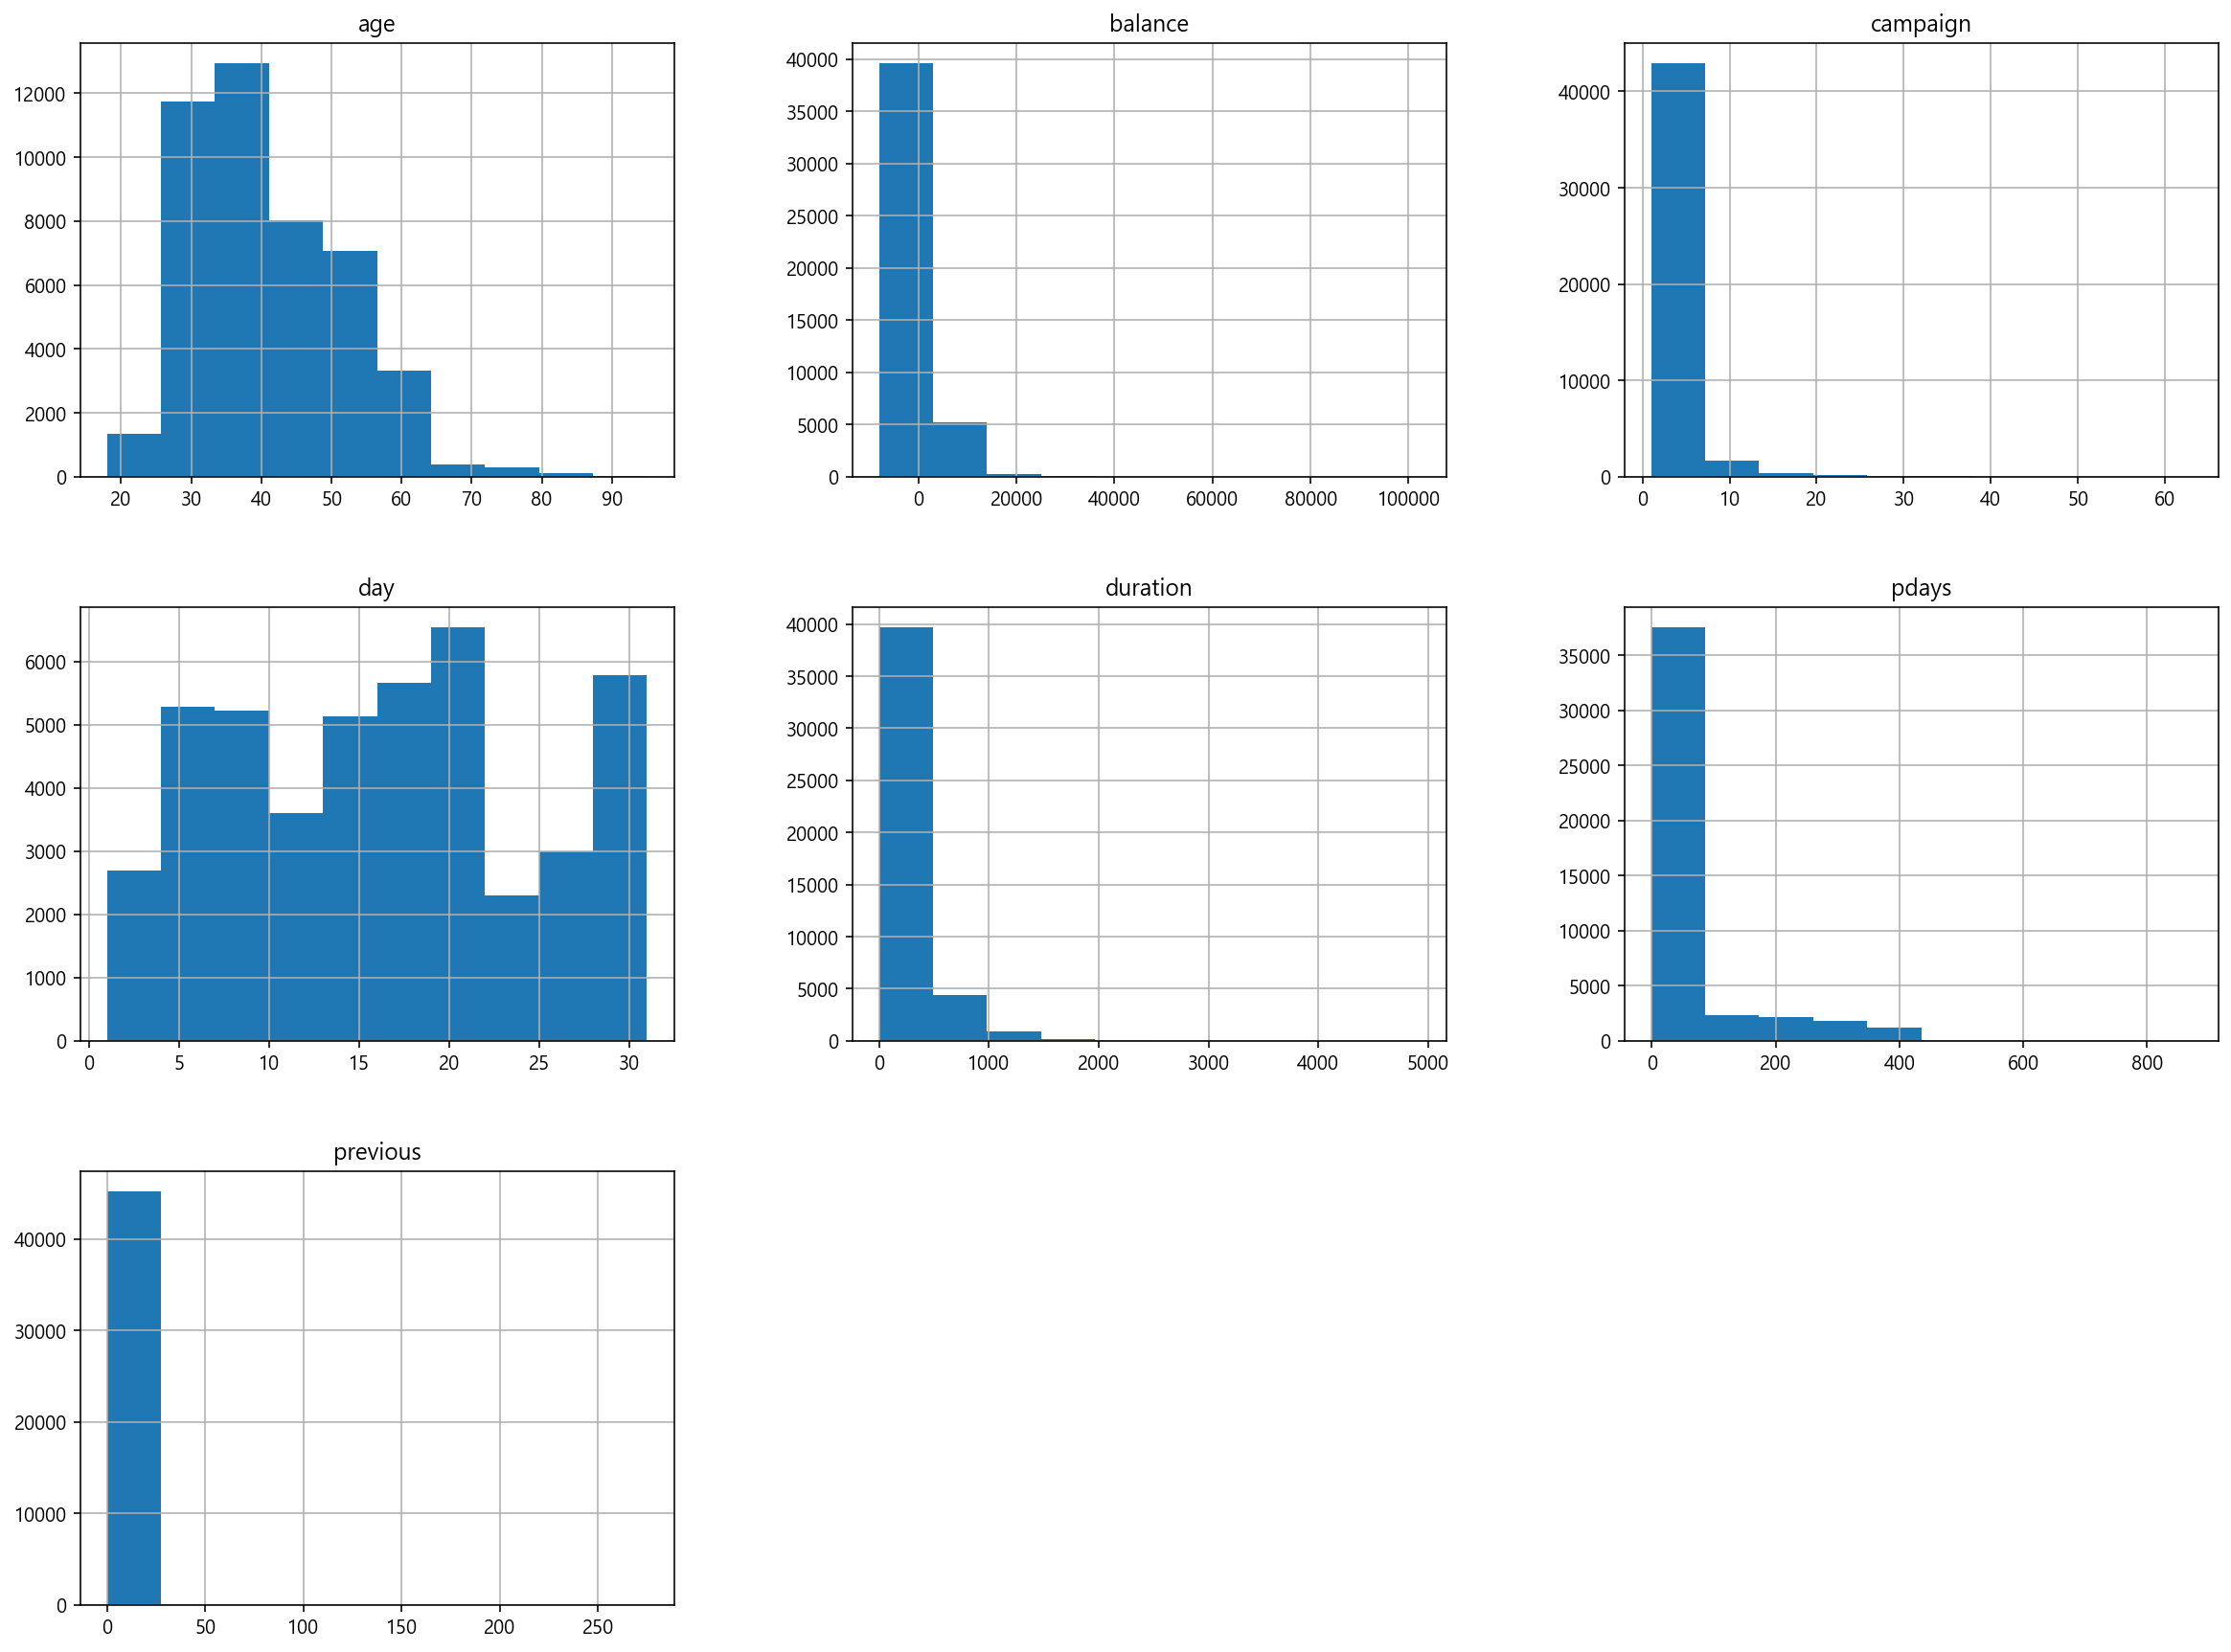

In [11]:
h = df[num_cols].hist(figsize=(20, 15))

duration 만 목표변수에 따라 큰 차이를 보이는 것 같아 보입니다.

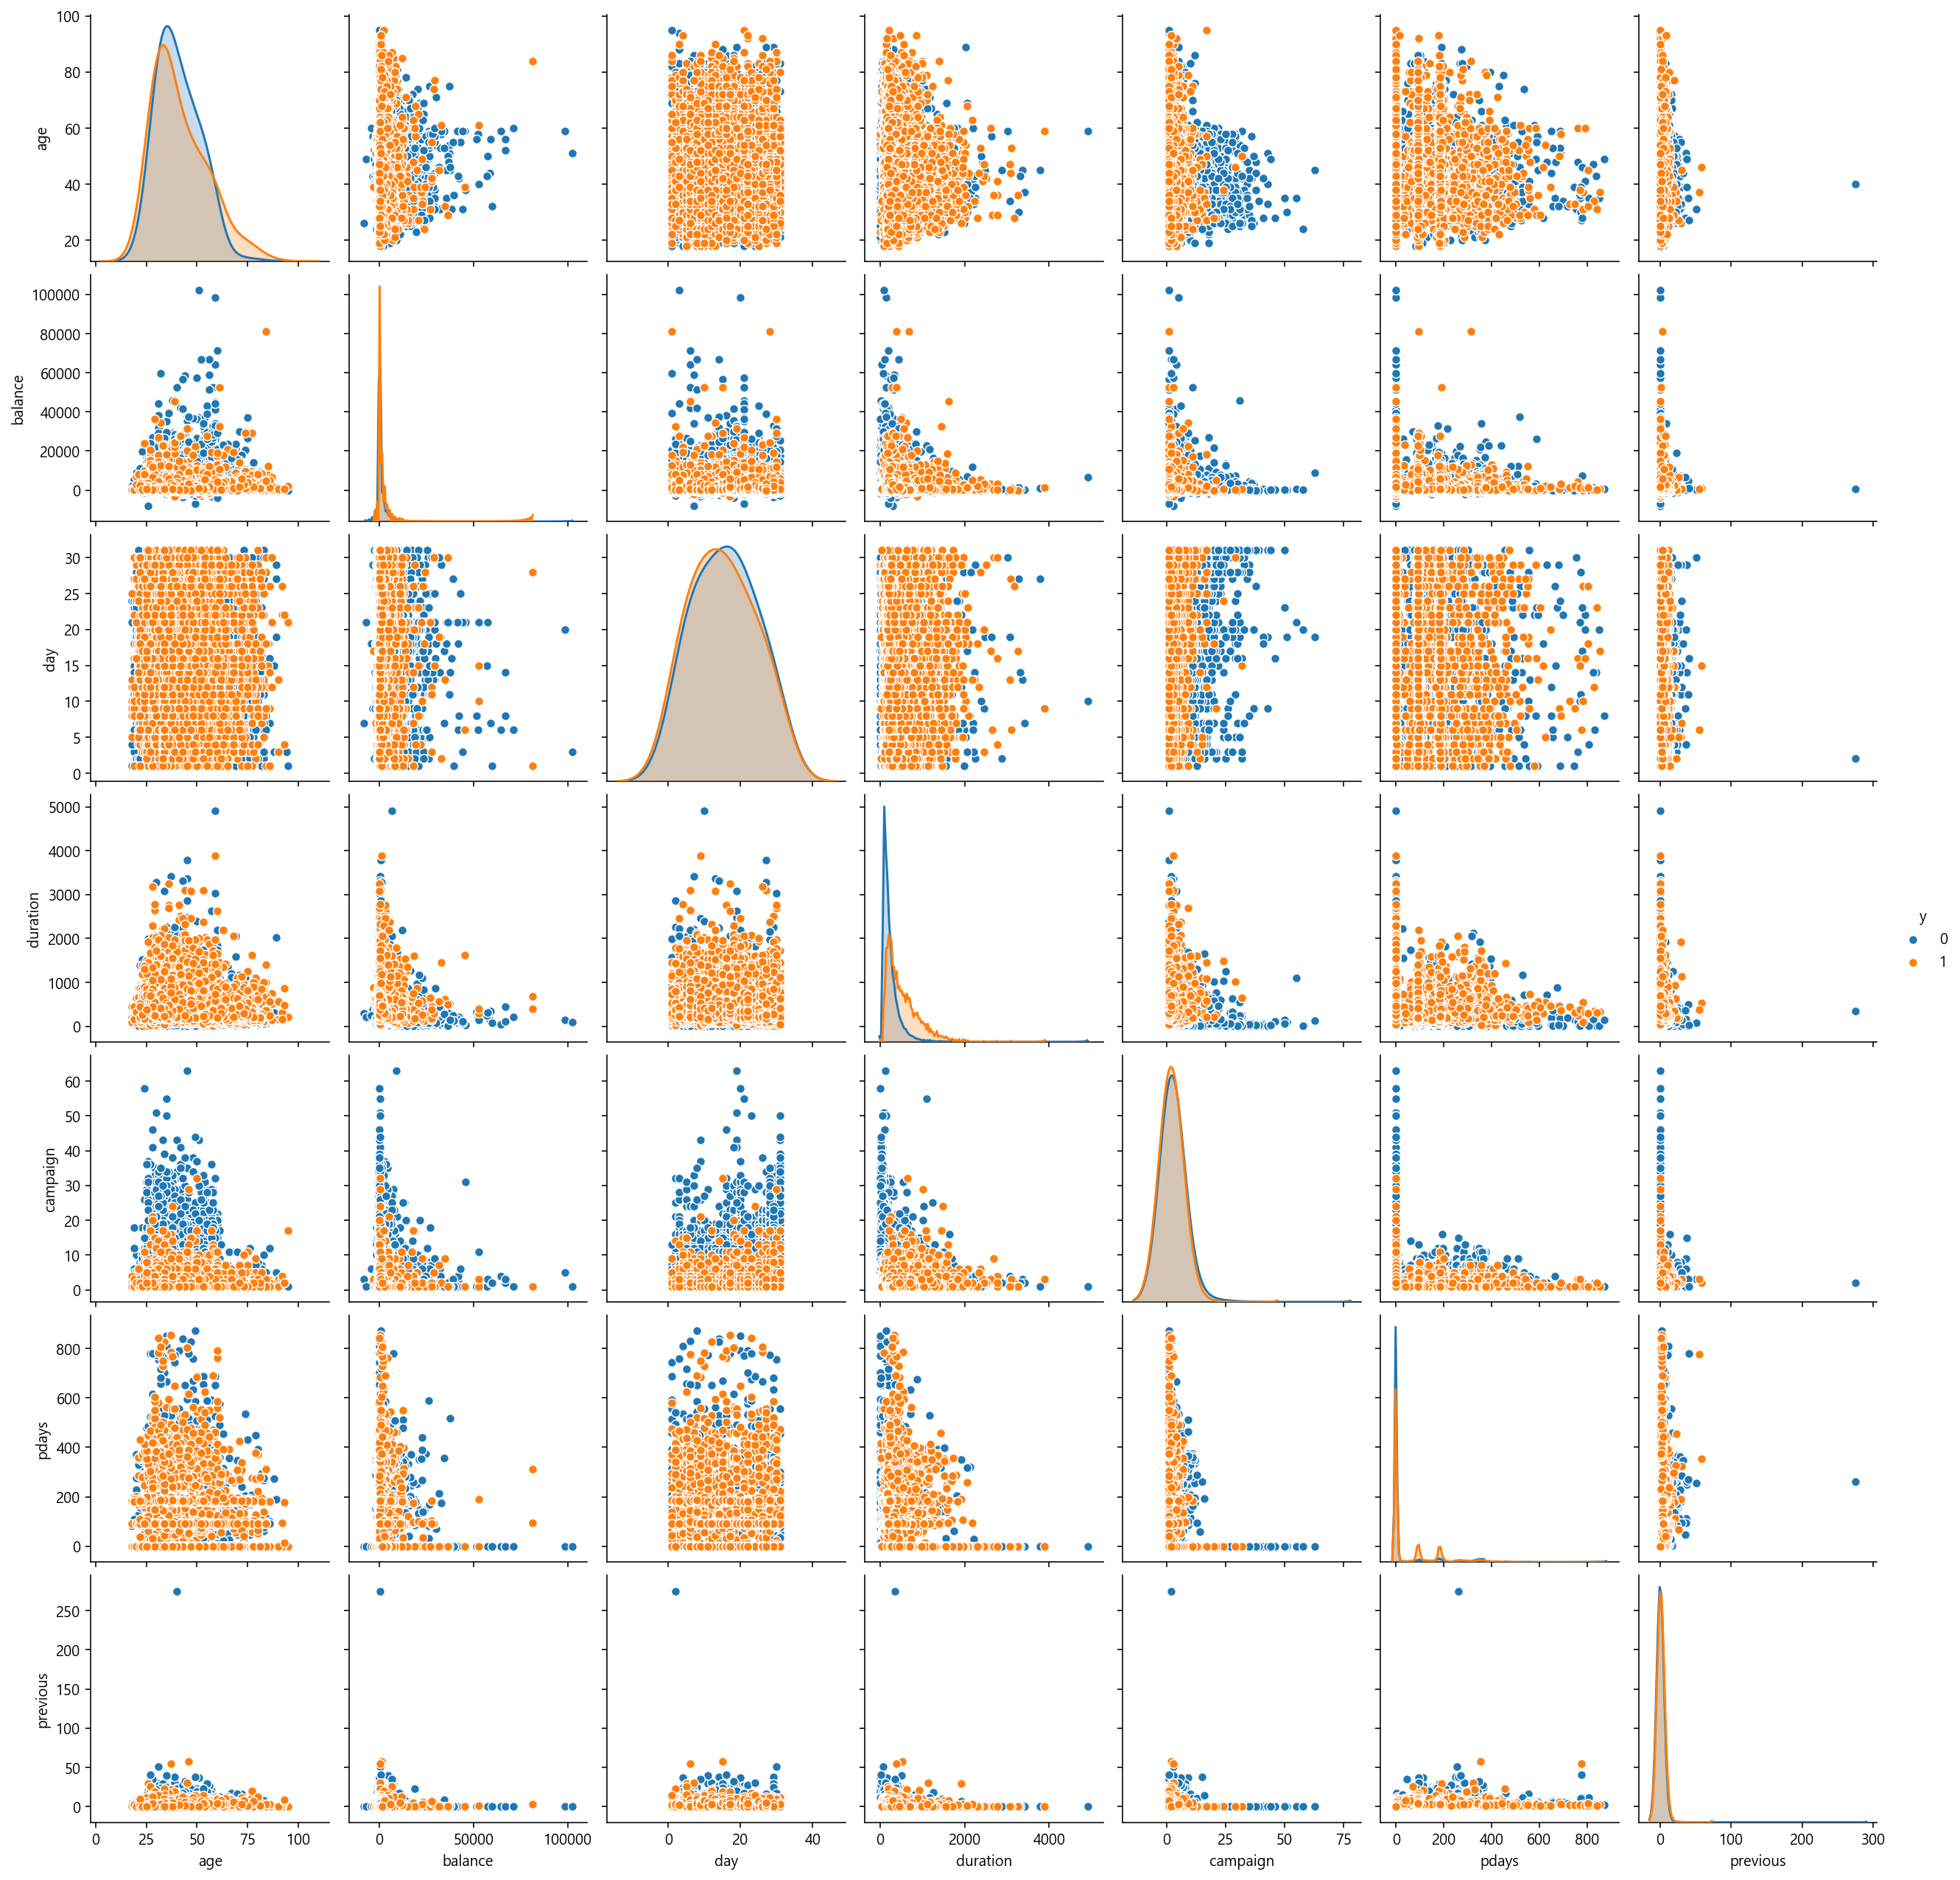

In [12]:
num_cols.append('y')
sns.pairplot(df[num_cols], hue='y', diag_kws={'bw':5})

In [13]:
numeric_features = [
    'age',
    'balance',
    'duration',
    'campaign',
    'pdays',
    'previous'
]
len(numeric_features)

6

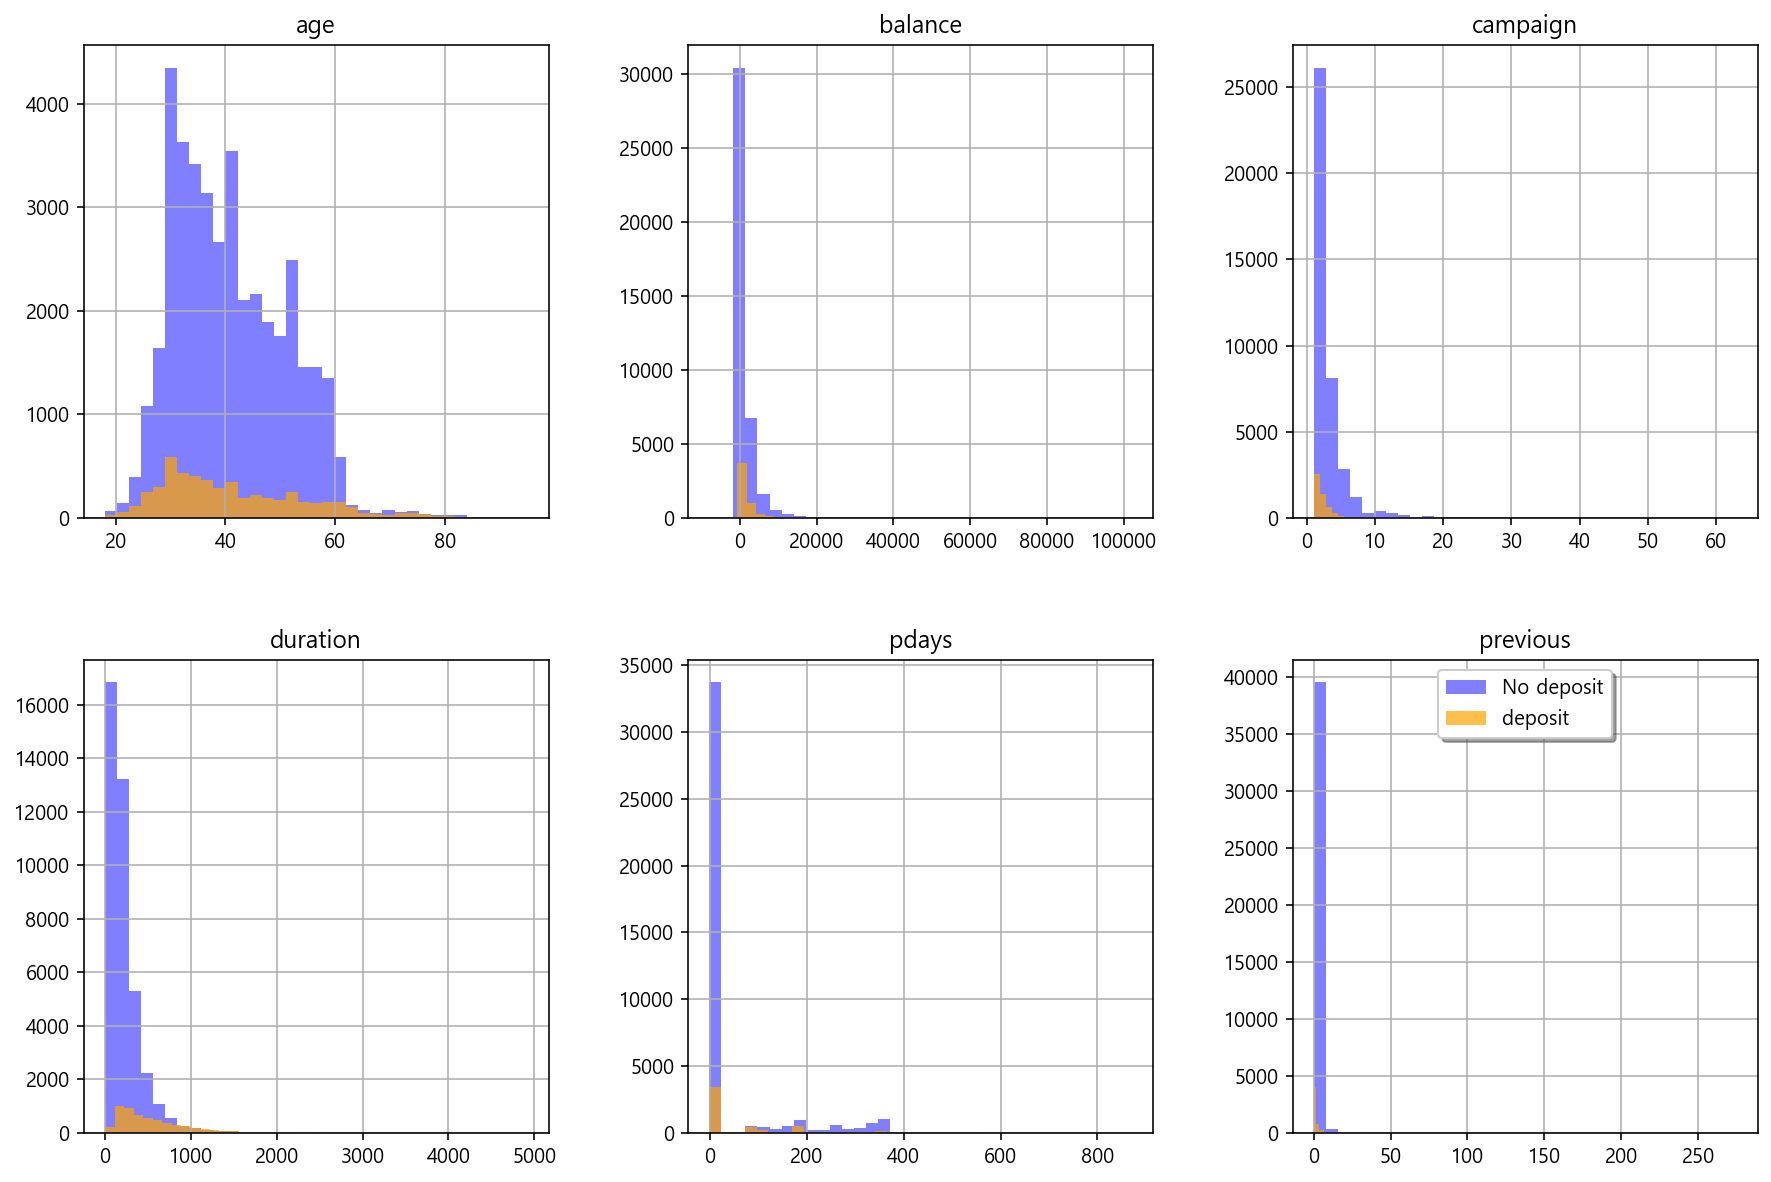

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
df[df.y == 0][numeric_features].hist(bins=35, color="blue", alpha=0.5, ax=axes)
df[df.y == 1][numeric_features].hist(bins=35, color="orange", alpha=0.7, ax=axes)
plt.legend(['No deposit', 'deposit'], shadow=True, loc=9)

변수간 상관계수가 높은 변수는 pdays 와 previous 입니다.  

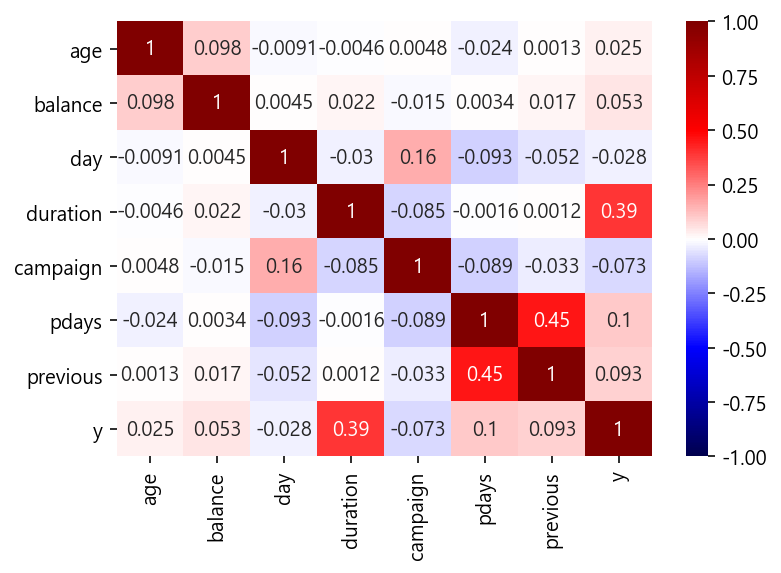

In [15]:
corr = df[num_cols].corr()
sns.heatmap(data=corr, annot=True, cmap='seismic', vmax=1, vmin=-1)

#### 범주형 변수

In [16]:
cat_cols = df.dtypes[df.dtypes == 'object'].index.tolist()
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

정기 예금을 신청한 고객 중에서는

* 결혼유무에선 기혼자가 비교적 많습니다.
* 교육수준에선 대졸자 이상이 비교적 많습니다.
* 채무 불이행 경험이 없는 사람이 있는 사람보다 많습니다.
* 주택 담보 대출을 받지 않은 사람이 받은 사람보다 많습니다.
* 개인 대출을 안 받은 사람이 받은 사람보다 많습니다.
* 개인 핸드폰으로 연락을 받은 사람이 더 많습니다.

반면에 정기 예금을 신청하지 않은 고객 중에서는

* 주택 담보 대출을 받은 사람이 받지 않은 사람보다 더 많습니다.

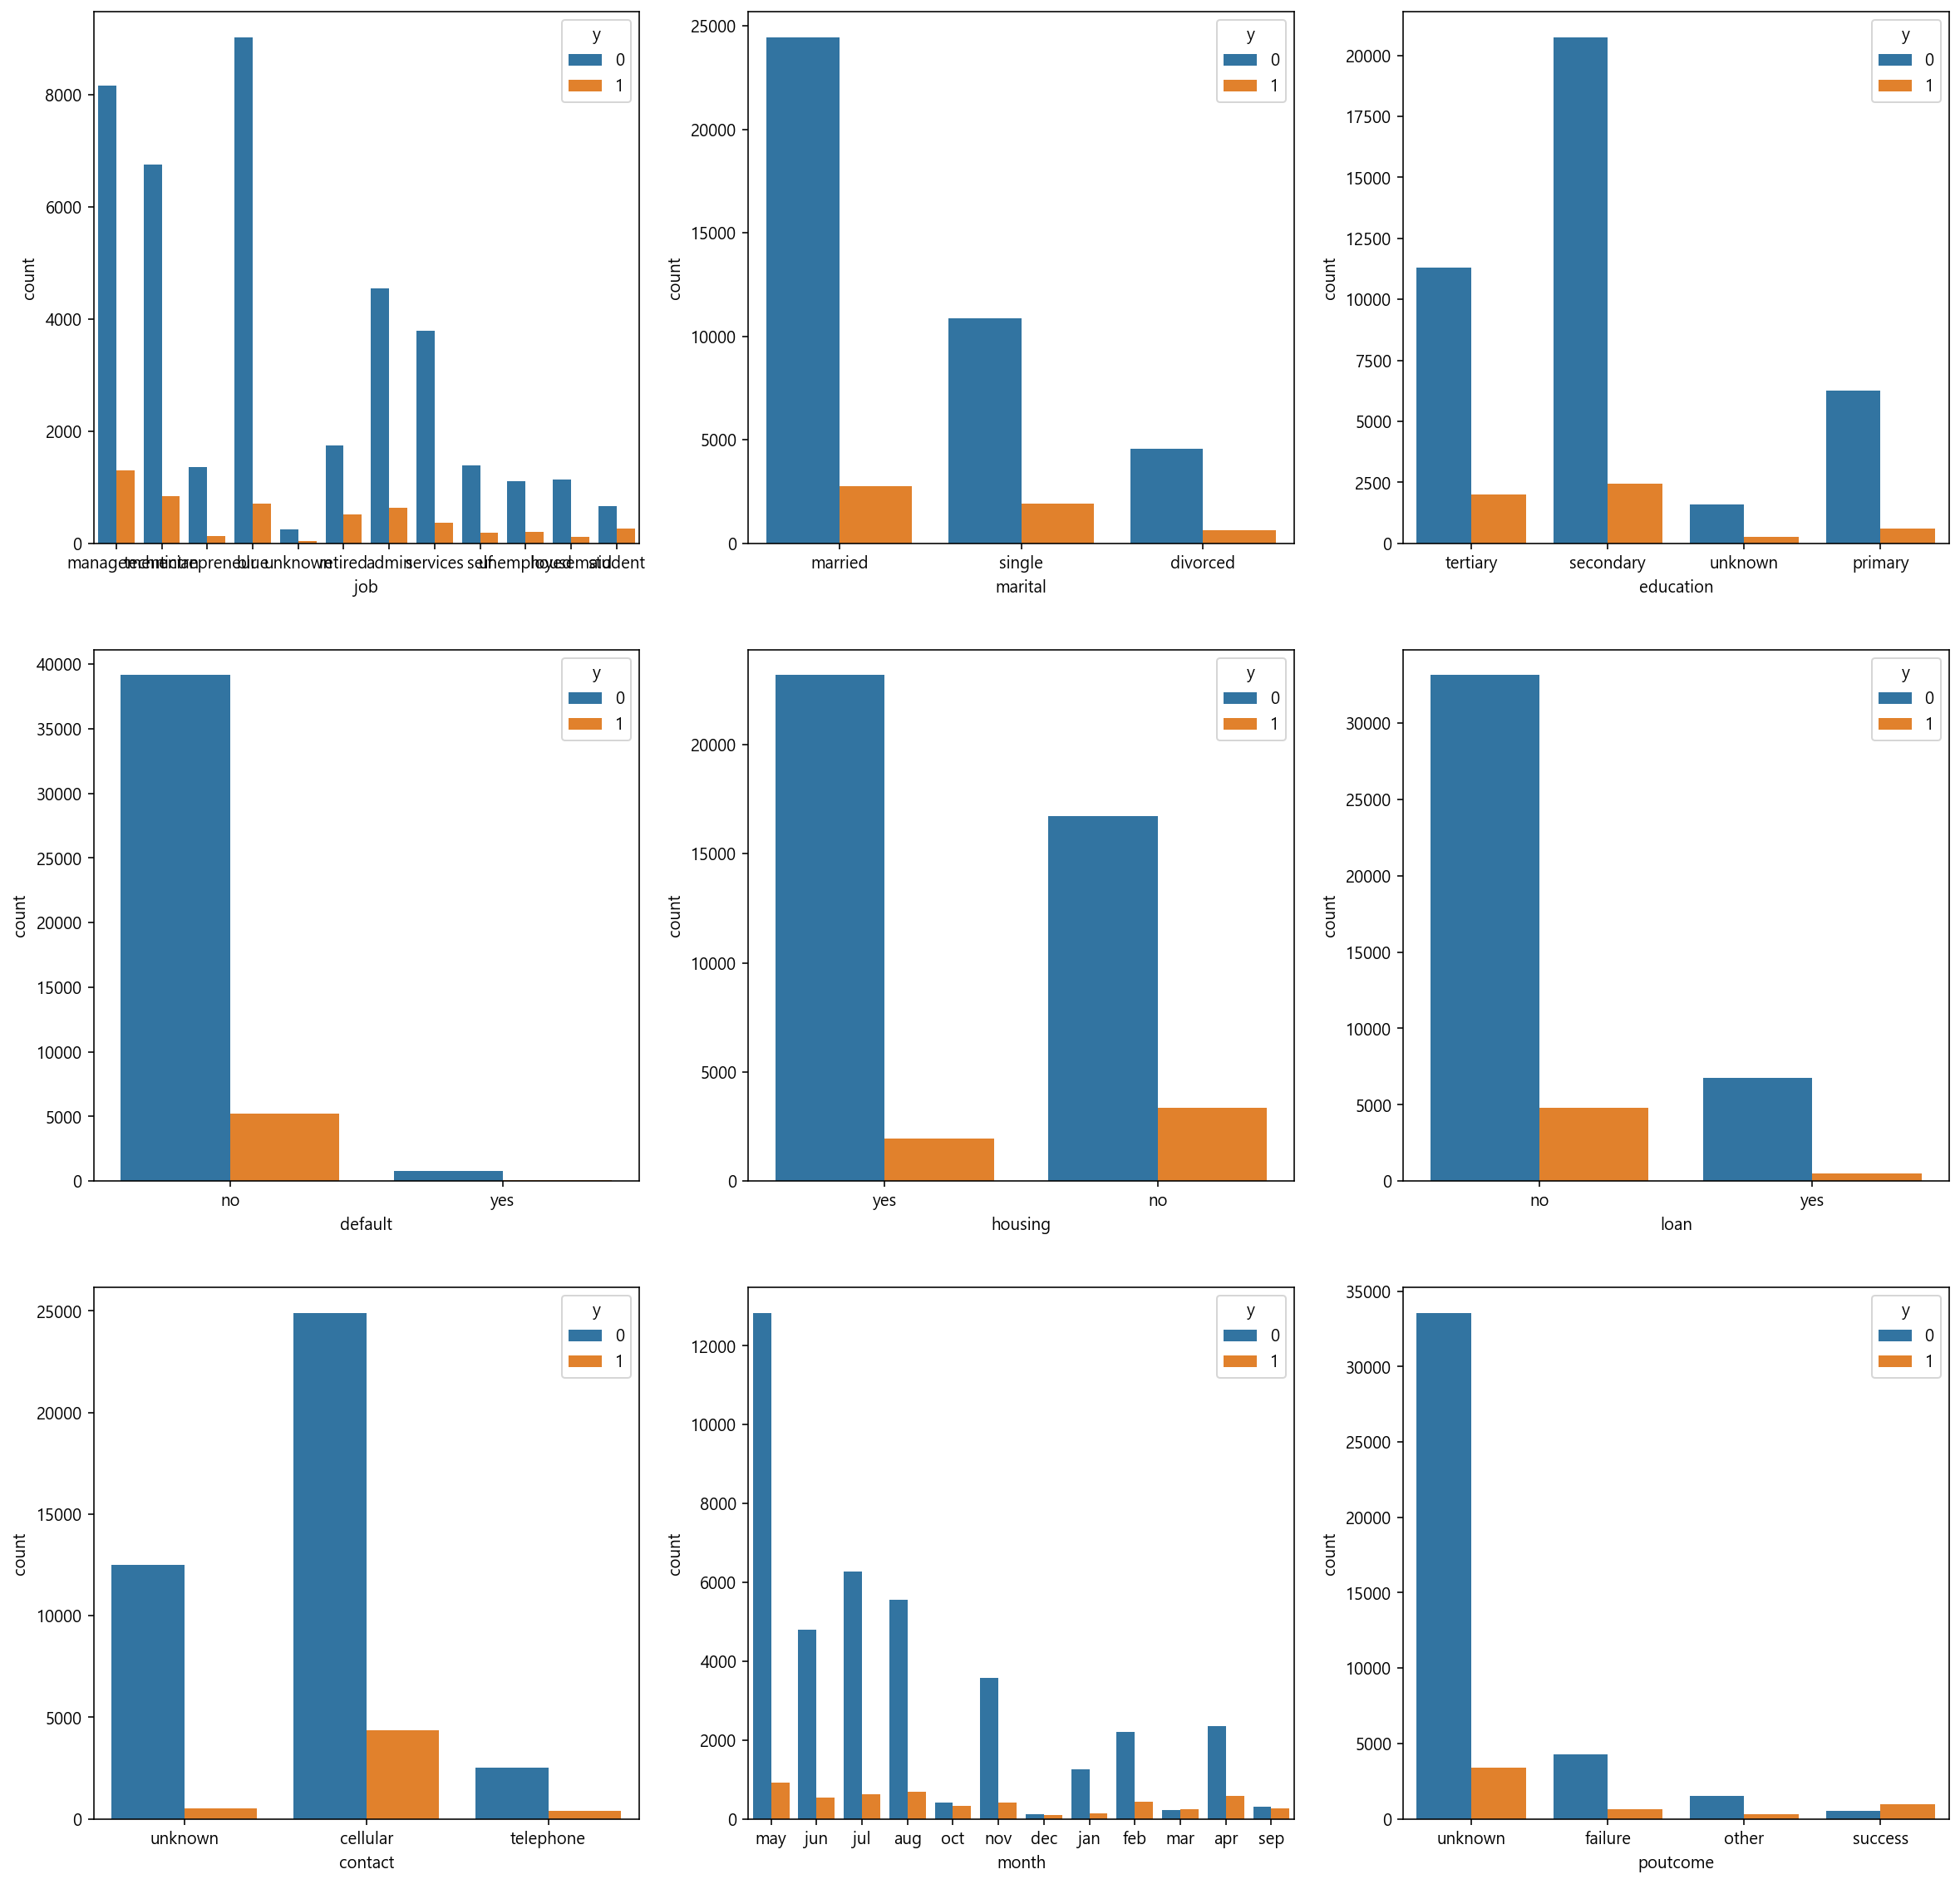

In [17]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))

for i, col_name in enumerate(cat_cols):
    row = i // 3
    col = i % 3
    sns.countplot(data=df, x=col_name, hue='y', ax=axes[row, col])

직업만 따로 보았습니다.

management      1301
technician       840
blue             708
admin            631
retired          516
services         369
student          269
unemployed       202
self             187
entrepreneur     123
housemaid        109
unknown           34
Name: job, dtype: int64


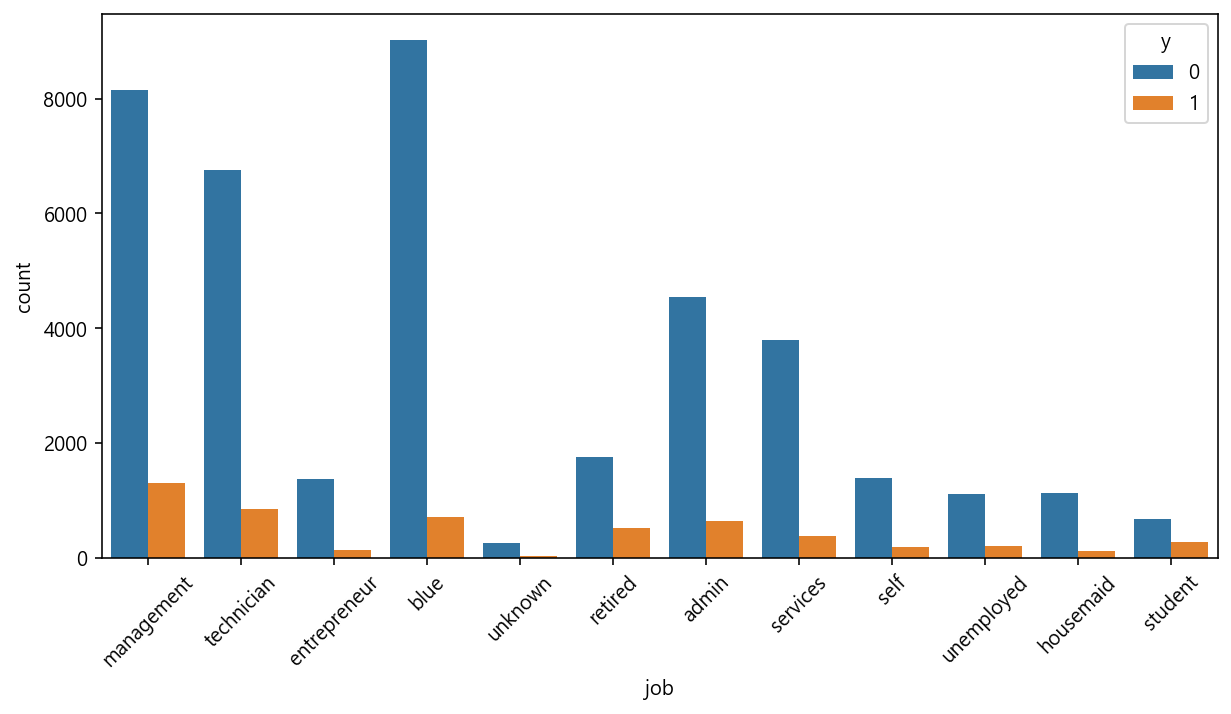

In [18]:
print(df[df.y==1]['job'].value_counts().sort_values(ascending=False))

plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
sns.countplot(data=df, x='job', hue='y')

각각의 컬럼별 계좌 잔고에 따른 정기 예금 신청 결과의 분포를 보았습니다. 

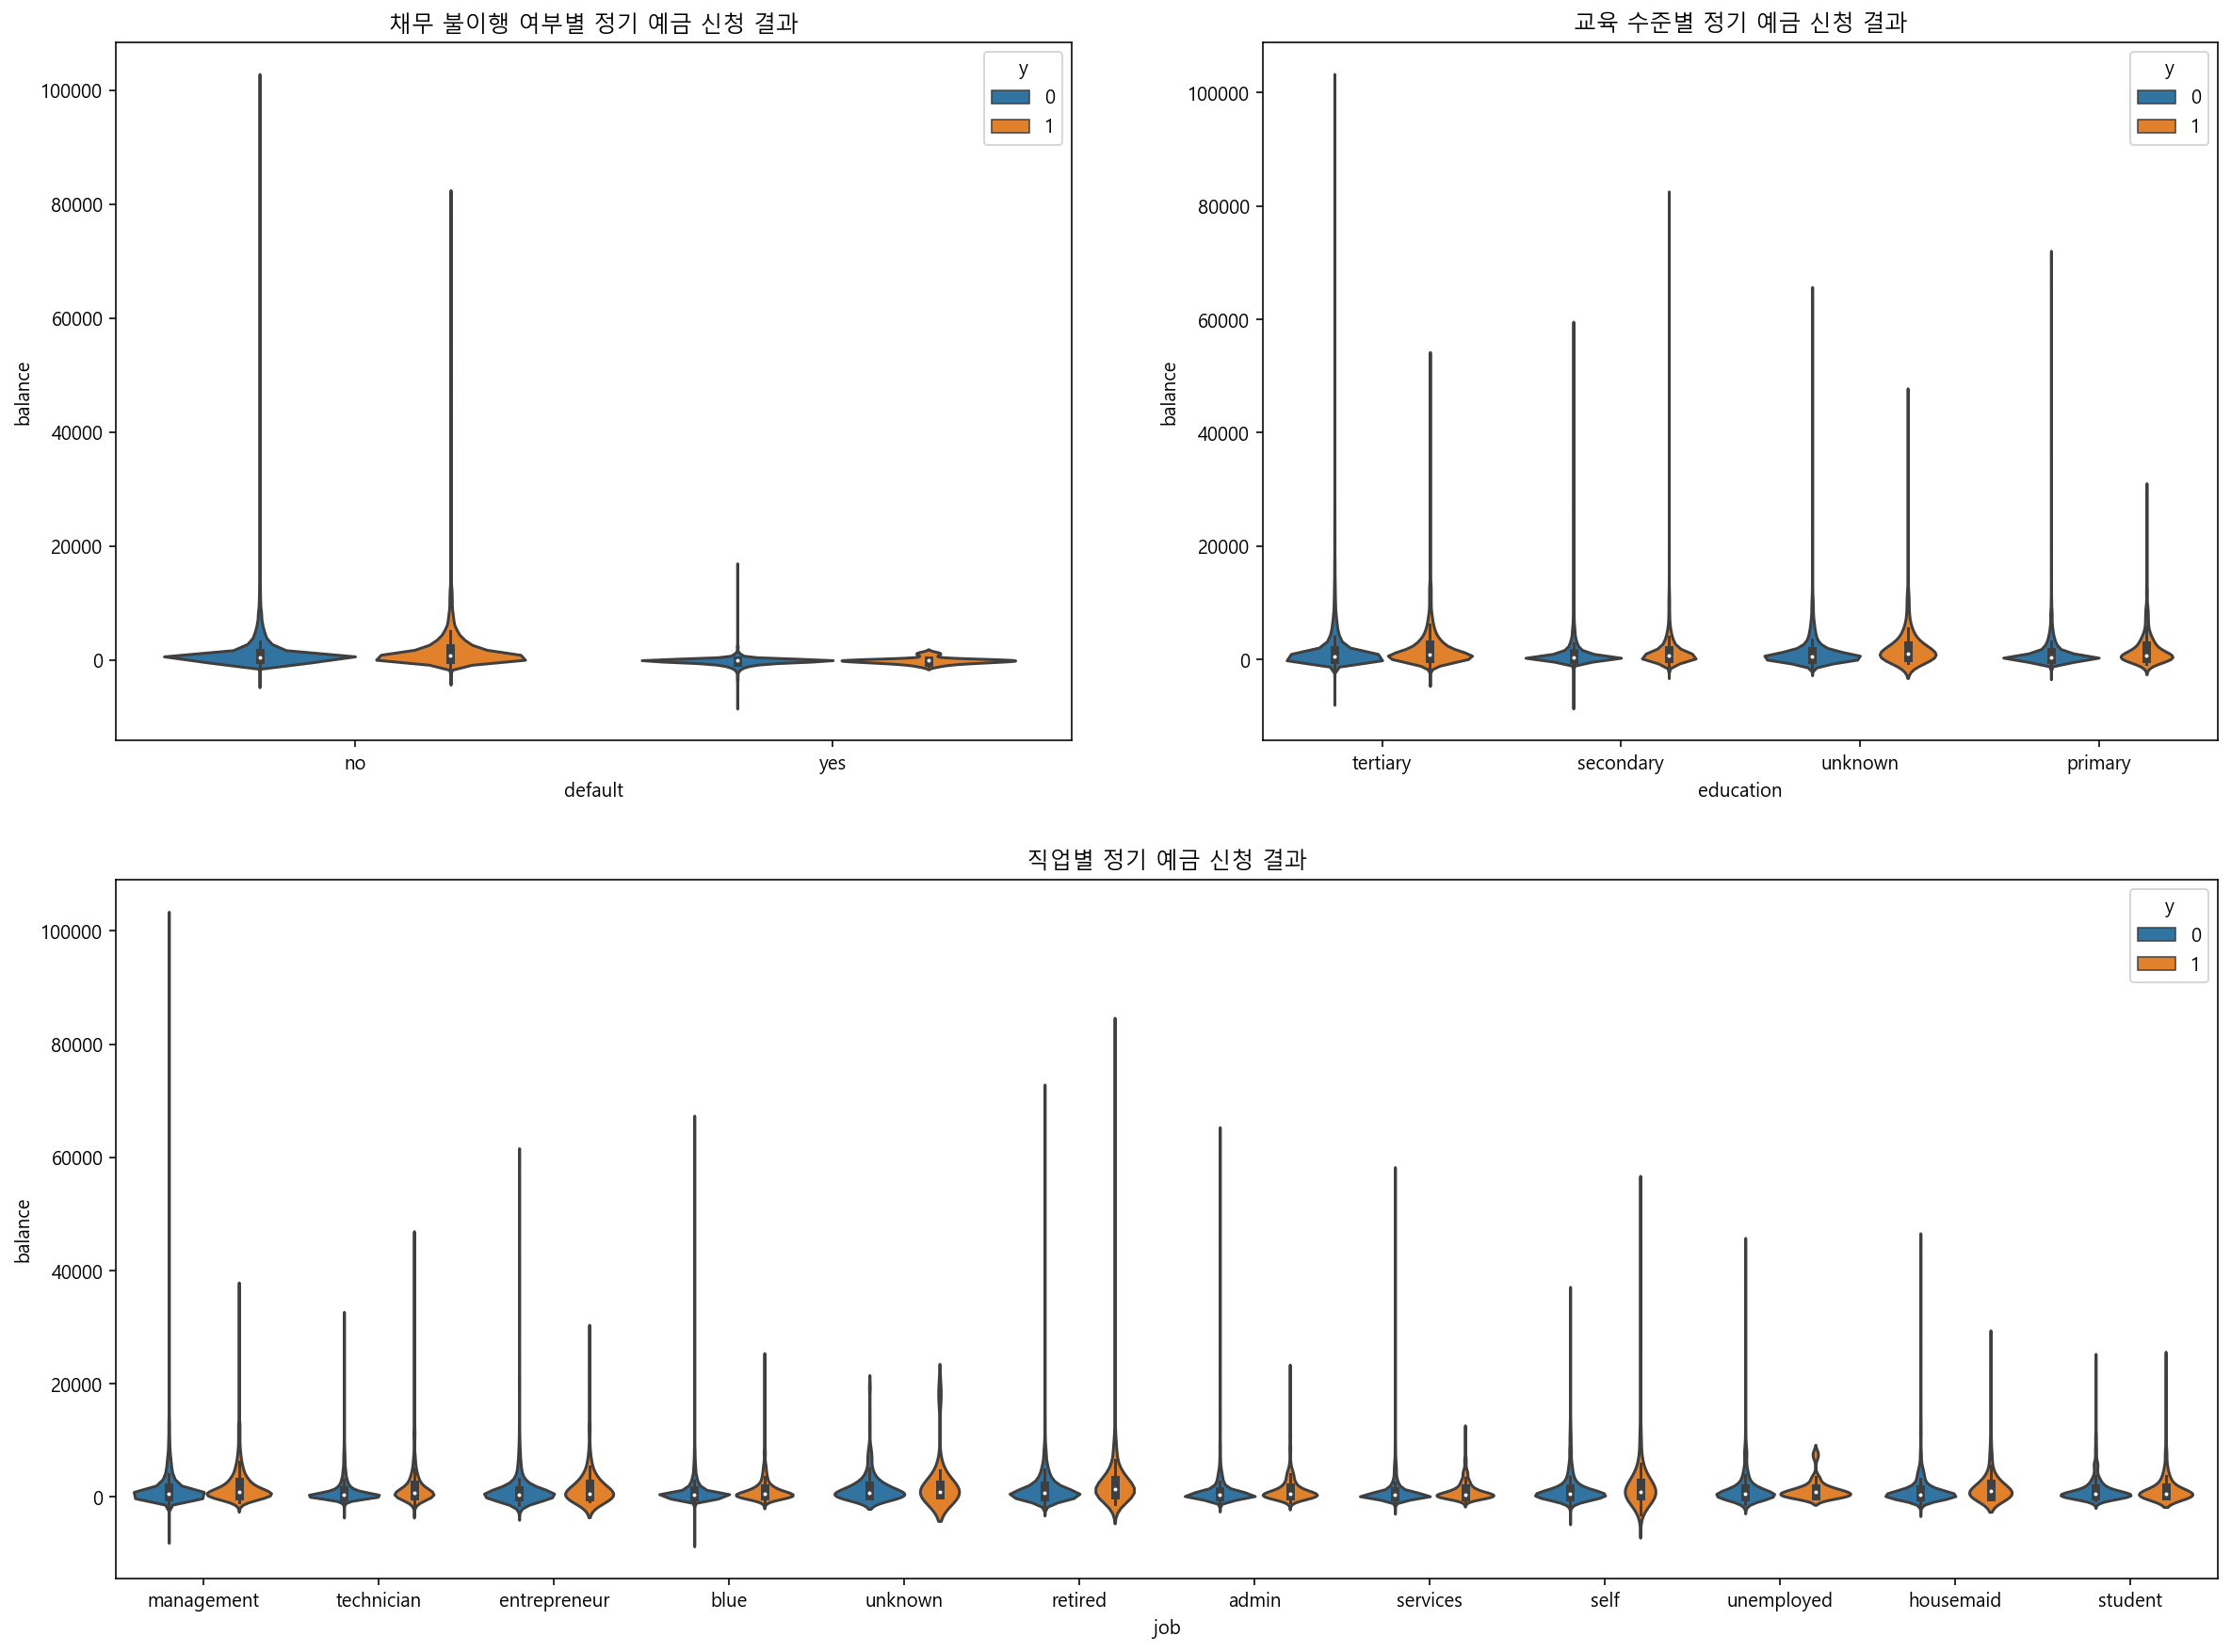

In [19]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

g = sns.violinplot(data=df, x='default', y='balance', hue='y', ax=ax1)
g.set_title('채무 불이행 여부별 정기 예금 신청 결과')

g1 = sns.violinplot(data=df, x='education', y='balance', hue='y', ax=ax2)
g1.set_title('교육 수준별 정기 예금 신청 결과')

g2 = sns.violinplot(data=df, x='job', y='balance', hue='y', ax=ax3)
# g2.set_xticklabels(df['job'].unique(), rotation = 90, rotation_mode = 'anchor')
g2.set_title('직업별 정기 예금 신청 결과')
plt.show()

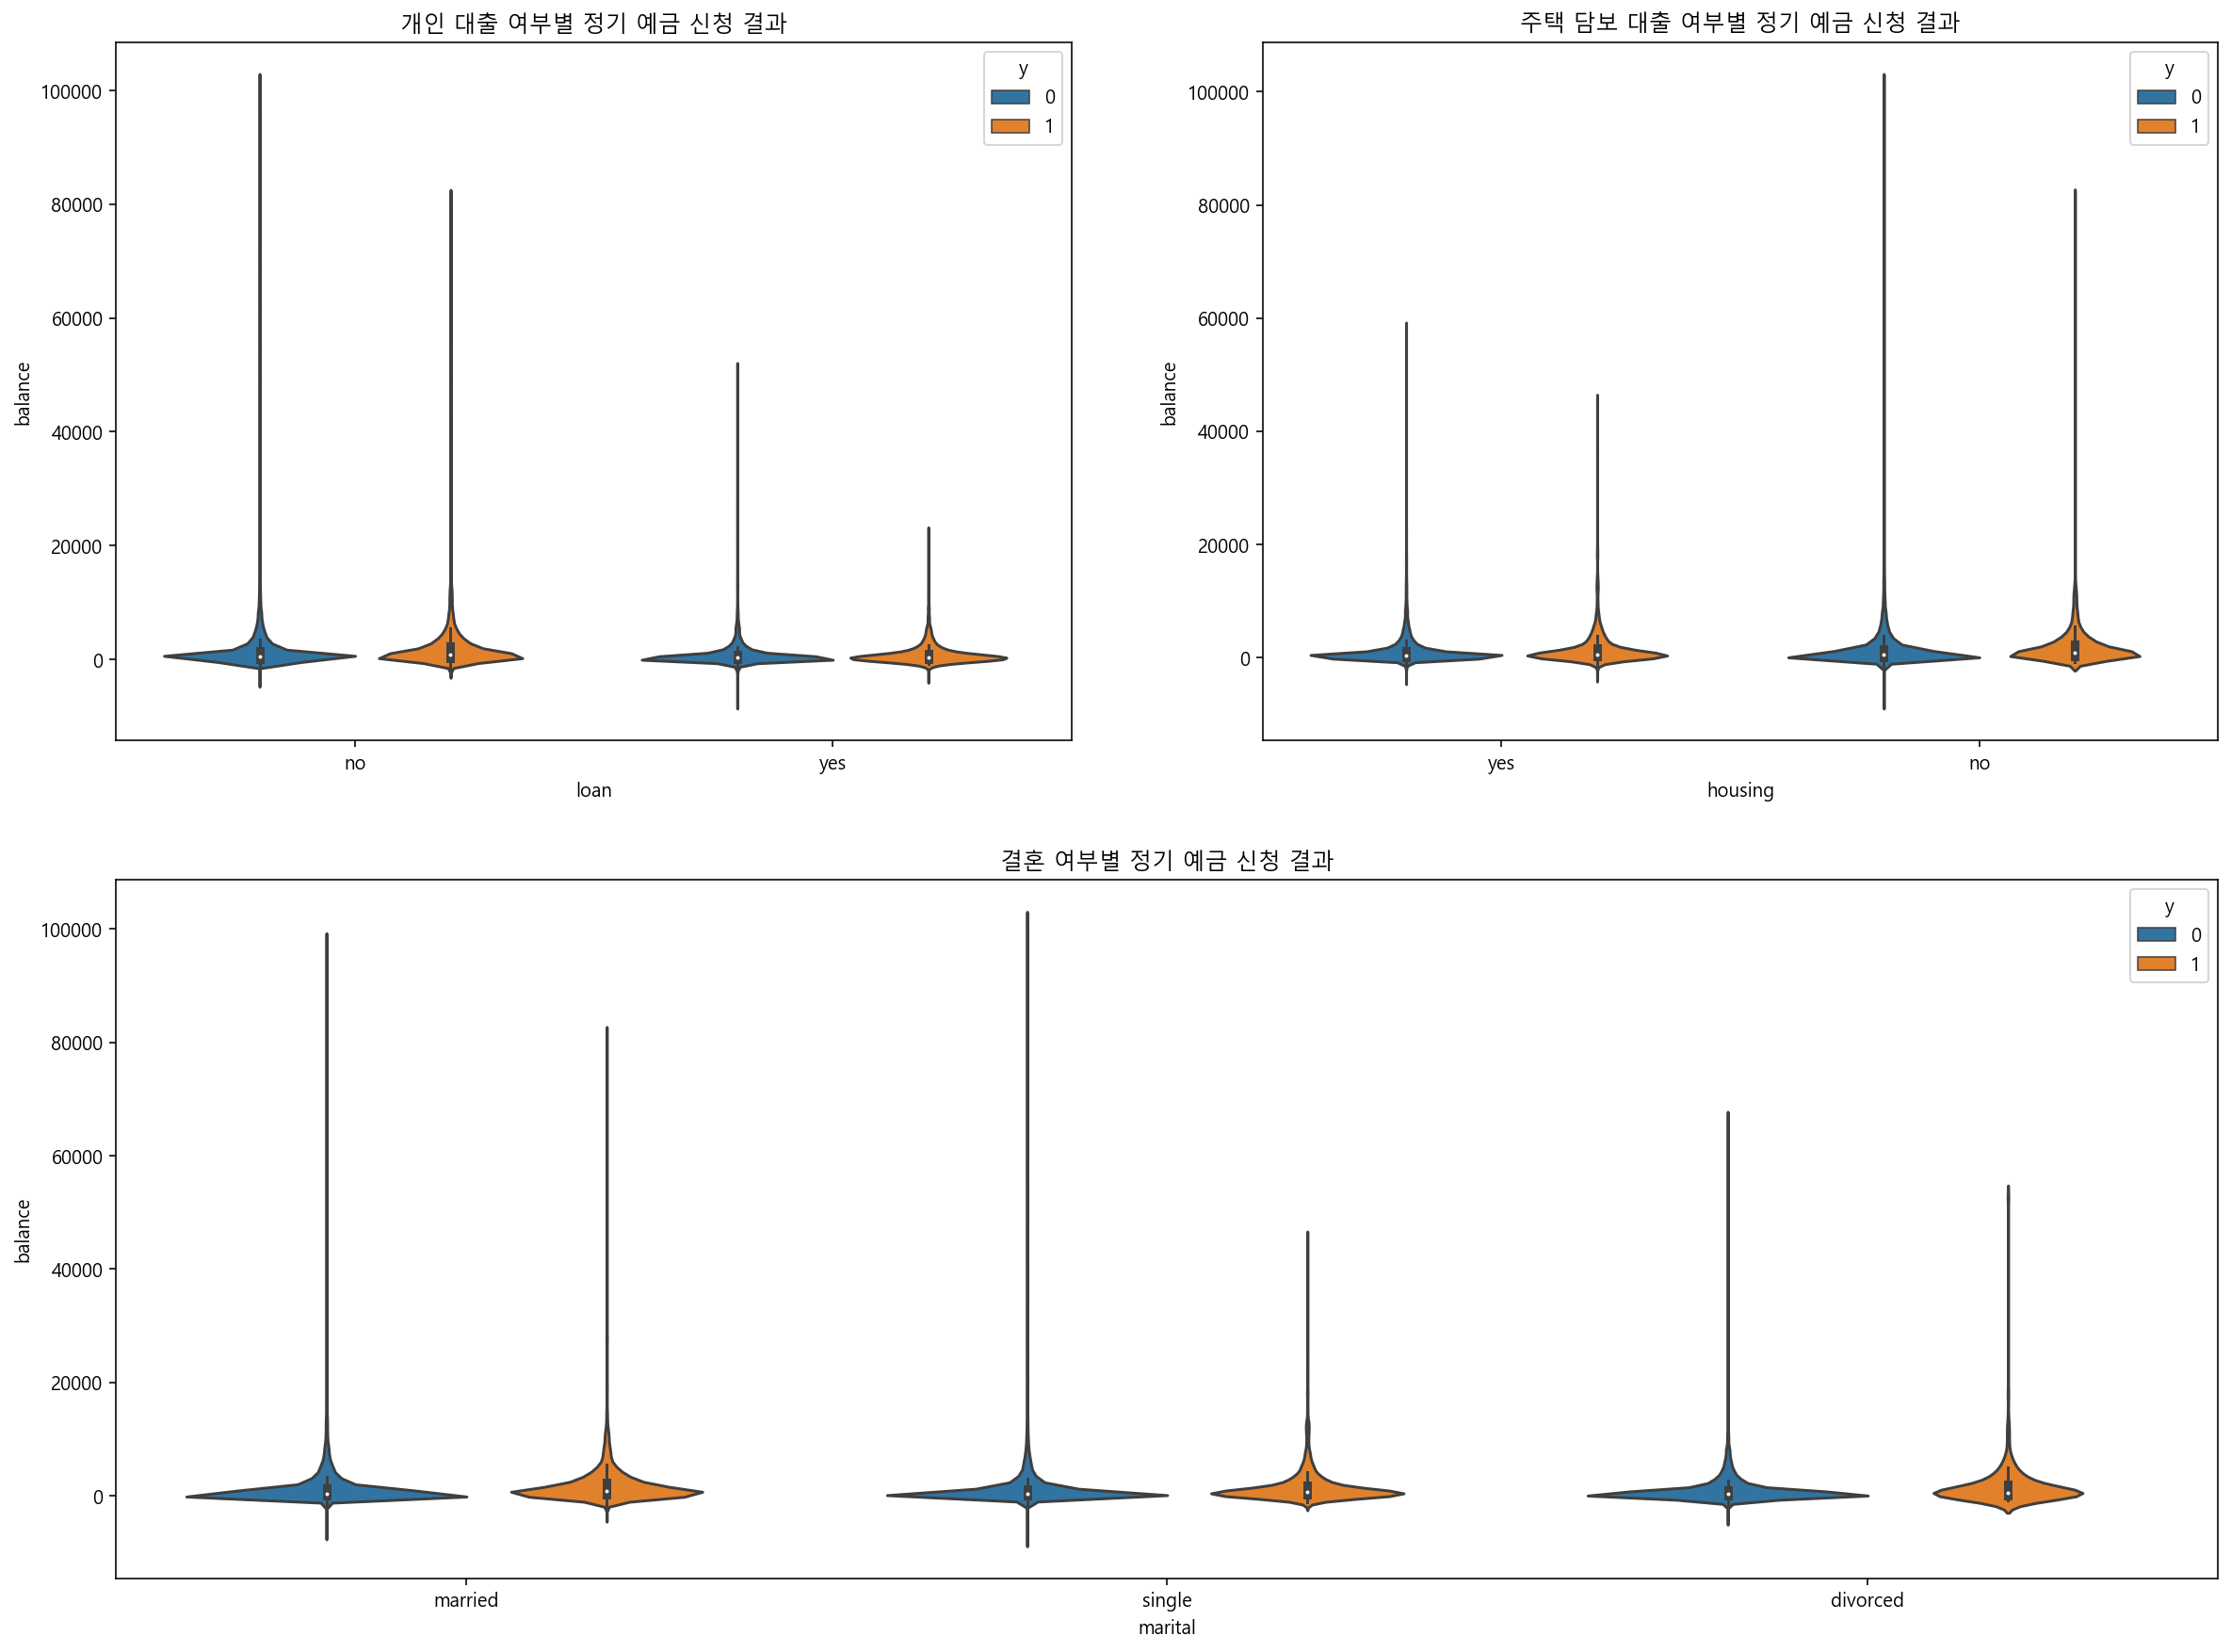

In [20]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

g = sns.violinplot(data=df, x='loan', y='balance', hue='y', ax=ax1)
g.set_title('개인 대출 여부별 정기 예금 신청 결과')

g1 = sns.violinplot(data=df, x='housing', y='balance', hue='y', ax=ax2)
g1.set_title('주택 담보 대출 여부별 정기 예금 신청 결과')

g2 = sns.violinplot(data=df, x='marital', y='balance', hue='y', ax=ax3)
# g2.set_xticklabels(df['job'].unique(), rotation = 90, rotation_mode = 'anchor')
g2.set_title('결혼 여부별 정기 예금 신청 결과')
plt.show()

정기 예금 고객만 확인해보았습니다.

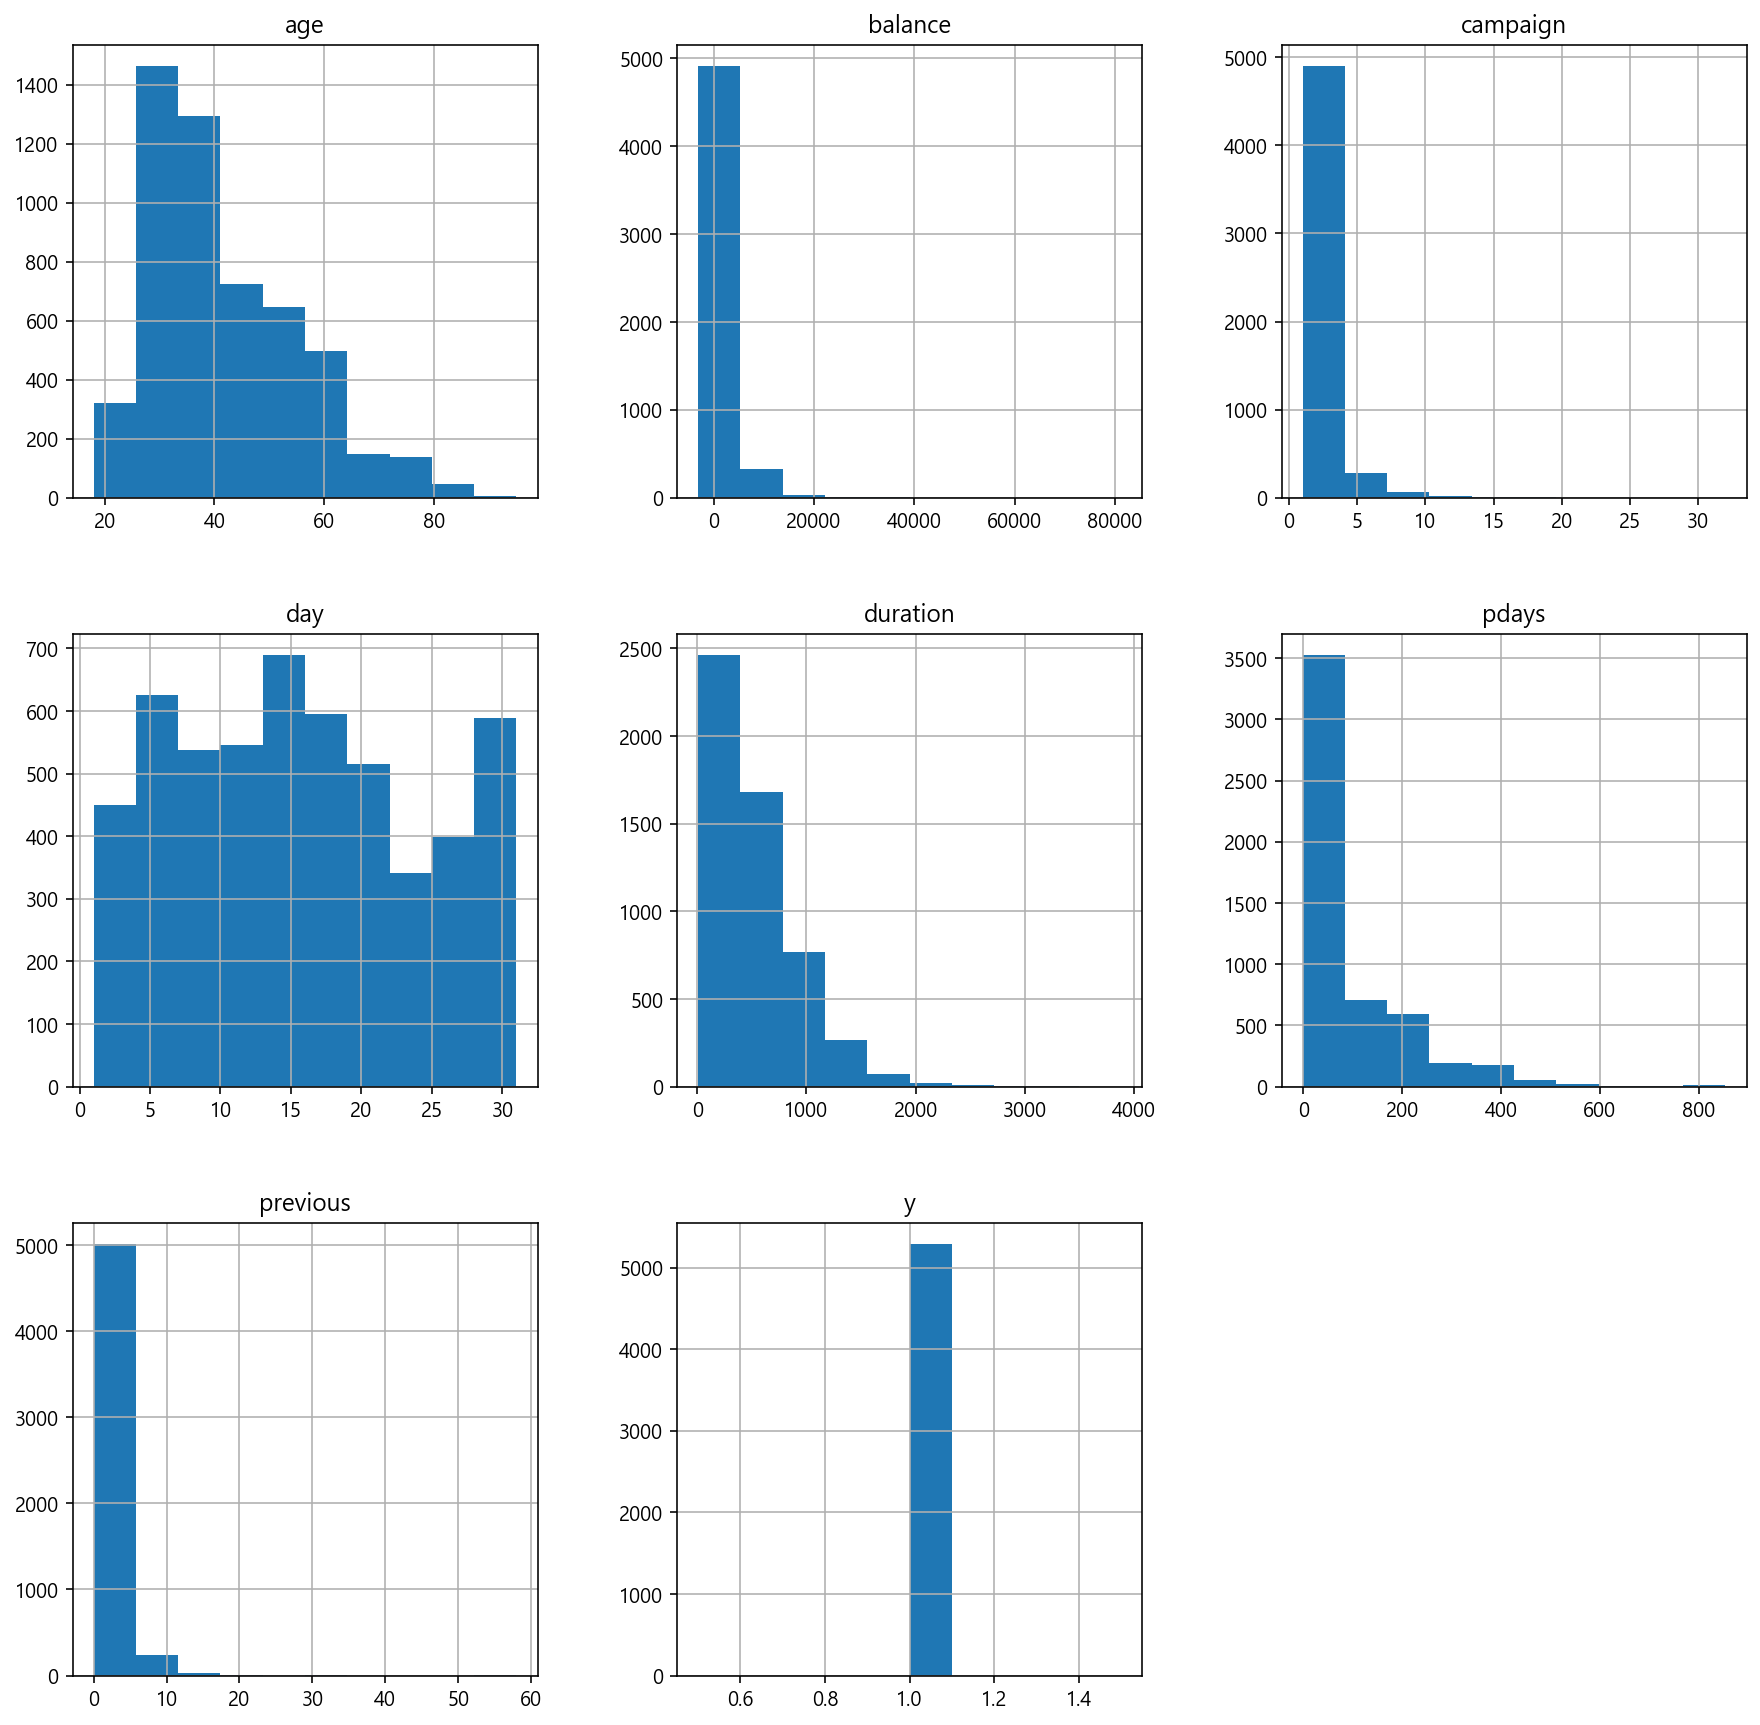

In [21]:
h = df[df['y'] == 1].hist(figsize=(15, 15))

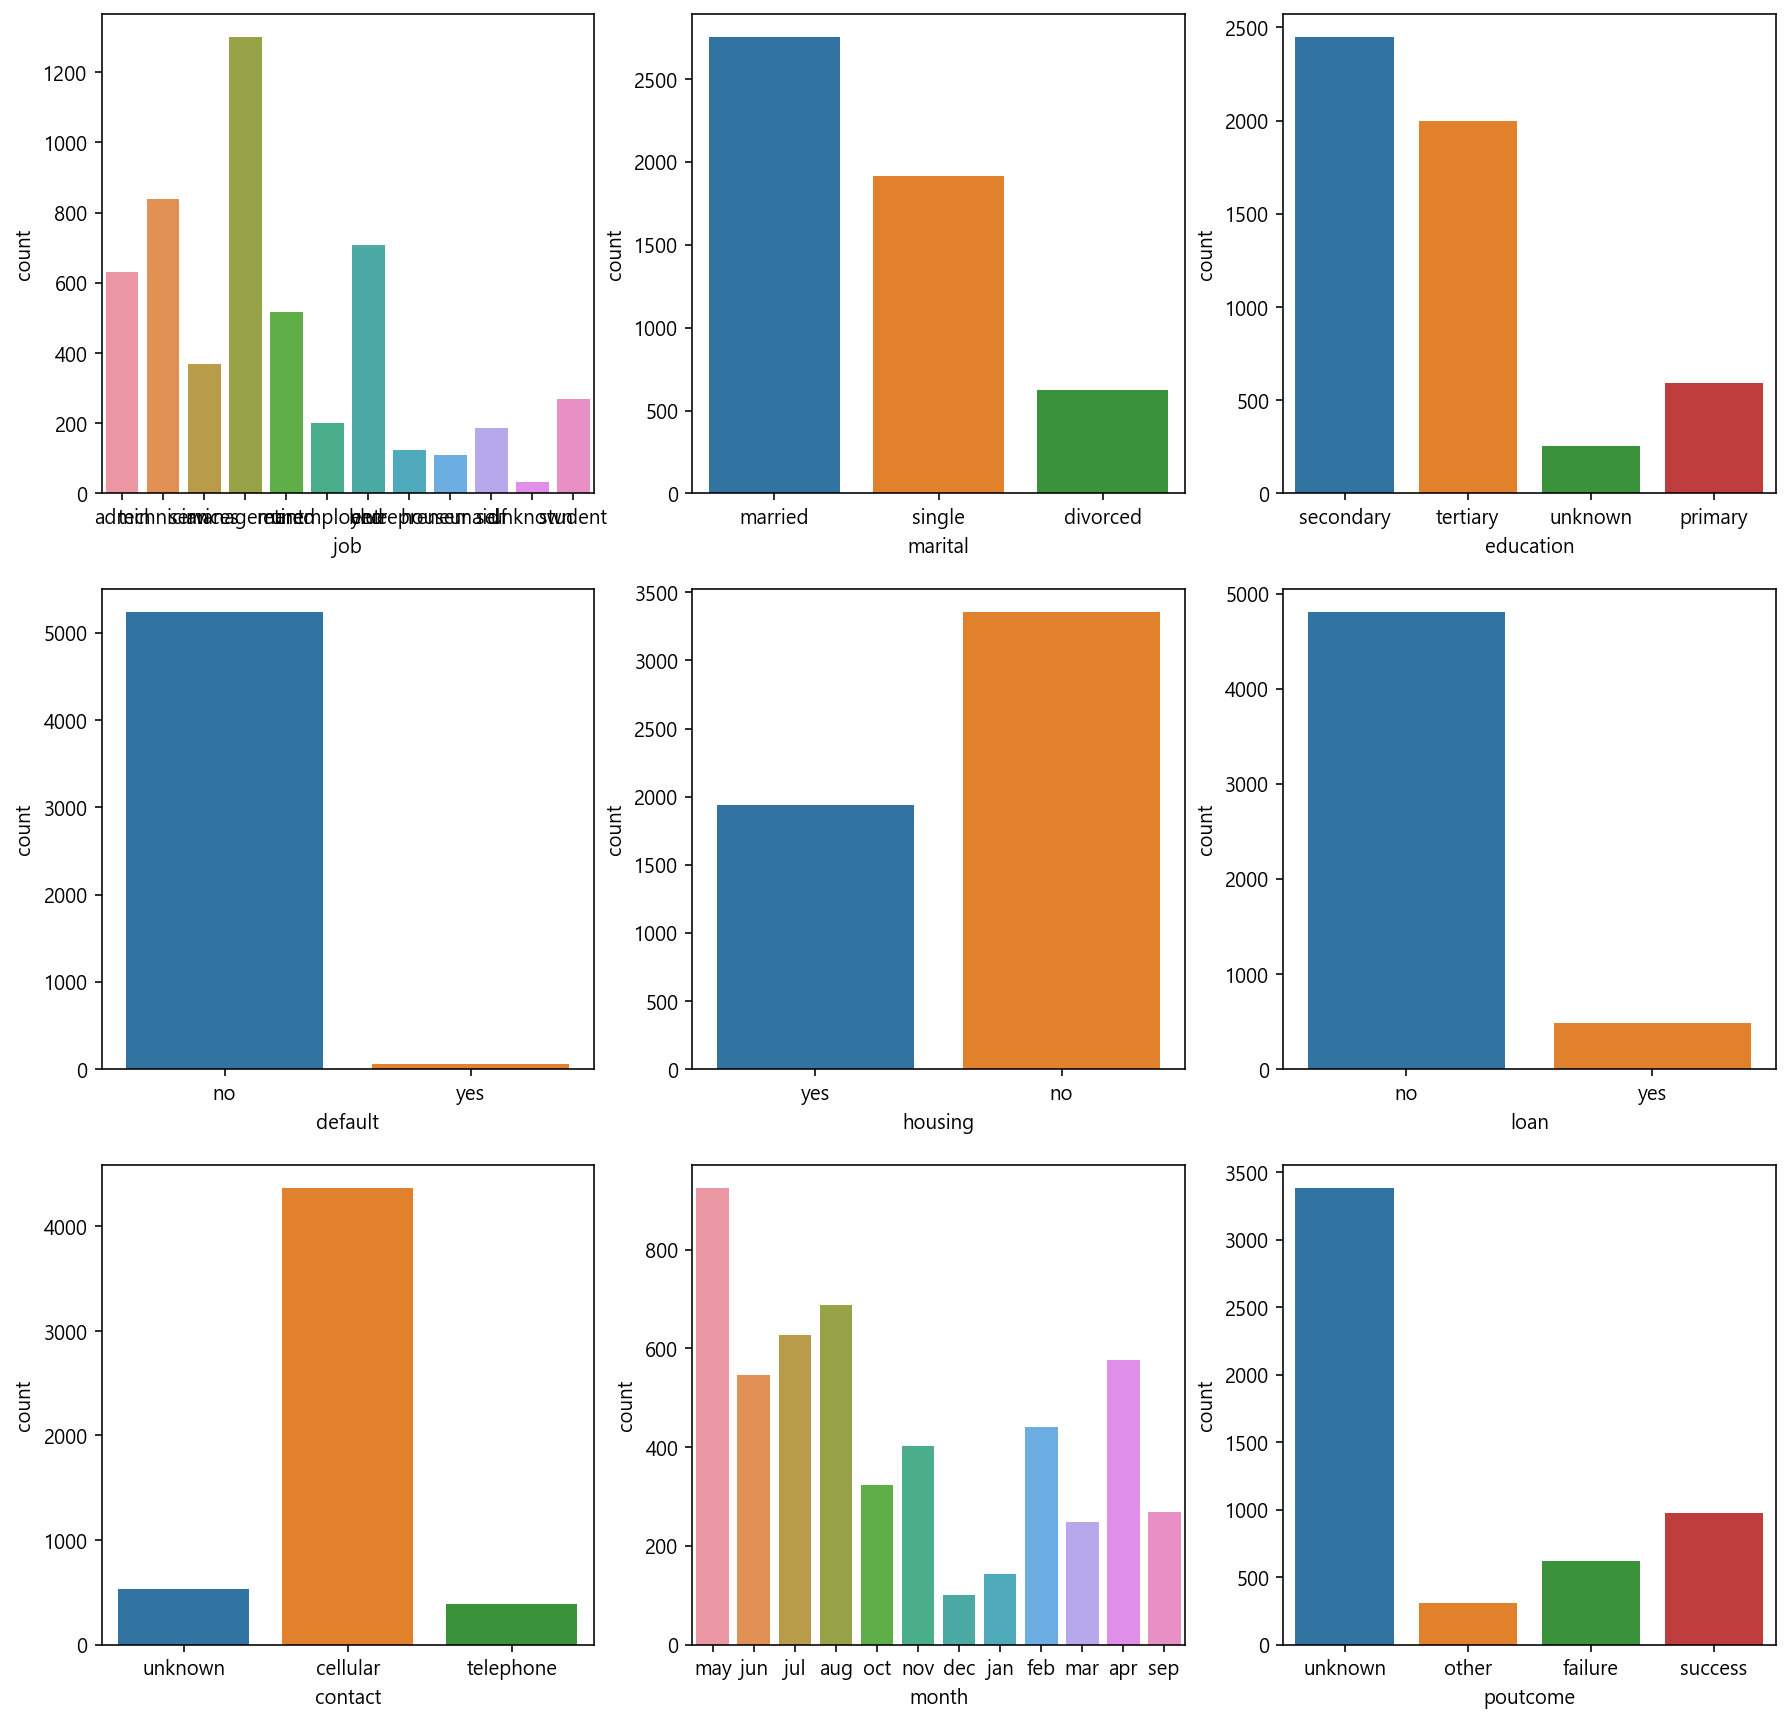

In [22]:
cat = df[cat_cols]
cat_y = cat[df['y'] == 1]

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))

for i, col_name in enumerate(cat_cols):
    row = i // 3
    col = i % 3
    sns.countplot(data=cat_y, x=col_name, ax=axes[row, col])

직업별 교육수준을 확인해보았습니다.

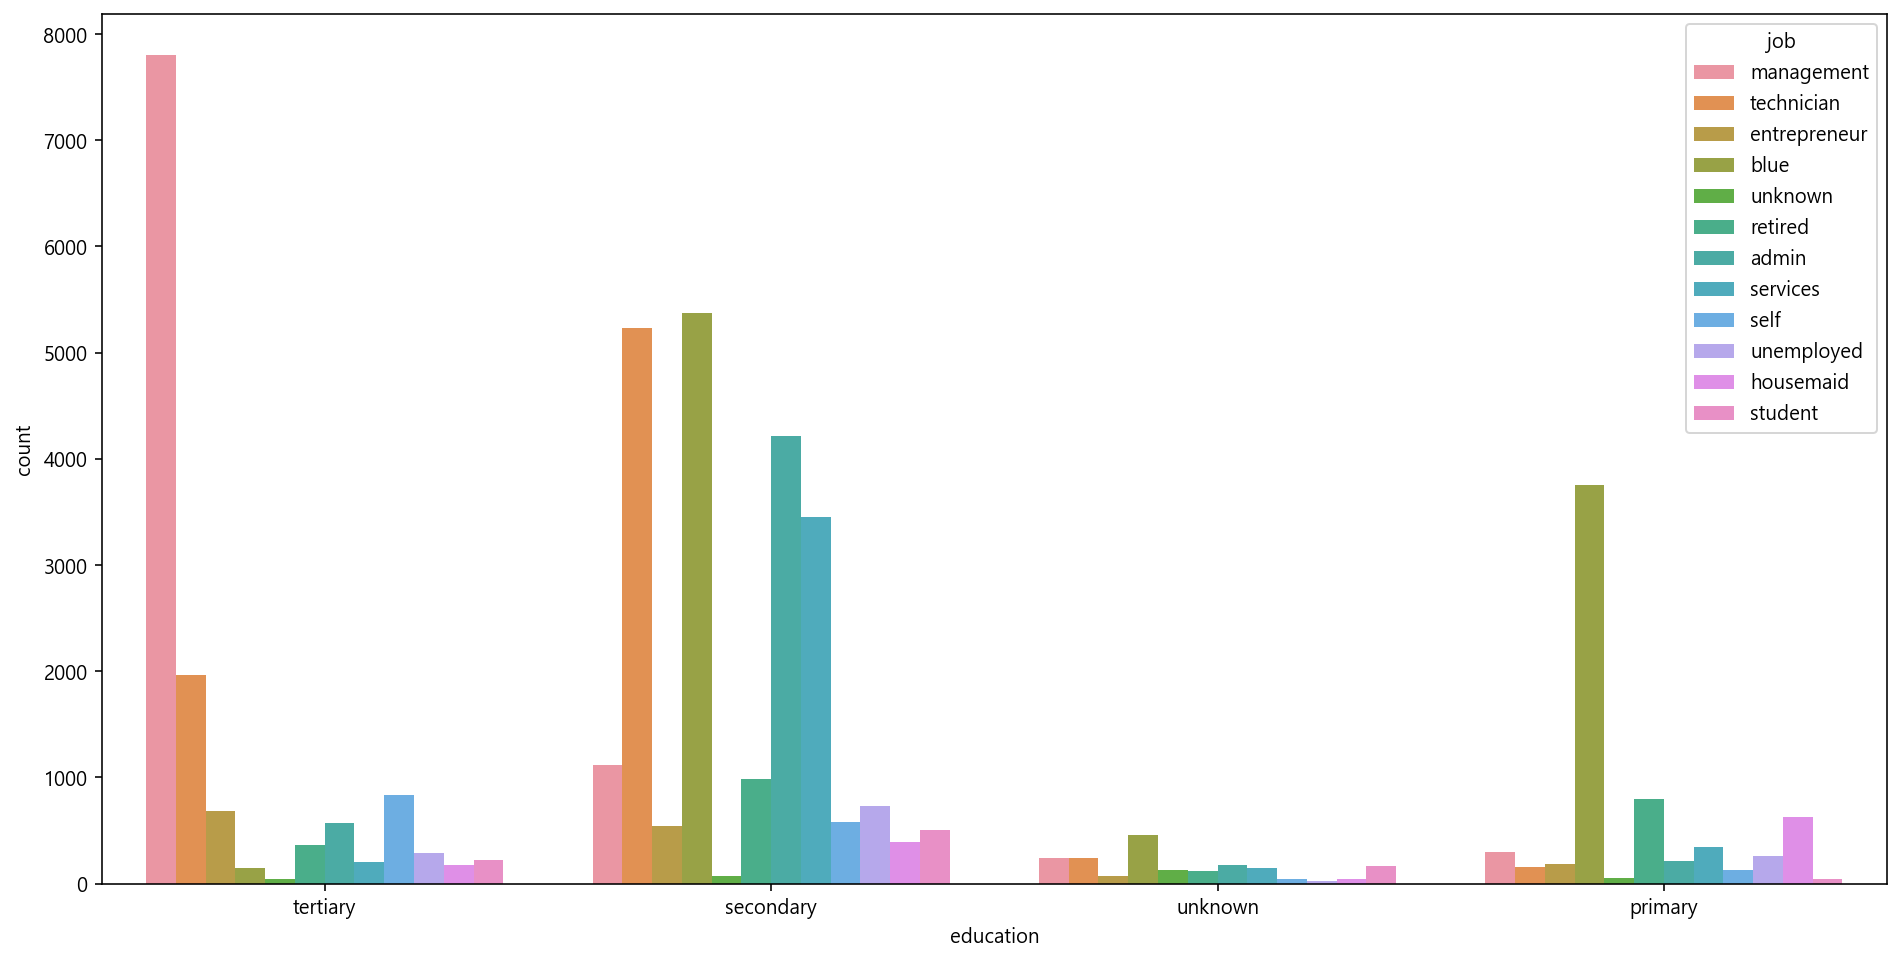

In [23]:
plt.figure(figsize=(16, 8))
sns.countplot(data=df, x='education', hue='job')

계좌 잔고가 높은 사람을 확인해보았습니다.

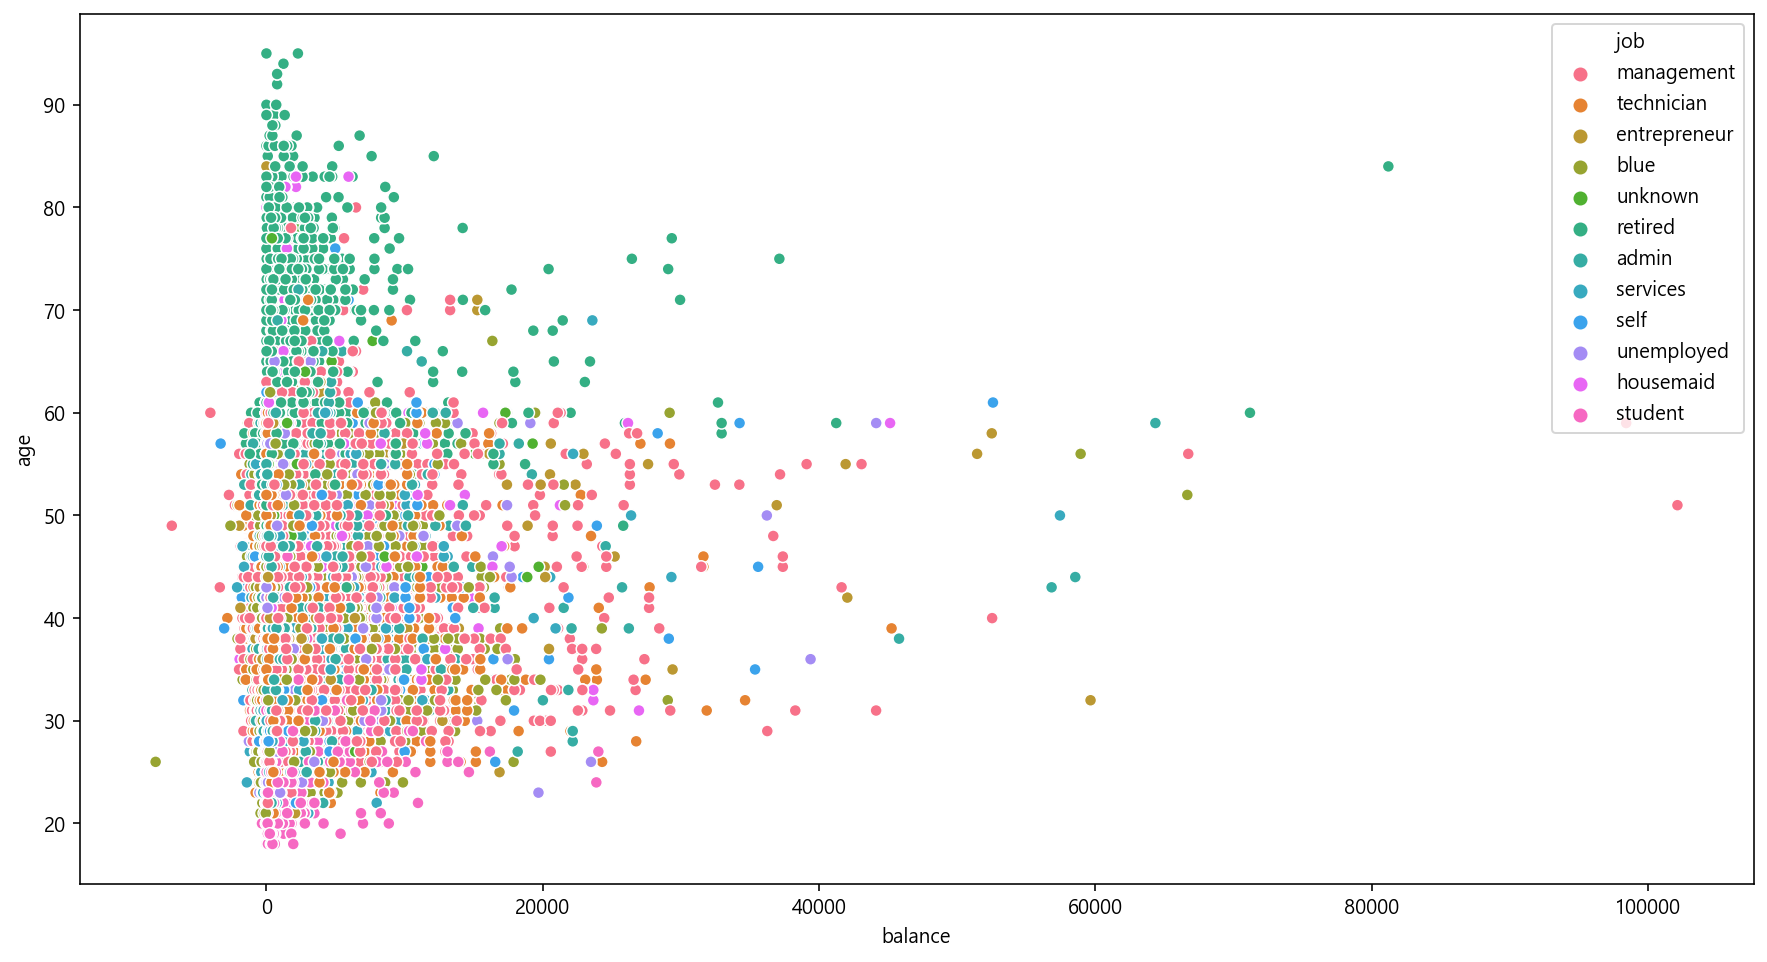

In [24]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='balance', y='age', hue='job')

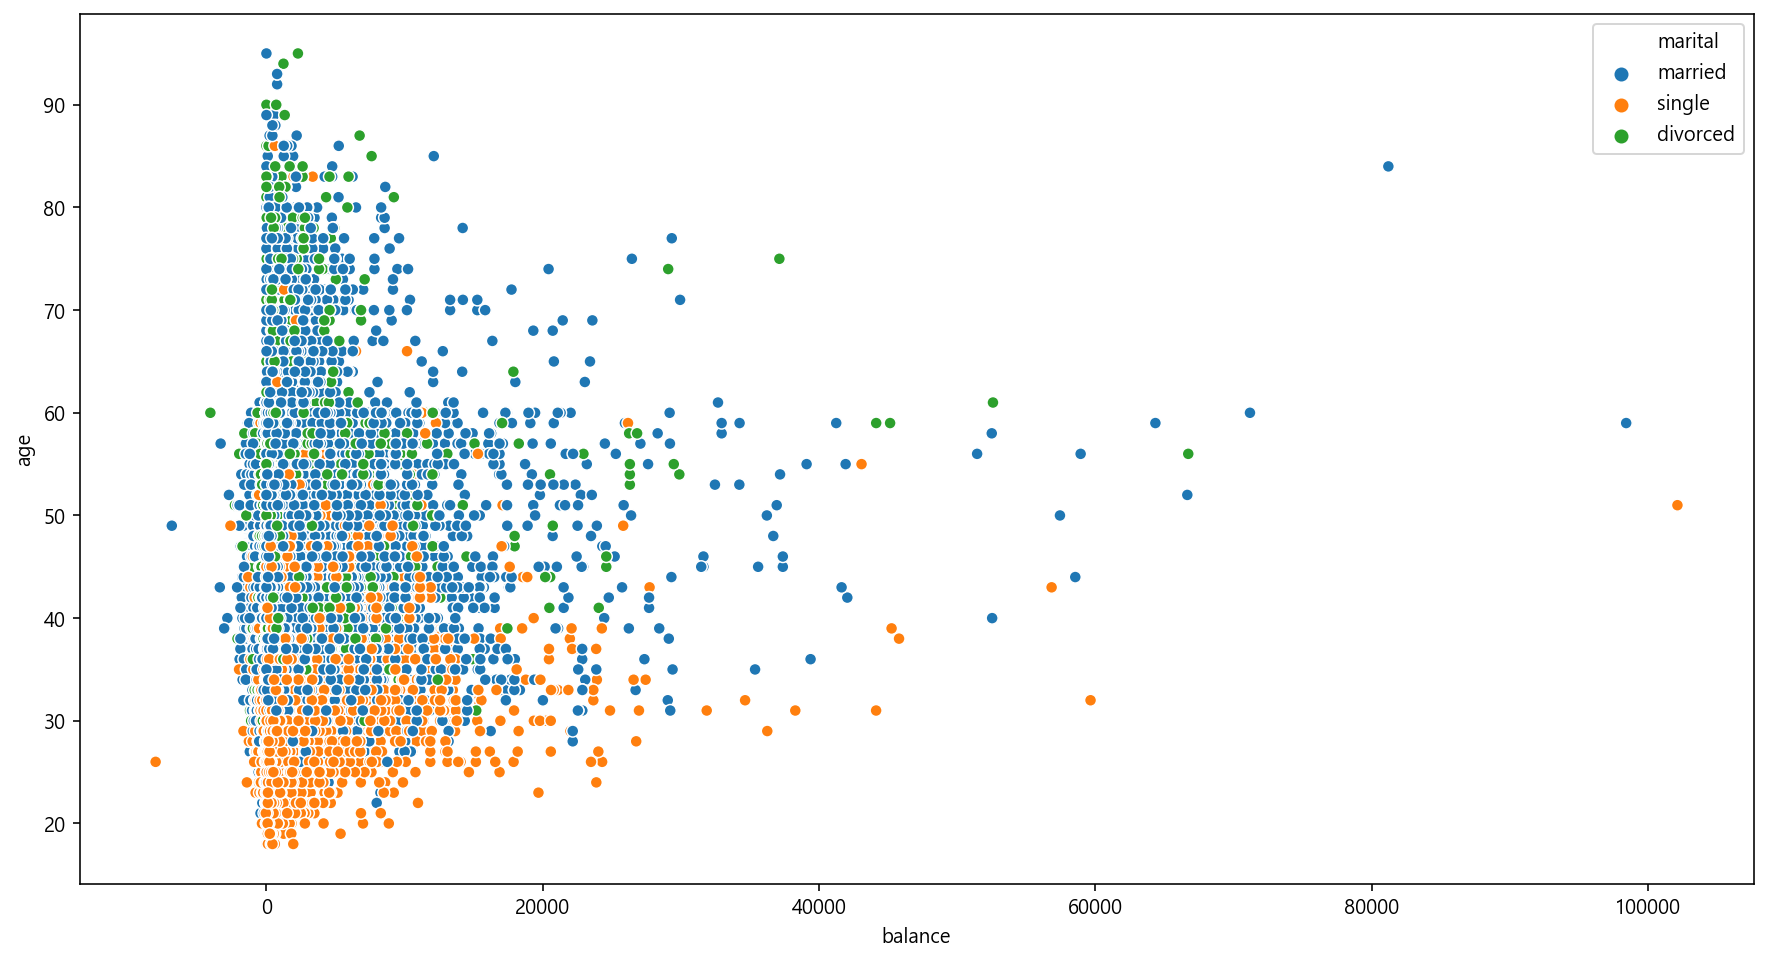

In [25]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='balance', y='age', hue='marital')

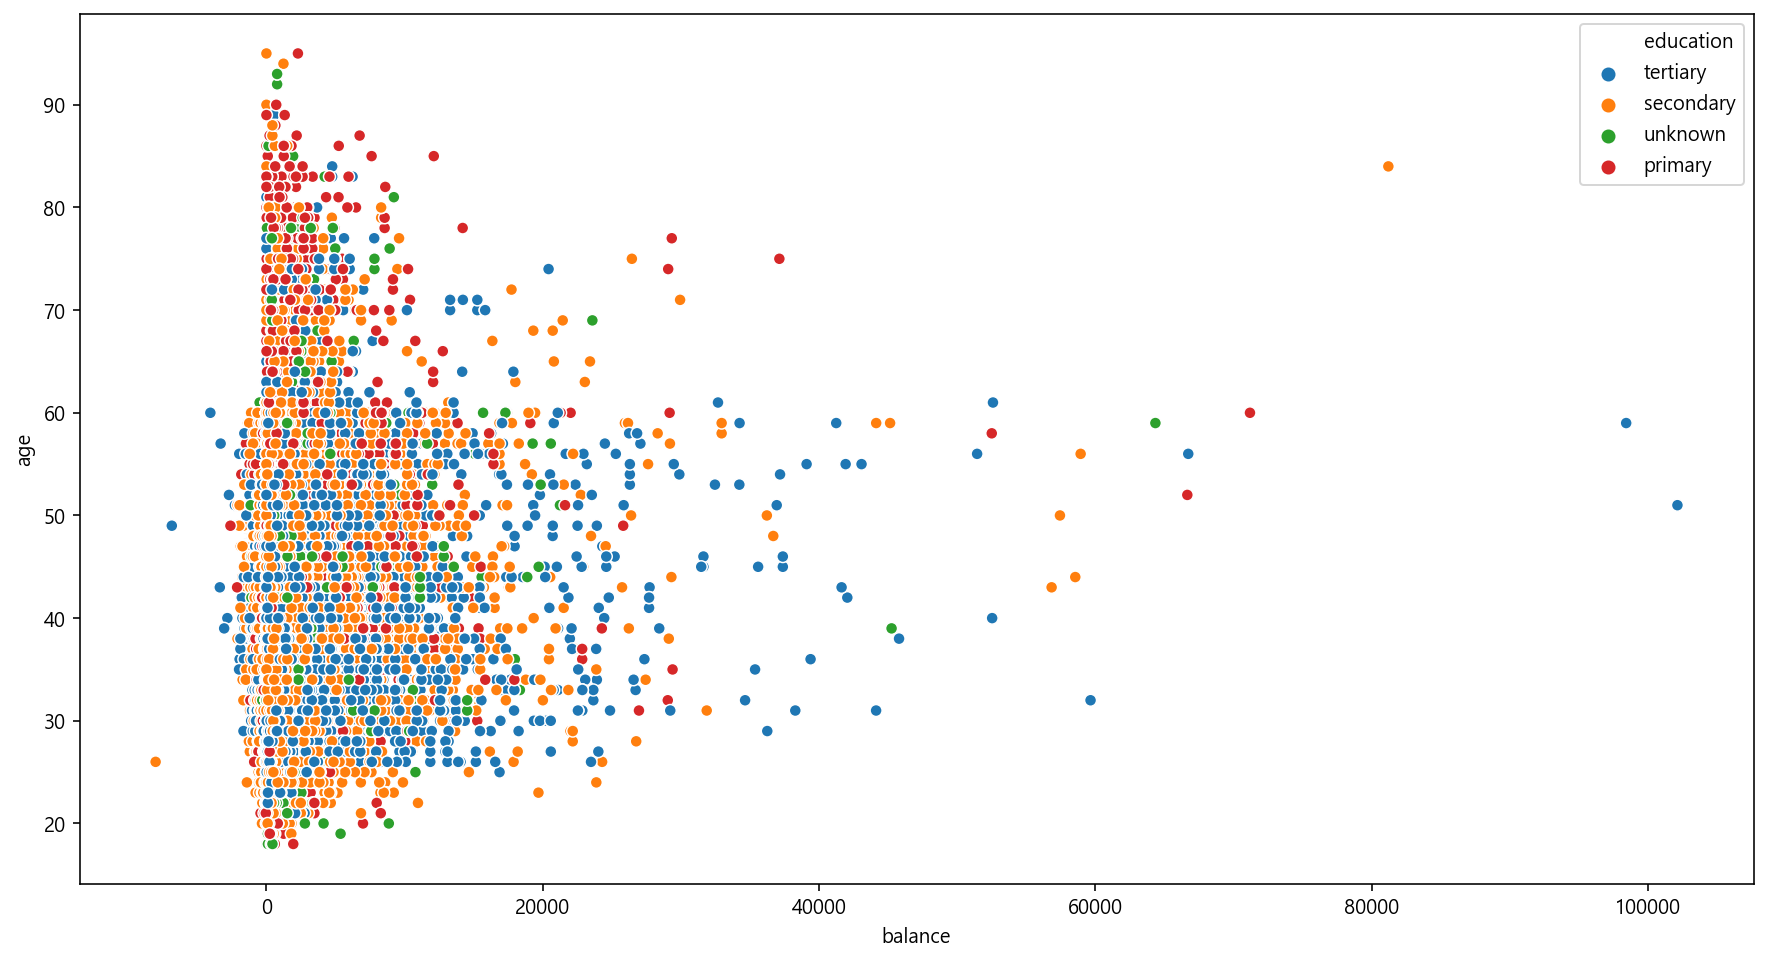

In [26]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='balance', y='age', hue='education')

데이터가 2008년 5월부터 2010년 11월까지 수집되었고 시작된 달에 가장 많이 캠페인 활동이 있었습니다.

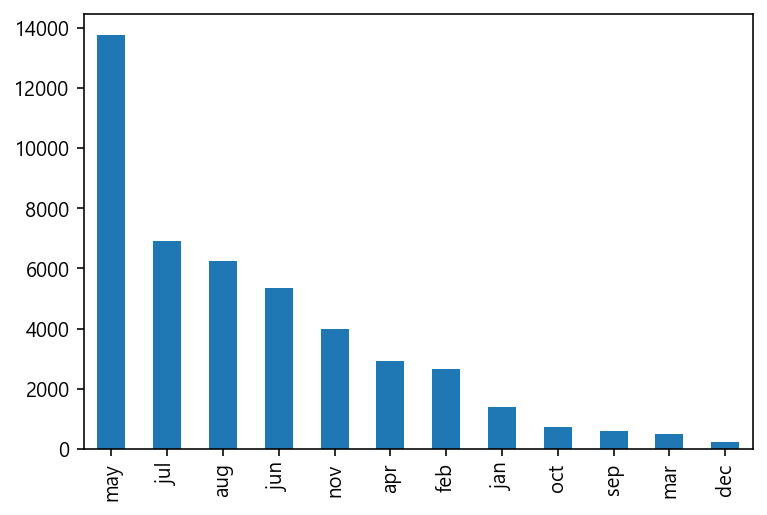

In [27]:
df.month.value_counts().plot.bar()

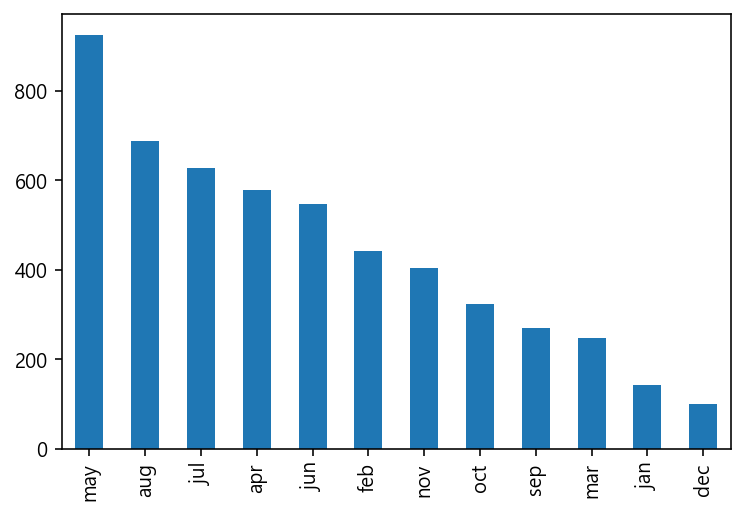

In [28]:
df_y1 = df[df['y']==1]
df_y1.month.value_counts().plot.bar()

각각의 달에 따른 정기 예금 신청 결과 비율을 보았습니다.

In [29]:
values = [[142, 1403], [441, 2649], [248, 477], [577, 2932], [925, 13766], [546, 5341], [627, 6895], [688, 6247], [269, 579], [323, 738], [403, 3970], [100, 214]]
index = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
columns = ['true', 'counts']
months = pd.DataFrame(values, index=index, columns=columns)
print(months)

     true  counts
jan   142    1403
feb   441    2649
mar   248     477
apr   577    2932
may   925   13766
jun   546    5341
jul   627    6895
aug   688    6247
sep   269     579
oct   323     738
nov   403    3970
dec   100     214


In [30]:
months['prob'] = months['true'] / months['counts']
months

true  counts      prob
jan   142    1403  0.101212
feb   441    2649  0.166478
mar   248     477  0.519916
apr   577    2932  0.196794
may   925   13766  0.067195
jun   546    5341  0.102228
jul   627    6895  0.090935
aug   688    6247  0.110133
sep   269     579  0.464594
oct   323     738  0.437669
nov   403    3970  0.101511
dec   100     214  0.467290

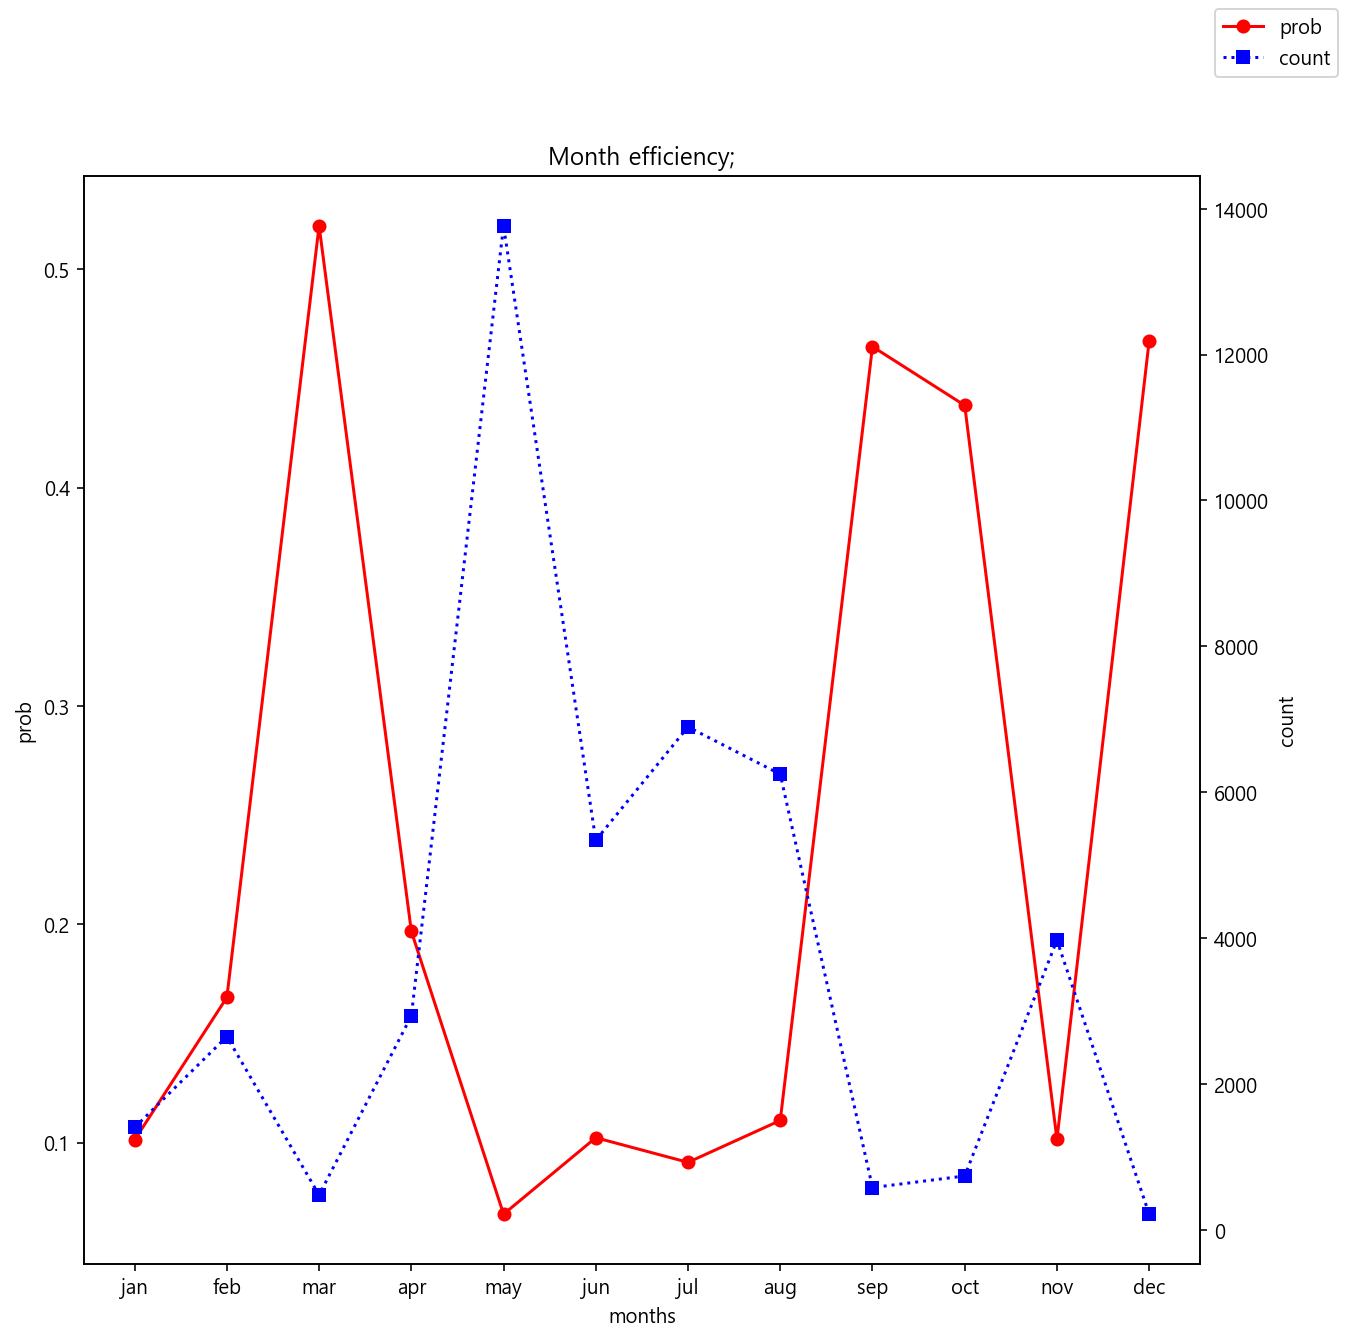

In [31]:
fig , ax0 = plt.subplots(figsize=(10, 10))
ax1 = ax0.twinx()
ax0.set_title("Month efficiency;")
ax0.plot(months["prob"] ,'r-', label = "prob" ,marker='o')
ax0.set_ylabel("prob")
ax0.grid(False)
ax1.plot(months["counts"] ,'b:', label ="count" , marker = 's')
ax1.set_ylabel("count")
ax1.grid(False)
ax0.set_xlabel("months")
fig.legend()
plt.show()

<img src="./data/persona1.png" width="500">

<img src="./data/persona2.png" width="500">

## Feature Engineering

[통계분석](file:///C:/Users/hongs/Downloads/prj3_stat.html#t-%EA%B2%80%EC%A0%95)

EDA를 통해 확인해보니 변수의 이상치 처리가 필요해보였습니다.
1. 'pdays'변수는 -1인 값이 고객이 이전 캠페인에 대해 연락을 받지 않았음을 의미하는데 대부분의 값이 -1이라 이전 캠페인에 대한 응답여부 변수로 바꿔줄 것 입니다.
2. 'previous'변수는 이번 캠페인 이전에 수행된 연락횟수를 의미하는데 과도하게 큰 이상치 하나를 지워줄 것입니다.
3. 'day'변수는 이번 캠페인에서 마지막으로 연락된 날짜인데 분석에 의미가 없기 때문에 삭제할 것입니다.
4. 종속변수와 높은 상관관계를 가져서 당연한 결과로 이어지는 'duration' 변수는 삭제할 것입니다.
5. 'poutcome'변수는 이상치가 너무 많아서 삭제할 것입니다.

### 'pdays' 처리

In [32]:
df['panswer'] = np.where(df['pdays'] == -1, 0, 1)
df['panswer'].value_counts()

0    36954
1     8257
Name: panswer, dtype: int64

In [33]:
del df['pdays']

### 'previous' 처리

In [34]:
df.previous.value_counts(ascending=True).head(3)

275    1
32     1
41     1
Name: previous, dtype: int64

In [35]:
df[df.previous == 275]

age         job  marital education default  balance housing loan  \
29182   40  management  married  tertiary      no      543     yes   no   

        contact  day month  duration  campaign  previous poutcome  y  panswer  
29182  cellular    2   feb       349         2       275    other  0        1

In [36]:
pre_275 = df[df['previous'] == 275].index
df = df.drop(pre_275)

### 'day' 처리

In [37]:
del df['day']

### 'duration' 처리

In [38]:
del df['duration']

### 'poutcome' 처리

In [39]:
del df['poutcome']

### 변수 인코딩

In [40]:
df.to_csv('telemarketing.csv', index=False)
df = pd.read_csv('telemarketing.csv')
df.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47          blue  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact month  campaign  previous  y  panswer  
0  unknown   may         1         0  0        0  
1  unknown   may         1         0  0        0  
2  unknown   may         1         0  0        0  
3  unknown   may         1         0  0        0  
4  unknown   may         1         0  0        0

In [41]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

In [42]:
bin_cols = df.nunique()[df.nunique() == 2].index.tolist()
print(bin_cols)

['default', 'housing', 'loan', 'y', 'panswer']


In [43]:
bin_cols = ['default', 'housing', 'loan']
bin_cols

['default', 'housing', 'loan']

In [44]:
multi_cols = [x for x in cat_columns if x not in bin_cols]
multi_cols

['job', 'marital', 'education', 'contact', 'month']

In [45]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for i in bin_cols:
    df[i] = le.fit_transform(df[i])
df[bin_cols].head()

default  housing  loan
0        0        1     0
1        0        1     0
2        0        1     1
3        0        1     0
4        0        0     0

In [46]:
df = pd.get_dummies(data = df, columns = multi_cols, drop_first=True)
df

age  default  balance  housing  loan  campaign  previous  y  panswer  \
0       58        0     2143        1     0         1         0  0        0   
1       44        0       29        1     0         1         0  0        0   
2       33        0        2        1     1         1         0  0        0   
3       47        0     1506        1     0         1         0  0        0   
4       33        0        1        0     0         1         0  0        0   
...    ...      ...      ...      ...   ...       ...       ... ..      ...   
45205   51        0      825        0     0         3         0  1        0   
45206   71        0     1729        0     0         2         0  1        0   
45207   72        0     5715        0     0         5         3  1        1   
45208   57        0      668        0     0         4         0  0        0   
45209   37        0     2971        0     0         2        11  0        1   

       job_blue  ...  month_dec  month_feb  month_jan  month_jul  month_jun  \
0             0  ...          0          0          0          0          0   
1             0  ...          0          0          0          0          0   
2             0  ...          0          0          0          0          0   
3             1  ...          0          0          0          0          0   
4             0  ...          0          0          0          0          0   
...         ...  ...        ...        ...        ...        ...        ...   
45205         0  ...          0          0          0          0          0   
45206         0  ...          0          0          0          0          0   
45207         0  ...          0          0          0          0          0   
45208         1  ...          0          0          0          0          0   
45209         0  ...          0          0          0          0          0   

       month_mar  month_may  month_nov  month_oct  month_sep  
0              0          1          0          0          0  
1              0          1          0          0          0  
2              0          1          0          0          0  
3              0          1          0          0          0  
4              0          1          0          0          0  
...          ...        ...        ...        ...        ...  
45205          0          0          1          0          0  
45206          0          0          1          0          0  
45207          0          0          1          0          0  
45208          0          0          1          0          0  
45209          0          0          1          0          0  

[45210 rows x 38 columns]

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45210 entries, 0 to 45209
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45210 non-null  int64
 1   default              45210 non-null  int32
 2   balance              45210 non-null  int64
 3   housing              45210 non-null  int32
 4   loan                 45210 non-null  int32
 5   campaign             45210 non-null  int64
 6   previous             45210 non-null  int64
 7   y                    45210 non-null  int64
 8   panswer              45210 non-null  int64
 9   job_blue             45210 non-null  uint8
 10  job_entrepreneur     45210 non-null  uint8
 11  job_housemaid        45210 non-null  uint8
 12  job_management       45210 non-null  uint8
 13  job_retired          45210 non-null  uint8
 14  job_self             45210 non-null  uint8
 15  job_services         45210 non-null  uint8
 16  job_student          4

### 변수 스케일링
'balance'변수는 이상치가 매우 크기 때문에 로그변환 후 standard scaling을 진행하였습니다.

In [48]:
df['balance'] = df['balance'] + 8020

In [49]:
df.balance.describe()

count     45210.000000
mean       9382.290179
std        3044.797065
min           1.000000
25%        8092.000000
50%        8468.000000
75%        9448.000000
max      110147.000000
Name: balance, dtype: float64

In [50]:
import math
from sklearn import preprocessing

df['balance'] = preprocessing.scale(np.log(df['balance']+1))
df.describe()

age       default       balance       housing          loan  \
count  45210.000000  45210.000000  4.521000e+04  45210.000000  45210.000000   
mean      40.936231      0.018027  5.830785e-15      0.555828      0.160230   
std       10.618879      0.133050  1.000011e+00      0.496879      0.366823   
min       18.000000      0.000000 -3.968282e+01      0.000000      0.000000   
25%       33.000000      0.000000 -5.652964e-01      0.000000      0.000000   
50%       39.000000      0.000000 -3.514118e-01      1.000000      0.000000   
75%       48.000000      0.000000  1.642917e-01      1.000000      0.000000   
max       95.000000      1.000000  1.173110e+01      1.000000      1.000000   

           campaign      previous             y       panswer      job_blue  \
count  45210.000000  45210.000000  45210.000000  45210.000000  45210.000000   
mean       2.763858      0.574253      0.116987      0.182614      0.215262   
std        3.098053      1.907928      0.321409      0.386354      0.411009   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      0.000000      0.000000      0.000000      0.000000   
50%        2.000000      0.000000      0.000000      0.000000      0.000000   
75%        3.000000      0.000000      0.000000      0.000000      0.000000   
max       63.000000     58.000000      1.000000      1.000000      1.000000   

       ...     month_dec     month_feb     month_jan     month_jul  \
count  ...  45210.000000  45210.000000  45210.000000  45210.000000   
mean   ...      0.004733      0.058571      0.031033      0.152511   
std    ...      0.068638      0.234823      0.173409      0.359519   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

          month_jun     month_mar     month_may     month_nov     month_oct  \
count  45210.000000  45210.000000  45210.000000  45210.000000  45210.000000   
mean       0.118138      0.010551      0.304490      0.087812      0.016324   
std        0.322775      0.102175      0.460196      0.283025      0.126719   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

          month_sep  
count  45210.000000  
mean       0.012807  
std        0.112442  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 38 columns]

In [51]:
num_cols = ['balance', 'campaign', 'previous']

In [52]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled, columns = num_cols)
scaled.head()

balance  campaign  previous
0  0.507837  -0.56935 -0.300986
1 -0.590387  -0.56935 -0.300986
2 -0.606211  -0.56935 -0.300986
3  0.203011  -0.56935 -0.300986
4 -0.606798  -0.56935 -0.300986

In [53]:
print(df.shape)
df1 = df.drop(columns = num_cols, axis = 1)
df1 = df1.merge(scaled, left_index=True, right_index=True, how = "left")
print(df1.shape)

(45210, 38)
(45210, 38)


### 변수 설정 후 상관관계 확인

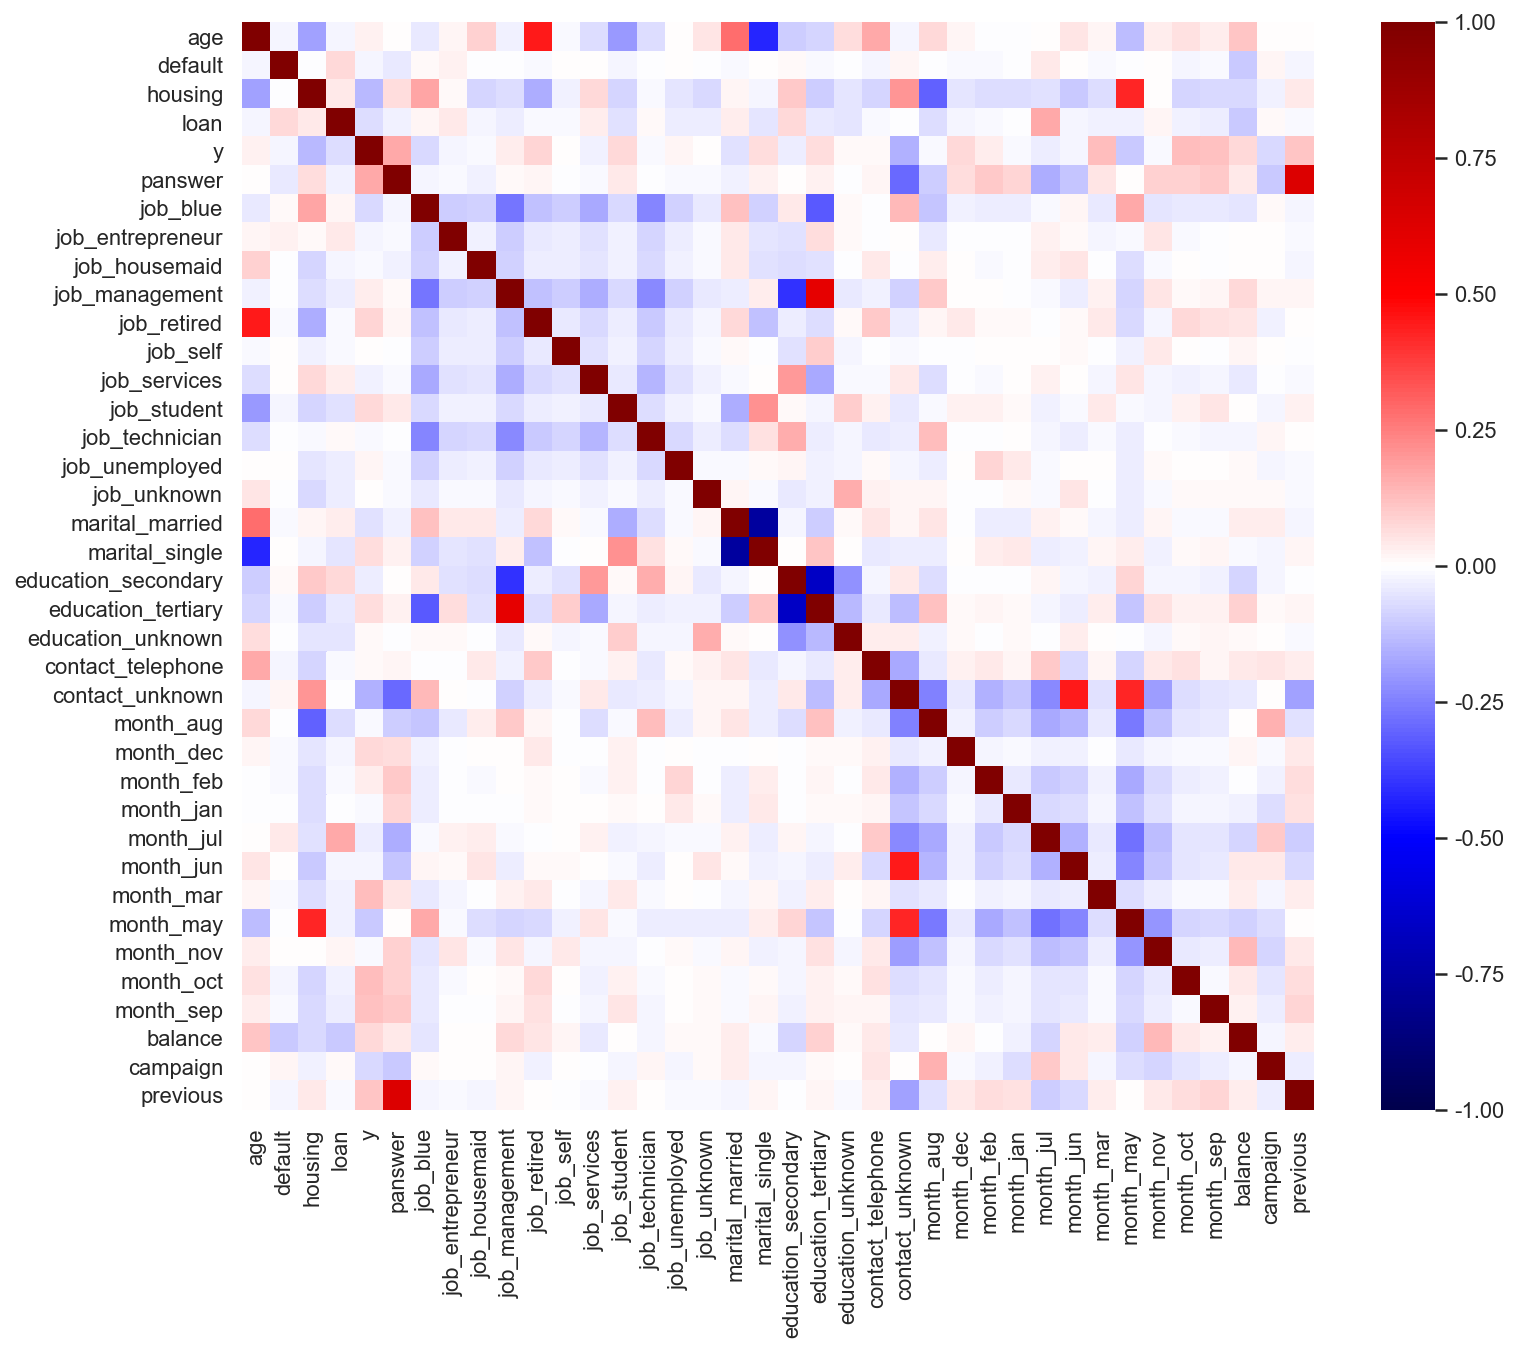

In [54]:
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(df1.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1)

In [55]:
df1.to_csv('survey_features.csv', index=False)
df1 = pd.read_csv('survey_features.csv')
df1.head()

age  default  housing  loan  y  panswer  job_blue  job_entrepreneur  \
0   58        0        1     0  0        0         0                 0   
1   44        0        1     0  0        0         0                 0   
2   33        0        1     1  0        0         0                 1   
3   47        0        1     0  0        0         1                 0   
4   33        0        0     0  0        0         0                 0   

   job_housemaid  job_management  ...  month_jul  month_jun  month_mar  \
0              0               1  ...          0          0          0   
1              0               0  ...          0          0          0   
2              0               0  ...          0          0          0   
3              0               0  ...          0          0          0   
4              0               0  ...          0          0          0   

   month_may  month_nov  month_oct  month_sep   balance  campaign  previous  
0          1          0          0          0  0.507837  -0.56935 -0.300986  
1          1          0          0          0 -0.590387  -0.56935 -0.300986  
2          1          0          0          0 -0.606211  -0.56935 -0.300986  
3          1          0          0          0  0.203011  -0.56935 -0.300986  
4          1          0          0          0 -0.606798  -0.56935 -0.300986  

[5 rows x 38 columns]

## 의사결정나무

In [56]:
X, y = df1.drop('y',axis=1), df1['y']
# to define the Intercept
import statsmodels.api as sm
X = sm.add_constant(X)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [57]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# Dot to png
import pydot

# 의사결정 트리 선언
dTreeAll = DecisionTreeClassifier(random_state=0)

# 훈련 (모든 리프 노드 사용)
dTreeAll.fit(X_train, y_train)

# 점수 출력
print("Train Set Score1 : {:.2f}".format(dTreeAll.score(X_train, y_train)))
print("Test  Set Score1 : {:.2f}".format(dTreeAll.score(X_test, y_test)))

# 의사결정 트리 선언(트리 깊이 제한)
dTreeLimit = DecisionTreeClassifier(max_depth=5, random_state=42)

# 훈련 (가지치기 : 리프노드 깊이 제한)
dTreeLimit.fit(X_train, y_train)

# 점수 출력
print("Train Set Score2 : {:.2f}".format(dTreeLimit.score(X_train, y_train)))
print("Test  Set Score2 : {:.2f}".format(dTreeLimit.score(X_test, y_test)))


export_graphviz(dTreeLimit, out_file="dicisionTree1.dot", class_names=["No deposit","deposit"],
                feature_names=df1.columns, impurity=False, filled=True)

# Encoding 중요
(graph,) = pydot.graph_from_dot_file('dicisionTree1.dot', encoding='utf8')

# Dot 파일을 Png 이미지로 저장
graph.write_png('dicisionTree1.png')

Train Set Score1 : 1.00
Test  Set Score1 : 0.81
Train Set Score2 : 0.89
Test  Set Score2 : 0.88


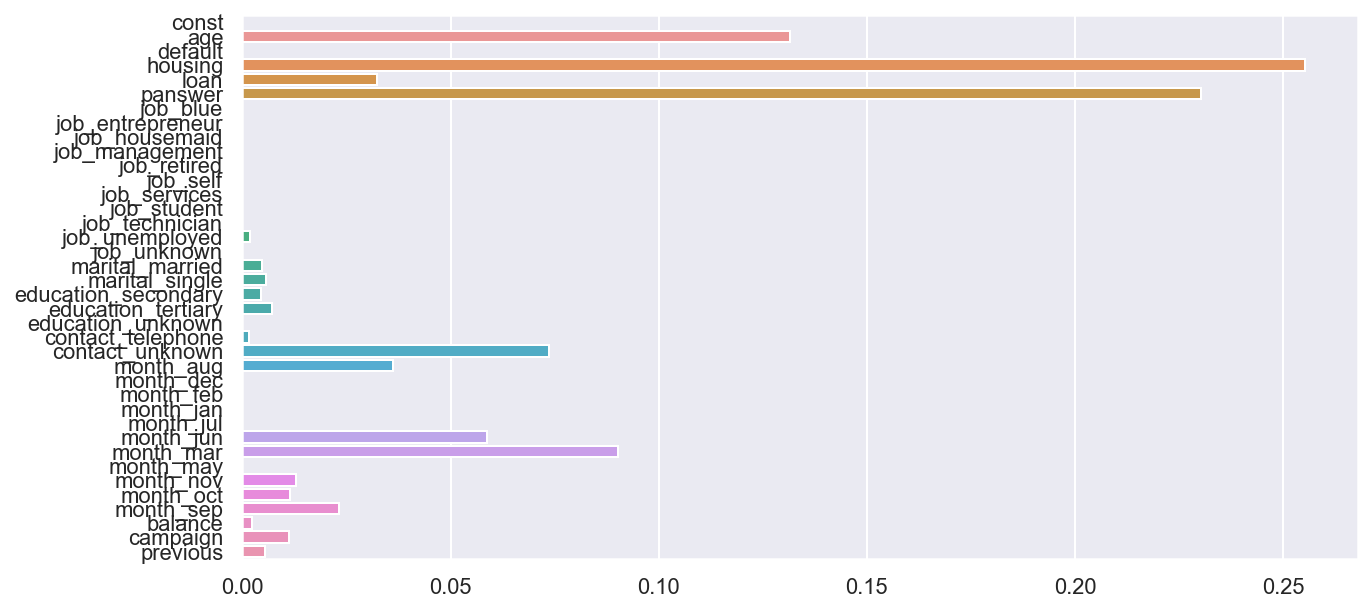

In [58]:
predictions = dTreeLimit.predict(X_test)
mf = dTreeLimit.feature_importances_
plt.figure(figsize=(10,5))
sns.barplot(y=X.columns, x= mf)

accuracy = 87.978
f1_score = 0.083
[[7906   43]
 [1044   49]]
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0       0.88      0.99      0.94      7949
           1       0.53      0.04      0.08      1093

    accuracy                           0.88      9042
   macro avg       0.71      0.52      0.51      9042
weighted avg       0.84      0.88      0.83      9042



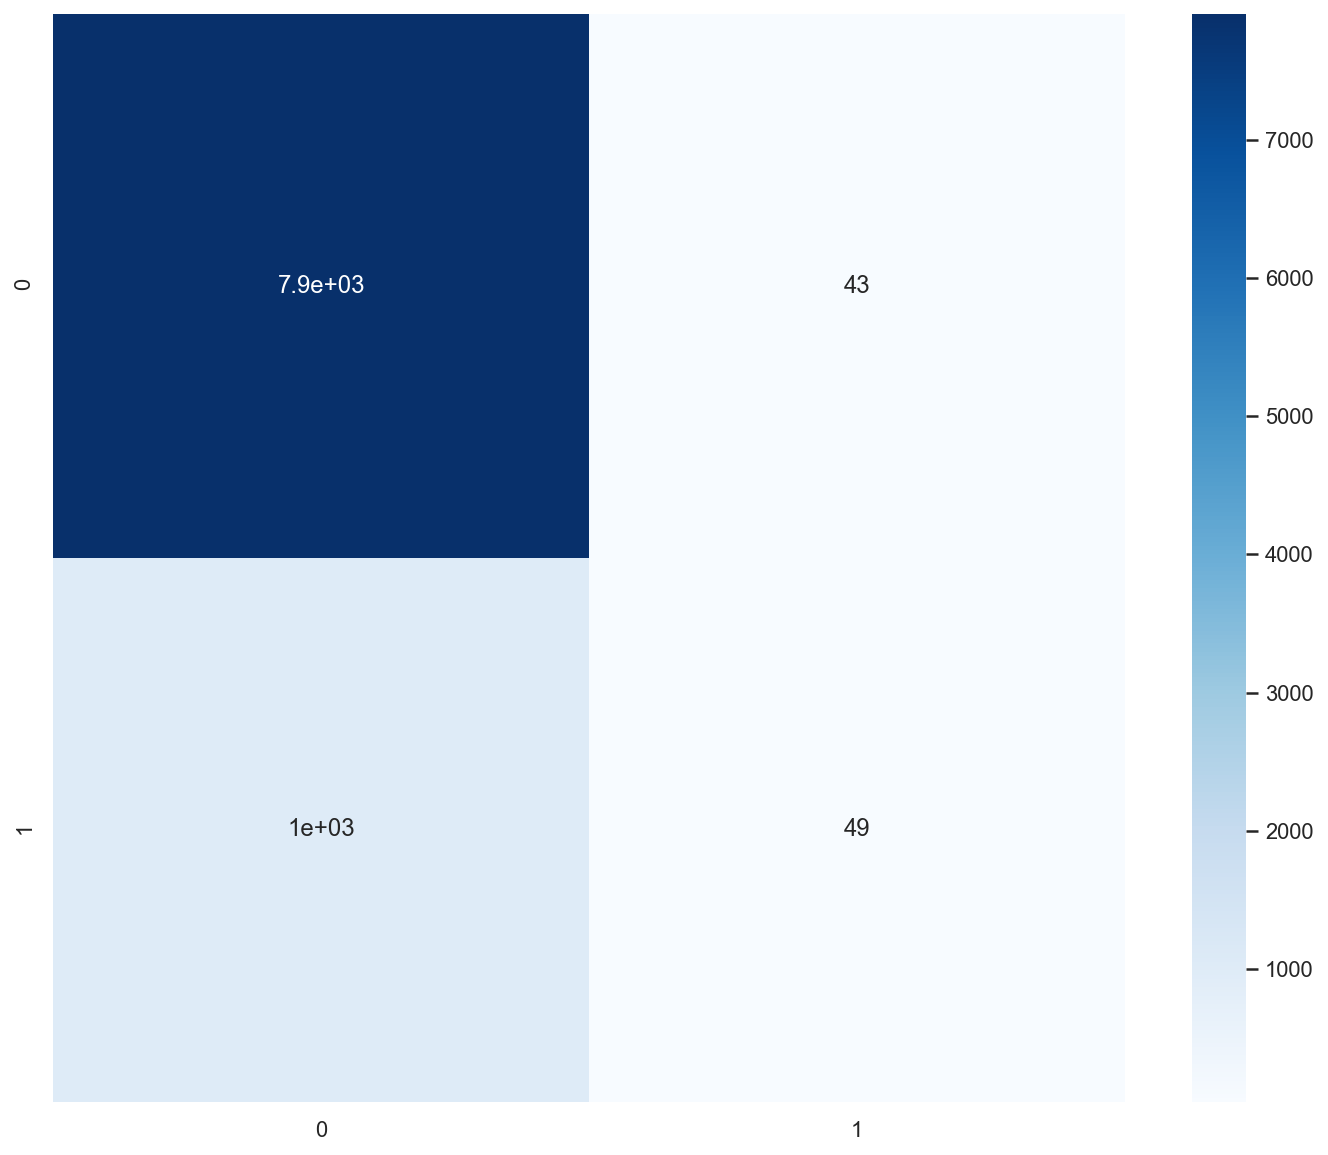

In [101]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print('accuracy = {:.3f}'.format(accuracy_score(y_test, predictions) * 100))
print('f1_score = {:.3f}'.format(f1_score(y_test, predictions)))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
print(cm)
print(sns.heatmap(cm, annot=True, cmap='Blues'))
from sklearn.metrics import classification_report
cr = classification_report(y_test, predictions)
print(cr)

## 로지스틱 회귀분석

In [60]:
# fitting logistic regression

import statsmodels.api as sm

pd.options.mode.chained_assignment = None

logitreg = sm.Logit(y_train, X_train)

logitreg_fit = logitreg.fit()

print(logitreg_fit.summary())

Optimization terminated successfully.
         Current function value: 0.310200
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                36168
Model:                          Logit   Df Residuals:                    36130
Method:                           MLE   Df Model:                           37
Date:                Mon, 27 Apr 2020   Pseudo R-squ.:                  0.1357
Time:                        15:31:08   Log-Likelihood:                -11219.
converged:                       True   LL-Null:                       -12981.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.4993      0.149    -10.053      0.000      -1.792      -1.207
ag

In [61]:
test_prob_logitreg = logitreg_fit.predict(X_test)

test_prob_logitreg

3776     0.022014
9928     0.110756
33409    0.241224
31885    0.269024
15738    0.098482
           ...   
31397    0.618962
13353    0.161077
38732    0.101568
5654     0.030325
3779     0.018446
Length: 9042, dtype: float64

### 후진제거법

In [62]:
cols = X.columns

In [63]:
def back_feature_elem (data_frame,dep_var,col_list):
    """ Takes in the dataframe, the dependent variable and a list of column names, runs the regression repeatedly eleminating feature with the highest
    P-value above alpha one at a time and returns the regression summary with all p-values below alpha"""

    while len(col_list)>0 :
        model=sm.Logit(dep_var,data_frame[col_list])
        result=model.fit(disp=0)
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)

result=back_feature_elem(X,y,cols)

In [64]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                45210
Model:                          Logit   Df Residuals:                    45182
Method:                           MLE   Df Model:                           27
Date:                Mon, 27 Apr 2020   Pseudo R-squ.:                  0.1361
Time:                        15:31:10   Log-Likelihood:                -14095.
converged:                       True   LL-Null:                       -16315.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.3937      0.076    -18.289      0.000      -1.543      -1.244
housing                -0.6434      0.037    -17.322      0.000      -0.716      -0.571
loan                   -0.4553      0.052     -8.700      0.000      -0.558      -0.353
panswer                 0.5707      0.045     12.571      0.000       0.482       0.660
job_housemaid          -0.2292      0.108     -2.124      0.034      -0.441      -0.018
job_retired             0.5233      0.061      8.542      0.000       0.403       0.643
job_student             0.4373      0.084      5.198      0.000       0.272       0.602
job_unemployed          0.2332      0.084      2.762      0.006       0.068       0.399
marital_married        -0.2640      0.033     -8.078      0.000      -0.328      -0.200
education_secondary     0.2001      0.053      3.787      0.000       0.097       0.304
education_tertiary      0.3859      0.056      6.934      0.000       0.277       0.495
education_unknown       0.2481      0.088      2.807      0.005       0.075       0.421
contact_telephone      -0.2590      0.063     -4.119      0.000      -0.382      -0.136
contact_unknown        -1.2860      0.063    -20.485      0.000      -1.409      -1.163
month_aug              -0.7005      0.067    -10.397      0.000      -0.833      -0.568
month_dec               0.7957      0.151      5.271      0.000       0.500       1.092
month_feb              -0.3549      0.073     -4.885      0.000      -0.497      -0.212
month_jan              -1.0210      0.102     -9.961      0.000      -1.222      -0.820
month_jul              -0.5517      0.067     -8.250      0.000      -0.683      -0.421
month_jun               0.2178      0.079      2.772      0.006       0.064       0.372
month_mar               1.1514      0.108     10.663      0.000       0.940       1.363
month_may              -0.4484      0.062     -7.283      0.000      -0.569      -0.328
month_nov              -0.8342      0.072    -11.533      0.000      -0.976      -0.692
month_oct               0.7561      0.093      8.120      0.000       0.574       0.939
month_sep               0.8266      0.101      8.181      0.000       0.629       1.025
balance                 0.0966      0.014      6.711      0.000       0.068       0.125
campaign               -0.2925      0.026    -11.096      0.000      -0.344      -0.241
previous                0.0427      0.015      2.809      0.005       0.013       0.073
=======================================================================================
"""

### 오즈비 확인

In [65]:
params = np.exp(result.params)
conf = np.exp(result.conf_int())
conf['OR'] = params
pvalue=round(result.pvalues,3)
conf['pvalue']=pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
print ((conf))

                     CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
const                    0.213724       0.288126    0.248152   0.000
housing                  0.488602       0.565182    0.525499   0.000
loan                     0.572432       0.702779    0.634266   0.000
panswer                  1.618917       1.934268    1.769581   0.000
job_housemaid            0.643603       0.982411    0.795162   0.034
job_retired              1.496645       1.902879    1.687582   0.000
job_student              1.313117       1.826052    1.548489   0.000
job_unemployed           1.070076       1.489911    1.262663   0.006
marital_married          0.720314       0.818767    0.767964   0.000
education_secondary      1.101340       1.354774    1.221502   0.000
education_tertiary       1.318884       1.640365    1.470868   0.000
education_unknown        1.077715       1.524072    1.281607   0.005
contact_telephone        0.682298       0.873029    0.771794   0.000
contact_unknown          0.244380 

### 'age'변수 라벨링하여 돌려보기

In [66]:
def age_split(df1) :
    if (df1['age'] > 17) & (df1['age'] <= 33) :
        return '18-33'
    elif (df1['age'] > 33) & (df1['age'] <= 48) :
        return '34-48'
    elif (df1['age'] > 48) & (df1['age'] <= 95) :
        return '49-95'
df1['age_group'] = df1.apply(age_split, axis = 1)
del df1['age']

In [68]:
df1

default  housing  loan  y  panswer  job_blue  job_entrepreneur  \
0            0        1     0  0        0         0                 0   
1            0        1     0  0        0         0                 0   
2            0        1     1  0        0         0                 1   
3            0        1     0  0        0         1                 0   
4            0        0     0  0        0         0                 0   
...        ...      ...   ... ..      ...       ...               ...   
45205        0        0     0  1        0         0                 0   
45206        0        0     0  1        0         0                 0   
45207        0        0     0  1        1         0                 0   
45208        0        0     0  0        0         1                 0   
45209        0        0     0  0        1         0                 1   

       job_housemaid  job_management  job_retired  ...  month_jun  month_mar  \
0                  0               1            0  ...          0          0   
1                  0               0            0  ...          0          0   
2                  0               0            0  ...          0          0   
3                  0               0            0  ...          0          0   
4                  0               0            0  ...          0          0   
...              ...             ...          ...  ...        ...        ...   
45205              0               0            0  ...          0          0   
45206              0               0            1  ...          0          0   
45207              0               0            1  ...          0          0   
45208              0               0            0  ...          0          0   
45209              0               0            0  ...          0          0   

       month_may  month_nov  month_oct  month_sep   balance  campaign  \
0              1          0          0          0  0.507837 -0.569350   
1              1          0          0          0 -0.590387 -0.569350   
2              1          0          0          0 -0.606211 -0.569350   
3              1          0          0          0  0.203011 -0.569350   
4              1          0          0          0 -0.606798 -0.569350   
...          ...        ...        ...        ...       ...       ...   
45205          0          1          0          0 -0.146287  0.076224   
45206          0          1          0          0  0.311982 -0.246563   
45207          0          1          0          0  1.926270  0.721798   
45208          0          1          0          0 -0.230628  0.399011   
45209          0          1          0          0  0.876686 -0.246563   

       previous  age_group  
0     -0.300986      49-95  
1     -0.300986      34-48  
2     -0.300986      18-33  
3     -0.300986      34-48  
4     -0.300986      18-33  
...         ...        ...  
45205 -0.300986      49-95  
45206 -0.300986      49-95  
45207  1.271418      49-95  
45208 -0.300986      49-95  
45209  5.464496      34-48  

[45210 rows x 38 columns]

In [74]:
age_group = ['age_group']
age_group
df1 = pd.get_dummies(data=df1, columns=age_group, drop_first=True)
df1

default  housing  loan  y  panswer  job_blue  job_entrepreneur  \
0            0        1     0  0        0         0                 0   
1            0        1     0  0        0         0                 0   
2            0        1     1  0        0         0                 1   
3            0        1     0  0        0         1                 0   
4            0        0     0  0        0         0                 0   
...        ...      ...   ... ..      ...       ...               ...   
45205        0        0     0  1        0         0                 0   
45206        0        0     0  1        0         0                 0   
45207        0        0     0  1        1         0                 0   
45208        0        0     0  0        0         1                 0   
45209        0        0     0  0        1         0                 1   

       job_housemaid  job_management  job_retired  ...  month_mar  month_may  \
0                  0               1            0  ...          0          1   
1                  0               0            0  ...          0          1   
2                  0               0            0  ...          0          1   
3                  0               0            0  ...          0          1   
4                  0               0            0  ...          0          1   
...              ...             ...          ...  ...        ...        ...   
45205              0               0            0  ...          0          0   
45206              0               0            1  ...          0          0   
45207              0               0            1  ...          0          0   
45208              0               0            0  ...          0          0   
45209              0               0            0  ...          0          0   

       month_nov  month_oct  month_sep   balance  campaign  previous  \
0              0          0          0  0.507837 -0.569350 -0.300986   
1              0          0          0 -0.590387 -0.569350 -0.300986   
2              0          0          0 -0.606211 -0.569350 -0.300986   
3              0          0          0  0.203011 -0.569350 -0.300986   
4              0          0          0 -0.606798 -0.569350 -0.300986   
...          ...        ...        ...       ...       ...       ...   
45205          1          0          0 -0.146287  0.076224 -0.300986   
45206          1          0          0  0.311982 -0.246563 -0.300986   
45207          1          0          0  1.926270  0.721798  1.271418   
45208          1          0          0 -0.230628  0.399011 -0.300986   
45209          1          0          0  0.876686 -0.246563  5.464496   

       age_group_34-48  age_group_49-95  
0                    0                1  
1                    1                0  
2                    0                0  
3                    1                0  
4                    0                0  
...                ...              ...  
45205                0                1  
45206                0                1  
45207                0                1  
45208                0                1  
45209                1                0  

[45210 rows x 39 columns]

In [75]:
X, y = df1.drop('y',axis=1), df1['y']
# to define the Intercept
import statsmodels.api as sm
X = sm.add_constant(X)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [76]:
# fitting logistic regression

import statsmodels.api as sm

pd.options.mode.chained_assignment = None

logitreg = sm.Logit(y_train, X_train)

logitreg_fit = logitreg.fit()

print(logitreg_fit.summary())

Optimization terminated successfully.
         Current function value: 0.310115
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                36168
Model:                          Logit   Df Residuals:                    36129
Method:                           MLE   Df Model:                           38
Date:                Mon, 27 Apr 2020   Pseudo R-squ.:                  0.1359
Time:                        15:36:59   Log-Likelihood:                -11216.
converged:                       True   LL-Null:                       -12981.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.2855      0.117    -10.964      0.000      -1.515      -1.056
de

['age_group']

In [77]:
cols = X.columns
def back_feature_elem (data_frame,dep_var,col_list):
    """ Takes in the dataframe, the dependent variable and a list of column names, runs the regression repeatedly eleminating feature with the highest
    P-value above alpha one at a time and returns the regression summary with all p-values below alpha"""

    while len(col_list)>0 :
        model=sm.Logit(dep_var,data_frame[col_list])
        result=model.fit(disp=0)
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)

result=back_feature_elem(X,y,cols)

In [78]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                45210
Model:                          Logit   Df Residuals:                    45181
Method:                           MLE   Df Model:                           28
Date:                Mon, 27 Apr 2020   Pseudo R-squ.:                  0.1365
Time:                        15:38:11   Log-Likelihood:                -14088.
converged:                       True   LL-Null:                       -16315.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.3473      0.077    -17.452      0.000      -1.499      -1.196
housing                -0.6334      0.037    -17.008      0.000      -0.706      -0.560
loan                   -0.4575      0.052     -8.739      0.000      -0.560      -0.355
panswer                 0.5744      0.045     12.645      0.000       0.485       0.663
job_housemaid          -0.2380      0.108     -2.204      0.028      -0.450      -0.026
job_retired             0.4724      0.063      7.529      0.000       0.349       0.595
job_student             0.3985      0.085      4.702      0.000       0.232       0.565
job_unemployed          0.2339      0.084      2.769      0.006       0.068       0.400
marital_married        -0.2514      0.033     -7.647      0.000      -0.316      -0.187
education_secondary     0.2007      0.053      3.797      0.000       0.097       0.304
education_tertiary      0.3856      0.056      6.927      0.000       0.276       0.495
education_unknown       0.2516      0.088      2.848      0.004       0.078       0.425
contact_telephone      -0.2672      0.063     -4.245      0.000      -0.390      -0.144
contact_unknown        -1.2781      0.063    -20.369      0.000      -1.401      -1.155
month_aug              -0.6995      0.067    -10.379      0.000      -0.832      -0.567
month_dec               0.7884      0.151      5.224      0.000       0.493       1.084
month_feb              -0.3576      0.073     -4.920      0.000      -0.500      -0.215
month_jan              -1.0271      0.103    -10.018      0.000      -1.228      -0.826
month_jul              -0.5524      0.067     -8.259      0.000      -0.684      -0.421
month_jun               0.2196      0.079      2.796      0.005       0.066       0.374
month_mar               1.1439      0.108     10.590      0.000       0.932       1.356
month_may              -0.4533      0.062     -7.357      0.000      -0.574      -0.333
month_nov              -0.8316      0.072    -11.493      0.000      -0.973      -0.690
month_oct               0.7518      0.093      8.071      0.000       0.569       0.934
month_sep               0.8222      0.101      8.134      0.000       0.624       1.020
balance                 0.0956      0.014      6.642      0.000       0.067       0.124
campaign               -0.2904      0.026    -11.022      0.000      -0.342      -0.239
previous                0.0431      0.015      2.833      0.005       0.013       0.073
age_group_34-48        -0.1234      0.033     -3.685      0.000      -0.189      -0.058
=======================================================================================
"""

In [79]:
params = np.exp(result.params)
conf = np.exp(result.conf_int())
conf['OR'] = params
pvalue=round(result.pvalues,3)
conf['pvalue']=pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
print ((conf))

                     CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
const                    0.223436       0.302401    0.259937   0.000
housing                  0.493415       0.570971    0.530778   0.000
loan                     0.571119       0.701221    0.632835   0.000
panswer                  1.624765       1.941426    1.776052   0.000
job_housemaid            0.637905       0.973994    0.788236   0.028
job_retired              1.418220       1.813608    1.603775   0.000
job_student              1.261641       1.758775    1.489611   0.000
job_unemployed           1.070758       1.491081    1.263561   0.006
marital_married          0.729158       0.829458    0.777693   0.000
education_secondary      1.101956       1.355628    1.222229   0.000
education_tertiary       1.318478       1.639952    1.470456   0.000
education_unknown        1.081617       1.529317    1.286132   0.004
contact_telephone        0.676722       0.866043    0.765553   0.000
contact_unknown          0.246330 

### 인사이트 도출

마케팅 대상

* 주택담보대출과 개인대출이 없는 고객
* 이전 캠페인에서 응답한 고객
* 무직인 고객과 학생
* 싱글인 고객
* 핸드폰으로 응답한 고객
* 가장 효율적인 달은 3월
* 9월, 10월, 12월도 효율적입니다.
* 18세 이상 33세 이하의 고객을 타겟으로 하면 좋습니다.

## 랜덤포레스트

In [116]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100 , n_jobs=-1 , random_state=42)
rf.fit(X_train , y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [117]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [119]:
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 3, 
                               cv = 3, 
                               random_state=42, 
                               n_jobs = -1)

In [120]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [121]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [122]:
rf_model = rf_random.best_estimator_
rf_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [123]:
rf_model.fit(X_train , y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [124]:
rf_output = rf_model.predict(X_test)
feature_importances = rf_model.feature_importances_

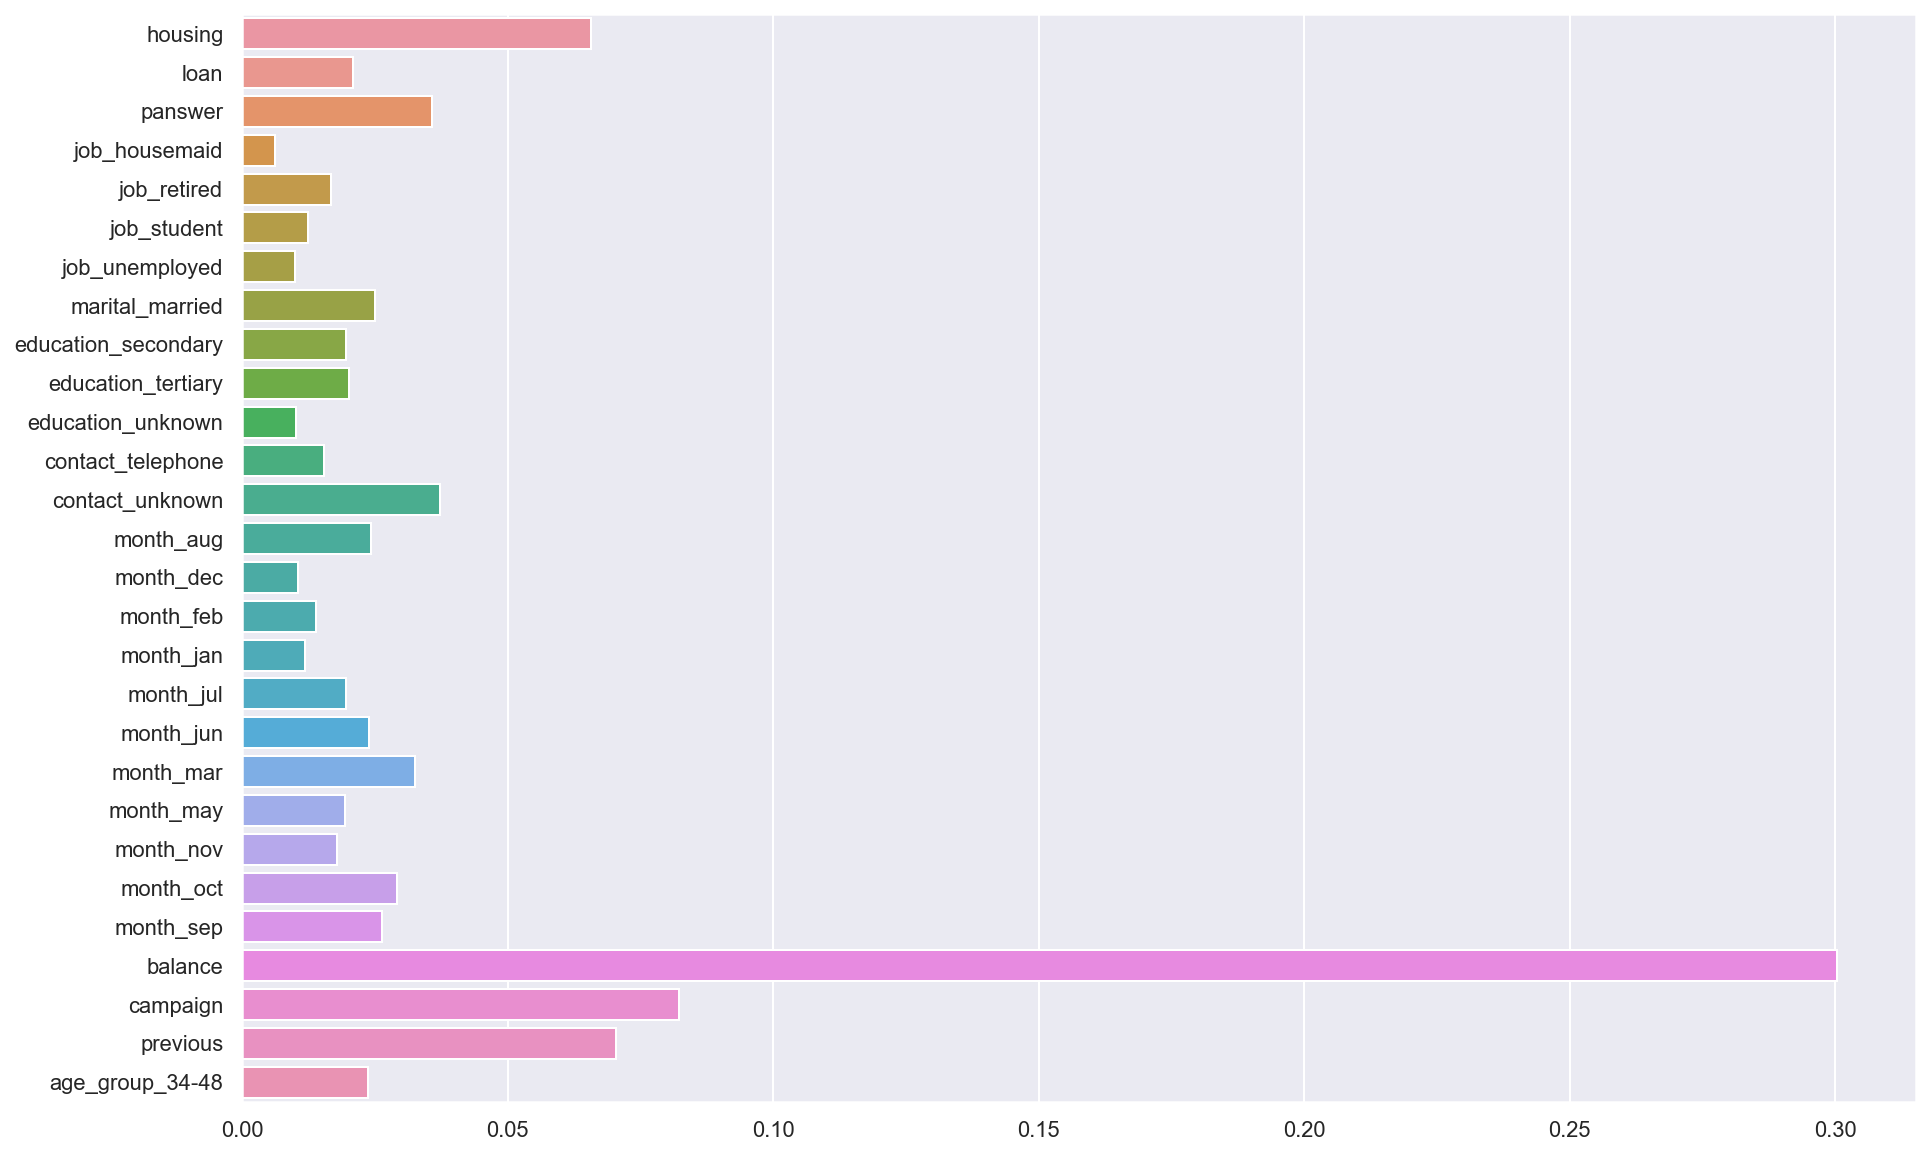

In [126]:
plt.figure(figsize = (15,10))
sns.barplot(x  =feature_importances , y = X.columns)

In [127]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, rf_output) * 100

88.25481088254811

In [128]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, rf_output)
print(cr)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7949
           1       0.57      0.12      0.20      1093

    accuracy                           0.88      9042
   macro avg       0.73      0.55      0.57      9042
weighted avg       0.85      0.88      0.85      9042



## 예측에 좋은 성능을 보이는 머신러닝 모델 찾기
* 참고자료 : Classification Analysis on Telco Customer Churn - The Startup - Medium

In [89]:
features = result.params.index.to_list()[1:]
df1 = df1[features]

In [90]:
df1

housing  loan  panswer  job_housemaid  job_retired  job_student  \
0            1     0        0              0            0            0   
1            1     0        0              0            0            0   
2            1     1        0              0            0            0   
3            1     0        0              0            0            0   
4            0     0        0              0            0            0   
...        ...   ...      ...            ...          ...          ...   
45205        0     0        0              0            0            0   
45206        0     0        0              0            1            0   
45207        0     0        1              0            1            0   
45208        0     0        0              0            0            0   
45209        0     0        1              0            0            0   

       job_unemployed  marital_married  education_secondary  \
0                   0                1                    0   
1                   0                0                    1   
2                   0                1                    1   
3                   0                1                    0   
4                   0                0                    0   
...               ...              ...                  ...   
45205               0                1                    0   
45206               0                0                    0   
45207               0                1                    1   
45208               0                1                    1   
45209               0                1                    1   

       education_tertiary  ...  month_jun  month_mar  month_may  month_nov  \
0                       1  ...          0          0          1          0   
1                       0  ...          0          0          1          0   
2                       0  ...          0          0          1          0   
3                       0  ...          0          0          1          0   
4                       0  ...          0          0          1          0   
...                   ...  ...        ...        ...        ...        ...   
45205                   1  ...          0          0          0          1   
45206                   0  ...          0          0          0          1   
45207                   0  ...          0          0          0          1   
45208                   0  ...          0          0          0          1   
45209                   0  ...          0          0          0          1   

       month_oct  month_sep   balance  campaign  previous  age_group_34-48  
0              0          0  0.507837 -0.569350 -0.300986                0  
1              0          0 -0.590387 -0.569350 -0.300986                1  
2              0          0 -0.606211 -0.569350 -0.300986                0  
3              0          0  0.203011 -0.569350 -0.300986                1  
4              0          0 -0.606798 -0.569350 -0.300986                0  
...          ...        ...       ...       ...       ...              ...  
45205          0          0 -0.146287  0.076224 -0.300986                0  
45206          0          0  0.311982 -0.246563 -0.300986                0  
45207          0          0  1.926270  0.721798  1.271418                0  
45208          0          0 -0.230628  0.399011 -0.300986                0  
45209          0          0  0.876686 -0.246563  5.464496                1  

[45210 rows x 28 columns]

In [92]:
y

0        0
1        0
2        0
3        0
4        0
        ..
45205    1
45206    1
45207    1
45208    0
45209    0
Name: y, Length: 45210, dtype: int64

In [103]:
from sklearn.model_selection import KFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

In [93]:
X = df1

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (36168, 28)
y_train (36168,)
X_test (9042, 28)
y_test (9042,)


### 모델 리포트

In [95]:
def model_report(model_name, model):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
  

    # X_train, y_train 으로 모델을 학습하는 코드를 작성해 주세요
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                  # eg [ 0.0001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5, 0.5998, 0.6996, 0.7994, 0.8992, 0.9999 ]
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                  # eg 0.3xx [ 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                  # eg 0.30x [ 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31 ]
        for th in th_list[i]:
            y_pred = (model.predict_proba(X_test)[:,1] >= th) # predict_proba 로 예측하게 합니다.
            f1scor = f1_score(y_test, y_pred) # y_test, y_pred 로 f1_score를 구해주세요.
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    print('Test set: {:.2f}%'.format(100*model.score(X_test, y_test)))   # should use cross validation

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    global model_f1, model_auc, model_ll, model_roc_auc
    model_f1 = f1_score(y_test, y_pred)

    y_pred = model.predict_proba(X_test)
    model_ll = log_loss(y_test, y_pred)
    print(model_name, 'Log-loss: {:.4f}'.format(model_ll))
    y_pred = model.predict(X_test)
    model_roc_auc = roc_auc_score(y_test, y_pred)
    print(model_name, 'roc_auc_score: {:.4f}'.format(model_roc_auc)) 
    y_pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    model_auc = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(model_auc))

    # plot the ROC curve
    plt.figure(figsize = [6,6])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % model_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    # plt.savefig('roc_auc_score')
    plt.show()
  
    return

# initialise lists to collect the results to plot later
model_list = []
f1_list = []
auc_list = []
ll_list = []
roc_auc_list = []
time_list = []

### GaussianNB


"""""" GaussianNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.2704,  0.100->0.3523,  0.200->0.3512,  0.300->0.3541,  0.400->0.3527,  0.500->0.3500,  0.600->0.3408,  0.700->0.3366,  0.800->0.3286,  0.900->0.3134,  1.000->0.2878,  
Looping decimal place 2
0.200->0.3512,  0.210->0.3518,  0.220->0.3510,  0.230->0.3513,  0.240->0.3515,  0.250->0.3527,  0.260->0.3534,  0.270->0.3542,  0.280->0.3541,  0.290->0.3540,  0.300->0.3541,  0.310->0.3545,  0.320->0.3536,  0.330->0.3532,  0.340->0.3533,  0.350->0.3538,  0.360->0.3535,  0.370->0.3533,  0.380->0.3532,  0.390->0.3536,  0.400->0.3527,  
Looping decimal place 3
0.300->0.3541,  0.301->0.3541,  0.302->0.3541,  0.303->0.3541,  0.304->0.3541,  0.305->0.3544,  0.306->0.3546,  0.307->0.3547,  0.308->0.3541,  0.309->0.3545,  0.310->0.3545,  0.311->0.3545,  0.312->0.3545,  0.313->0.3545,  0.314->0.3537,  0.315->0.3539,  0.316->0.3540,  0.317->0.3542,  0.318->0.

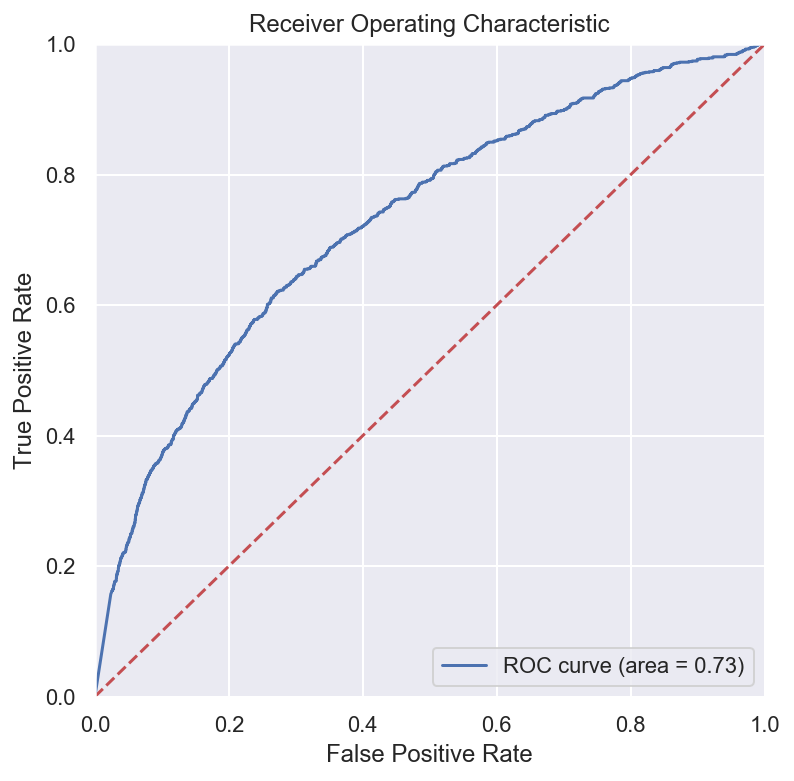

In [97]:
import time
print('\n"""""" GaussianNB """"""')
time1 = time.time()
gnb = GaussianNB()
model_report('GaussianNB', gnb) # 위에서 작성한 모델 리포트 함수를 부릅니다.

model_list.append('GaussianNB')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

### BernoulliNB


"""""" BernoulliNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.2157,  0.100->0.3273,  0.200->0.3674,  0.300->0.3761,  0.400->0.3739,  0.500->0.3528,  0.600->0.3182,  0.700->0.2740,  0.800->0.2054,  0.900->0.1060,  1.000->0.0000,  
Looping decimal place 2
0.200->0.3674,  0.210->0.3706,  0.220->0.3776,  0.230->0.3742,  0.240->0.3813,  0.250->0.3814,  0.260->0.3767,  0.270->0.3776,  0.280->0.3764,  0.290->0.3788,  0.300->0.3761,  0.310->0.3733,  0.320->0.3718,  0.330->0.3746,  0.340->0.3764,  0.350->0.3744,  0.360->0.3746,  0.370->0.3759,  0.380->0.3718,  0.390->0.3719,  0.400->0.3739,  
Looping decimal place 3
0.240->0.3813,  0.241->0.3810,  0.242->0.3810,  0.243->0.3816,  0.244->0.3819,  0.245->0.3821,  0.246->0.3824,  0.247->0.3795,  0.248->0.3798,  0.249->0.3802,  0.250->0.3814,  0.251->0.3806,  0.252->0.3806,  0.253->0.3786,  0.254->0.3788,  0.255->0.3783,  0.256->0.3783,  0.257->0.3781,  0.258->0

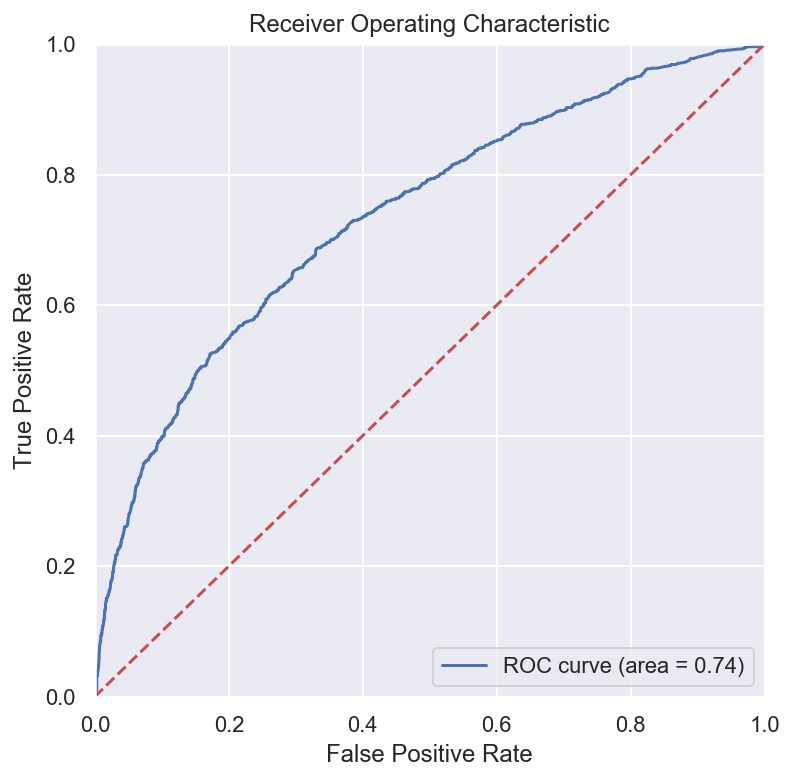

In [98]:
print('\n"""""" BernoulliNB """"""')
time1 = time.time()
bnb = BernoulliNB()
model_report('BernoulliNB', bnb) # 위에서 작성한 모델 리포트 함수를 부릅니다.

model_list.append('BernoulliNB')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

### LogisticRegression


"""""" LogisticRegression """"""

Search for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data
0.0033, 0.0038, 0.0043, 0.0043, 0.0042, 0.0042, 0.0043, 0.0043, 0.0043, 0.0043, 0.0042, 0.0043, 0.0047, 0.0042, 0.0042, 0.0047, 0.0047, 0.0047, 0.0047, 0.0066, 0.0080, 0.0095, 0.0099, 0.0113, 0.0136, 0.0150, 0.0168, 0.0215, 0.0238, 0.0269, 0.0310, 0.0355, 0.0399, 0.0443, 0.0500, 0.0521, 0.0581, 0.0628, 0.0675, 0.0687, 0.0712, 0.0741, 0.0778, 0.0819, 0.0847, 0.0892, 0.0911, 0.0952, 0.0974, 0.1013, 0.1045, 0.1071, 0.1082, 0.1114, 0.1152, 0.1172, 0.1190, 0.1224, 0.1231, 0.1250, 0.1277, 0.1303, 0.1322, 0.1345, 0.1369, 0.1390, 0.1409, 0.1424, 0.1427, 0.1452, 0.1470, 0.1469, 0.1487, 0.1490, 0.1493, 0.1499, 0.1509, 0.1511, 0.1519, 0.1522, 0.1532, 0.1539, 0.1549, 0.1560, 0.1560, 0.1564, 0.1568, 0.1567, 0.1571, 0.1574, 0.1574, 0.1574, 0.1581, 0.1589, 0.1589, 0.1592, 0.1596, 0.1600, 0.1599, 0.1599, 0.1602, 0.1602, 0.1602, 0.1602, 

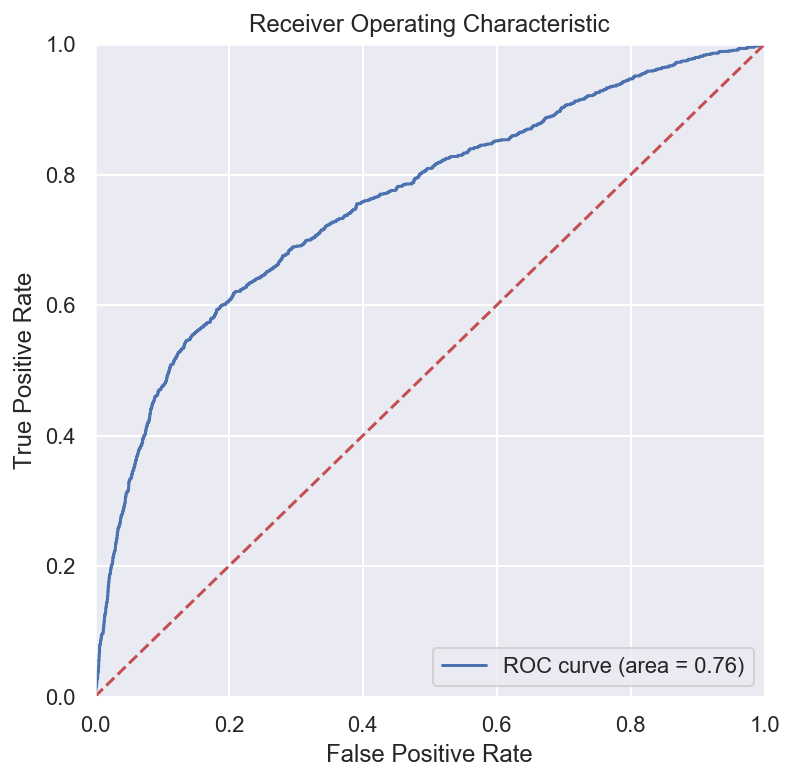

In [99]:
print('\n"""""" LogisticRegression """"""')
print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
score_list = []
c_list = 10**np.linspace(-3,3,200)

for c in c_list:
    logit = LogisticRegression(C = c)
    cvs = (cross_val_score(logit, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.3f}'.format(optimal_c))

time1 = time.time()
logit = LogisticRegression(C = optimal_c)
model_report('LogisticRegression', logit)

model_list.append('LogisticRegression')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

### KNN


"""""" KNN """""" (quite slow)

Search for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data
0.2541, 0.1529, 0.2568, 0.1712, 0.2277, 0.1645, 0.2224, 0.1614, 0.2050, 0.1530, 0.1841, 0.1424, 0.1776, 0.1341, 0.1663, 0.1297, 0.1522, 0.1200, 0.1390, 0.1135, optimal cv F1 score = 0.2568
optimal value of K = 3

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.3296,  0.100->0.3296,  0.200->0.3296,  0.300->0.3296,  0.400->0.2775,  0.500->0.2775,  0.600->0.2775,  0.700->0.0911,  0.800->0.0911,  0.900->0.0911,  1.000->0.0911,  
Looping decimal place 2
-0.100->0.2157,  -0.090->0.2157,  -0.080->0.2157,  -0.070->0.2157,  -0.060->0.2157,  -0.050->0.2157,  -0.040->0.2157,  -0.030->0.2157,  -0.020->0.2157,  -0.010->0.2157,  0.000->0.3296,  0.010->0.3296,  0.020->0.3296,  0.030->0.3296,  0.040->0.3296,  0.050->0.3296,  0.060->0.3296,  0.070->0.3296,  0.080->0.3296,  0.090->0.3296,

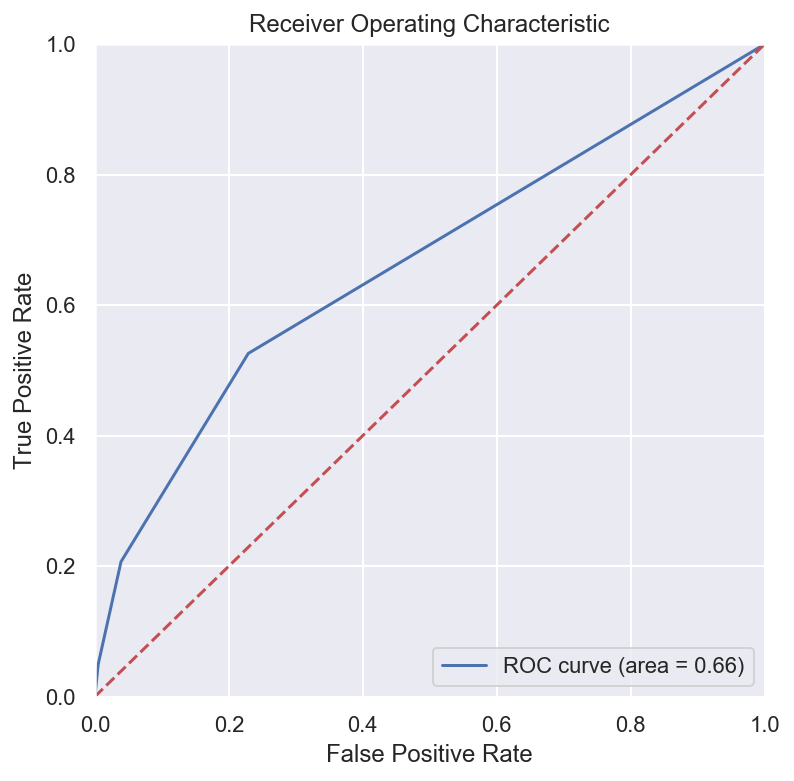


Compare with KNN classification_report (same as default threshold 0.50)
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7949
           1       0.42      0.21      0.28      1093

    accuracy                           0.87      9042
   macro avg       0.66      0.58      0.60      9042
weighted avg       0.84      0.87      0.85      9042



In [111]:
print('\n"""""" KNN """""" (quite slow)')
print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    cvs = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1').mean()
    k_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal cv F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
optimal_k = k_scores.index(max(k_scores))+1   # index 0 is for k=1
print('optimal value of K =', optimal_k)

time1 = time.time()
knn = KNeighborsClassifier(n_neighbors = optimal_k)
model_report('KNN', knn)

print('\nCompare with KNN classification_report (same as default threshold 0.50)')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

model_list.append('KNN')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

### DecisionTreeClassifier


"""""" DecisionTreeClassifier """"""

Search for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data
0.0195, 0.0558, 0.0594, 0.0626, 0.0824, 0.1445, 0.2021, 0.1744, 0.1948, optimal F1 score = 0.2021
optimal max_depth = 8

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.2140,  0.100->0.3197,  0.200->0.3980,  0.300->0.3941,  0.400->0.3254,  0.500->0.0965,  0.600->0.0548,  0.700->0.0453,  0.800->0.0454,  0.900->0.0197,  1.000->0.0198,  
Looping decimal place 2
0.100->0.3197,  0.110->0.3202,  0.120->0.3642,  0.130->0.3642,  0.140->0.4071,  0.150->0.4067,  0.160->0.4067,  0.170->0.4056,  0.180->0.4056,  0.190->0.4034,  0.200->0.3980,  0.210->0.3980,  0.220->0.3980,  0.230->0.3980,  0.240->0.3984,  0.250->0.3984,  0.260->0.3971,  0.270->0.3971,  0.280->0.3971,  0.290->0.3959,  0.300->0.3941,  
Looping decimal place 3
0.130->0.3642,  0.131->0.3642,  0.132->0.3642,  0.133->0.3

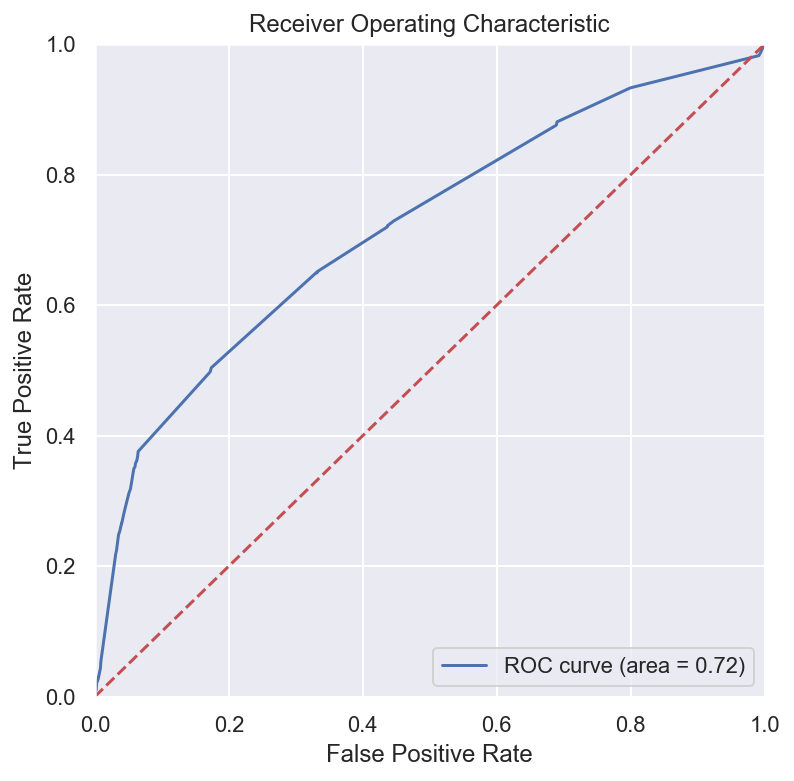

In [104]:
print('\n"""""" DecisionTreeClassifier """"""')

print('\nSearch for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  # produce the k folds
d_scores = []
for d in range(2, 11):
    decisiontree = DecisionTreeClassifier(max_depth=d)
    cvs = cross_val_score(decisiontree, X_train, y_train,
                          cv=kf, scoring='f1').mean()
    d_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
optimal_d = d_scores.index(max(d_scores))+2   # index 0 is for d=2
print('optimal max_depth =', optimal_d)

time1 = time.time()
decisiontree = DecisionTreeClassifier(max_depth=optimal_d)
model_report('DecisionTreeClassifier', decisiontree)

model_list.append('DecisionTreeClassifier')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

### RandomForestClassifier


"""""" RandomForestClassifier """""" (quite slow)

Search for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data
100->0.2480, 150->0.2486, 200->0.2457, 250->0.2495, 300->0.2477, 350->0.2470, 400->0.2485, 450->0.2497, 500->0.2452, optimal F1 score = 0.2497
optimal n_estimators = 450

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.2289,  0.100->0.3506,  0.200->0.3969,  0.300->0.3793,  0.400->0.3313,  0.500->0.2523,  0.600->0.1834,  0.700->0.1127,  0.800->0.0473,  0.900->0.0036,  1.000->0.0000,  
Looping decimal place 2
0.100->0.3506,  0.110->0.3569,  0.120->0.3620,  0.130->0.3672,  0.140->0.3714,  0.150->0.3769,  0.160->0.3851,  0.170->0.3890,  0.180->0.3928,  0.190->0.3943,  0.200->0.3969,  0.210->0.3950,  0.220->0.3946,  0.230->0.3936,  0.240->0.3935,  0.250->0.3898,  0.260->0.3917,  0.270->0.3920,  0.280->0.3887,  0.290->0.3875,  0.300->0.3793,  
Looping decim

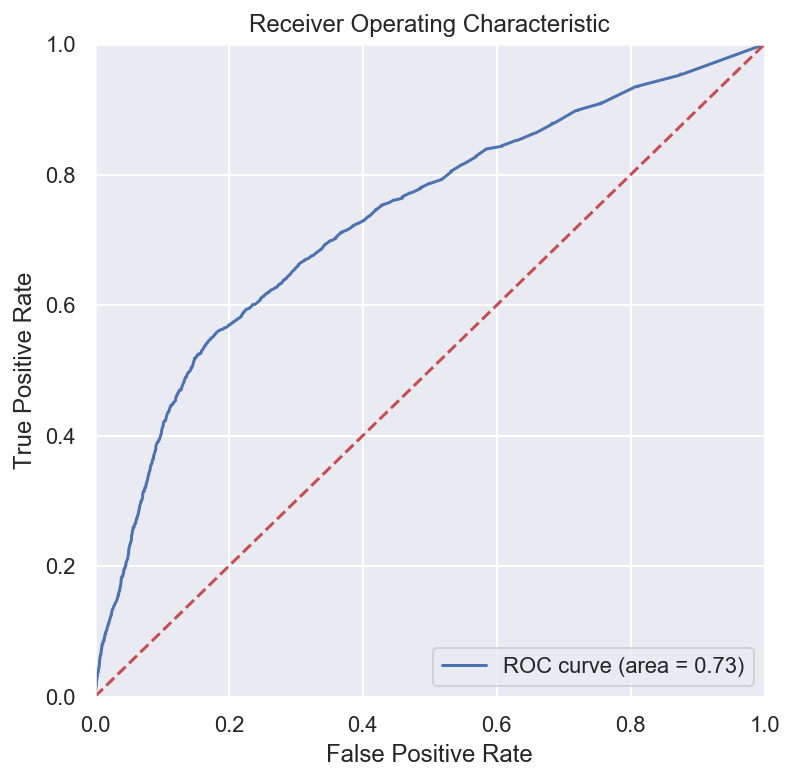

In [105]:
print('\n"""""" RandomForestClassifier """""" (quite slow)')

print('\nSearch for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400, 450, 500]:
    randomforest = RandomForestClassifier(n_estimators=n)
    cvs = (cross_val_score(randomforest, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
    print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.0f}'.format(optimal_n))

time1 = time.time()
randomforest = RandomForestClassifier(n_estimators=optimal_n)
model_report('RandomForestClassifier', randomforest)

model_list.append('RandomForestClassifier')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

### LinearSVC


"""""" LinearSVC """"""
LinearSVC accuracy score is
Training: 88.55%
Test set: 88.13%
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7949
           1       0.58      0.07      0.12      1093

    accuracy                           0.88      9042
   macro avg       0.73      0.53      0.53      9042
weighted avg       0.85      0.88      0.84      9042

LinearSVC confusion matrix: 
 [[7893   56]
 [1017   76]]
LinearSVC Log-loss: 4.0987
LinearSVC roc_auc_score: 0.5312
LinearSVC AUC: 0.5312


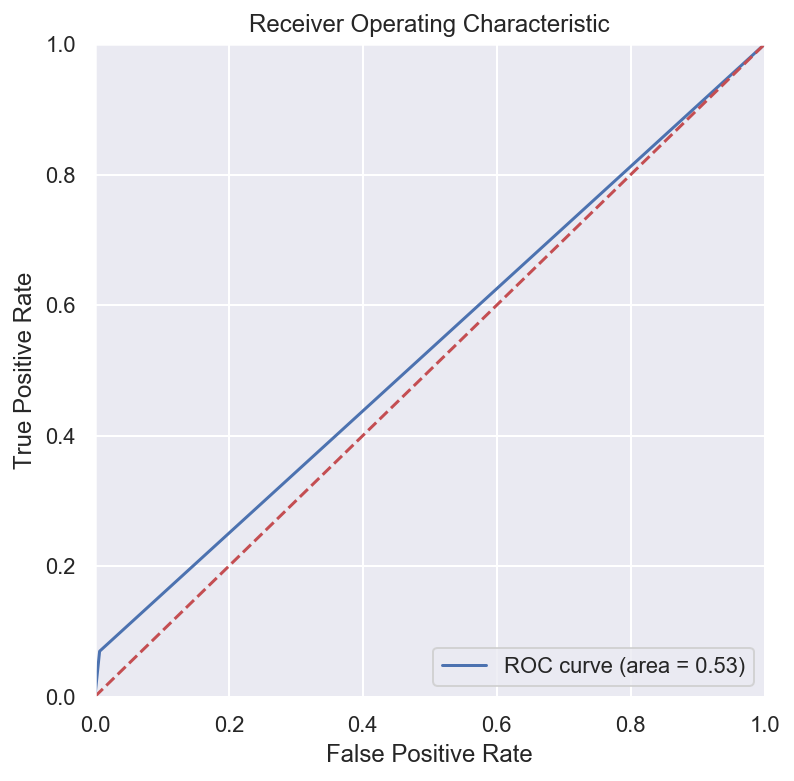

In [106]:
print('\n"""""" LinearSVC """"""')
time1 = time.time()
linearsvc = LinearSVC()
# model_report('LinearSVC', linearsvc)   # model has no attribute 'predict_proba'
linearsvc.fit(X_train, y_train)
print('LinearSVC accuracy score is')
print('Training: {:.2f}%'.format(100*linearsvc.score(X_train, y_train)))  # score uses accuracy
print('Test set: {:.2f}%'.format(100*linearsvc.score(X_test, y_test)))   # should use cross validation

y_pred = linearsvc.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print('LinearSVC confusion matrix: \n', confusion_matrix(y_test, y_pred))

model_f1 = f1_score(y_test, y_pred)

model_ll = log_loss(y_test, y_pred)
print('LinearSVC Log-loss: {:.4f}'.format(model_ll))
model_roc_auc = roc_auc_score(y_test, y_pred)
print('LinearSVC roc_auc_score: {:.4f}'.format(model_roc_auc)) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
model_auc = auc(fpr, tpr)
print('LinearSVC AUC: {:.4f}'.format(model_auc))

# plot the ROC curve
plt.figure(figsize = [6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % model_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# plt.savefig('roc_auc_score')
plt.show()

model_list.append('LinearSVC')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

### SVC


"""""" SVC """""" (extremely slow)

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.2157,  0.100->0.2244,  0.200->0.2767,  0.300->0.2206,  0.400->0.1821,  0.500->0.1410,  0.600->0.0922,  0.700->0.0522,  0.800->0.0321,  0.900->0.0055,  1.000->0.0000,  
Looping decimal place 2
0.100->0.2241,  0.110->0.3927,  0.120->0.3674,  0.130->0.3537,  0.140->0.3369,  0.150->0.3250,  0.160->0.3173,  0.170->0.3083,  0.180->0.3006,  0.190->0.2882,  0.200->0.2767,  0.210->0.2669,  0.220->0.2655,  0.230->0.2604,  0.240->0.2523,  0.250->0.2468,  0.260->0.2439,  0.270->0.2359,  0.280->0.2307,  0.290->0.2245,  0.300->0.2206,  
Looping decimal place 3
0.100->0.2241,  0.101->0.2279,  0.102->0.2477,  0.103->0.4190,  0.104->0.4170,  0.105->0.4174,  0.106->0.4145,  0.107->0.4132,  0.108->0.4099,  0.109->0.4018,  0.110->0.3927,  0.111->0.3879,  0.112->0.3830,  0.113->0.3815,  0.114->0.3797,  0.115->0.3816,  0.116->0.3760,  0.117->0.3692, 

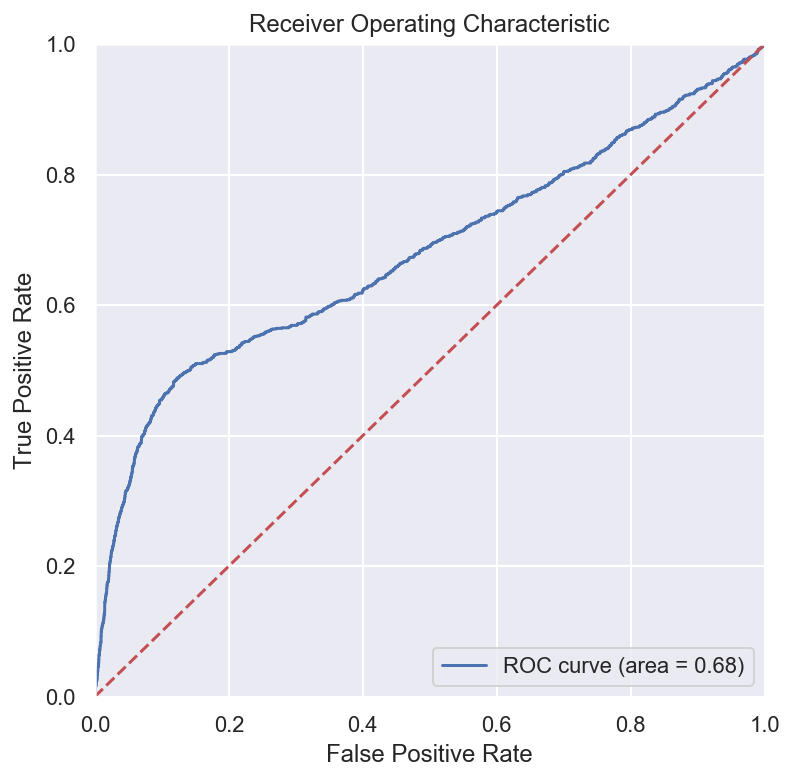

In [107]:
print('\n"""""" SVC """""" (extremely slow)')
time1 = time.time()
svc = SVC(gamma='scale', probability=True)
model_report('SVC', svc)

model_list.append('SVC')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
# time_list.append(time.time() - time1)   # use this line for actual time spent, or
time_list.append(0)                       # use this line to be able to see time spent for other models

### Classification Report Scores

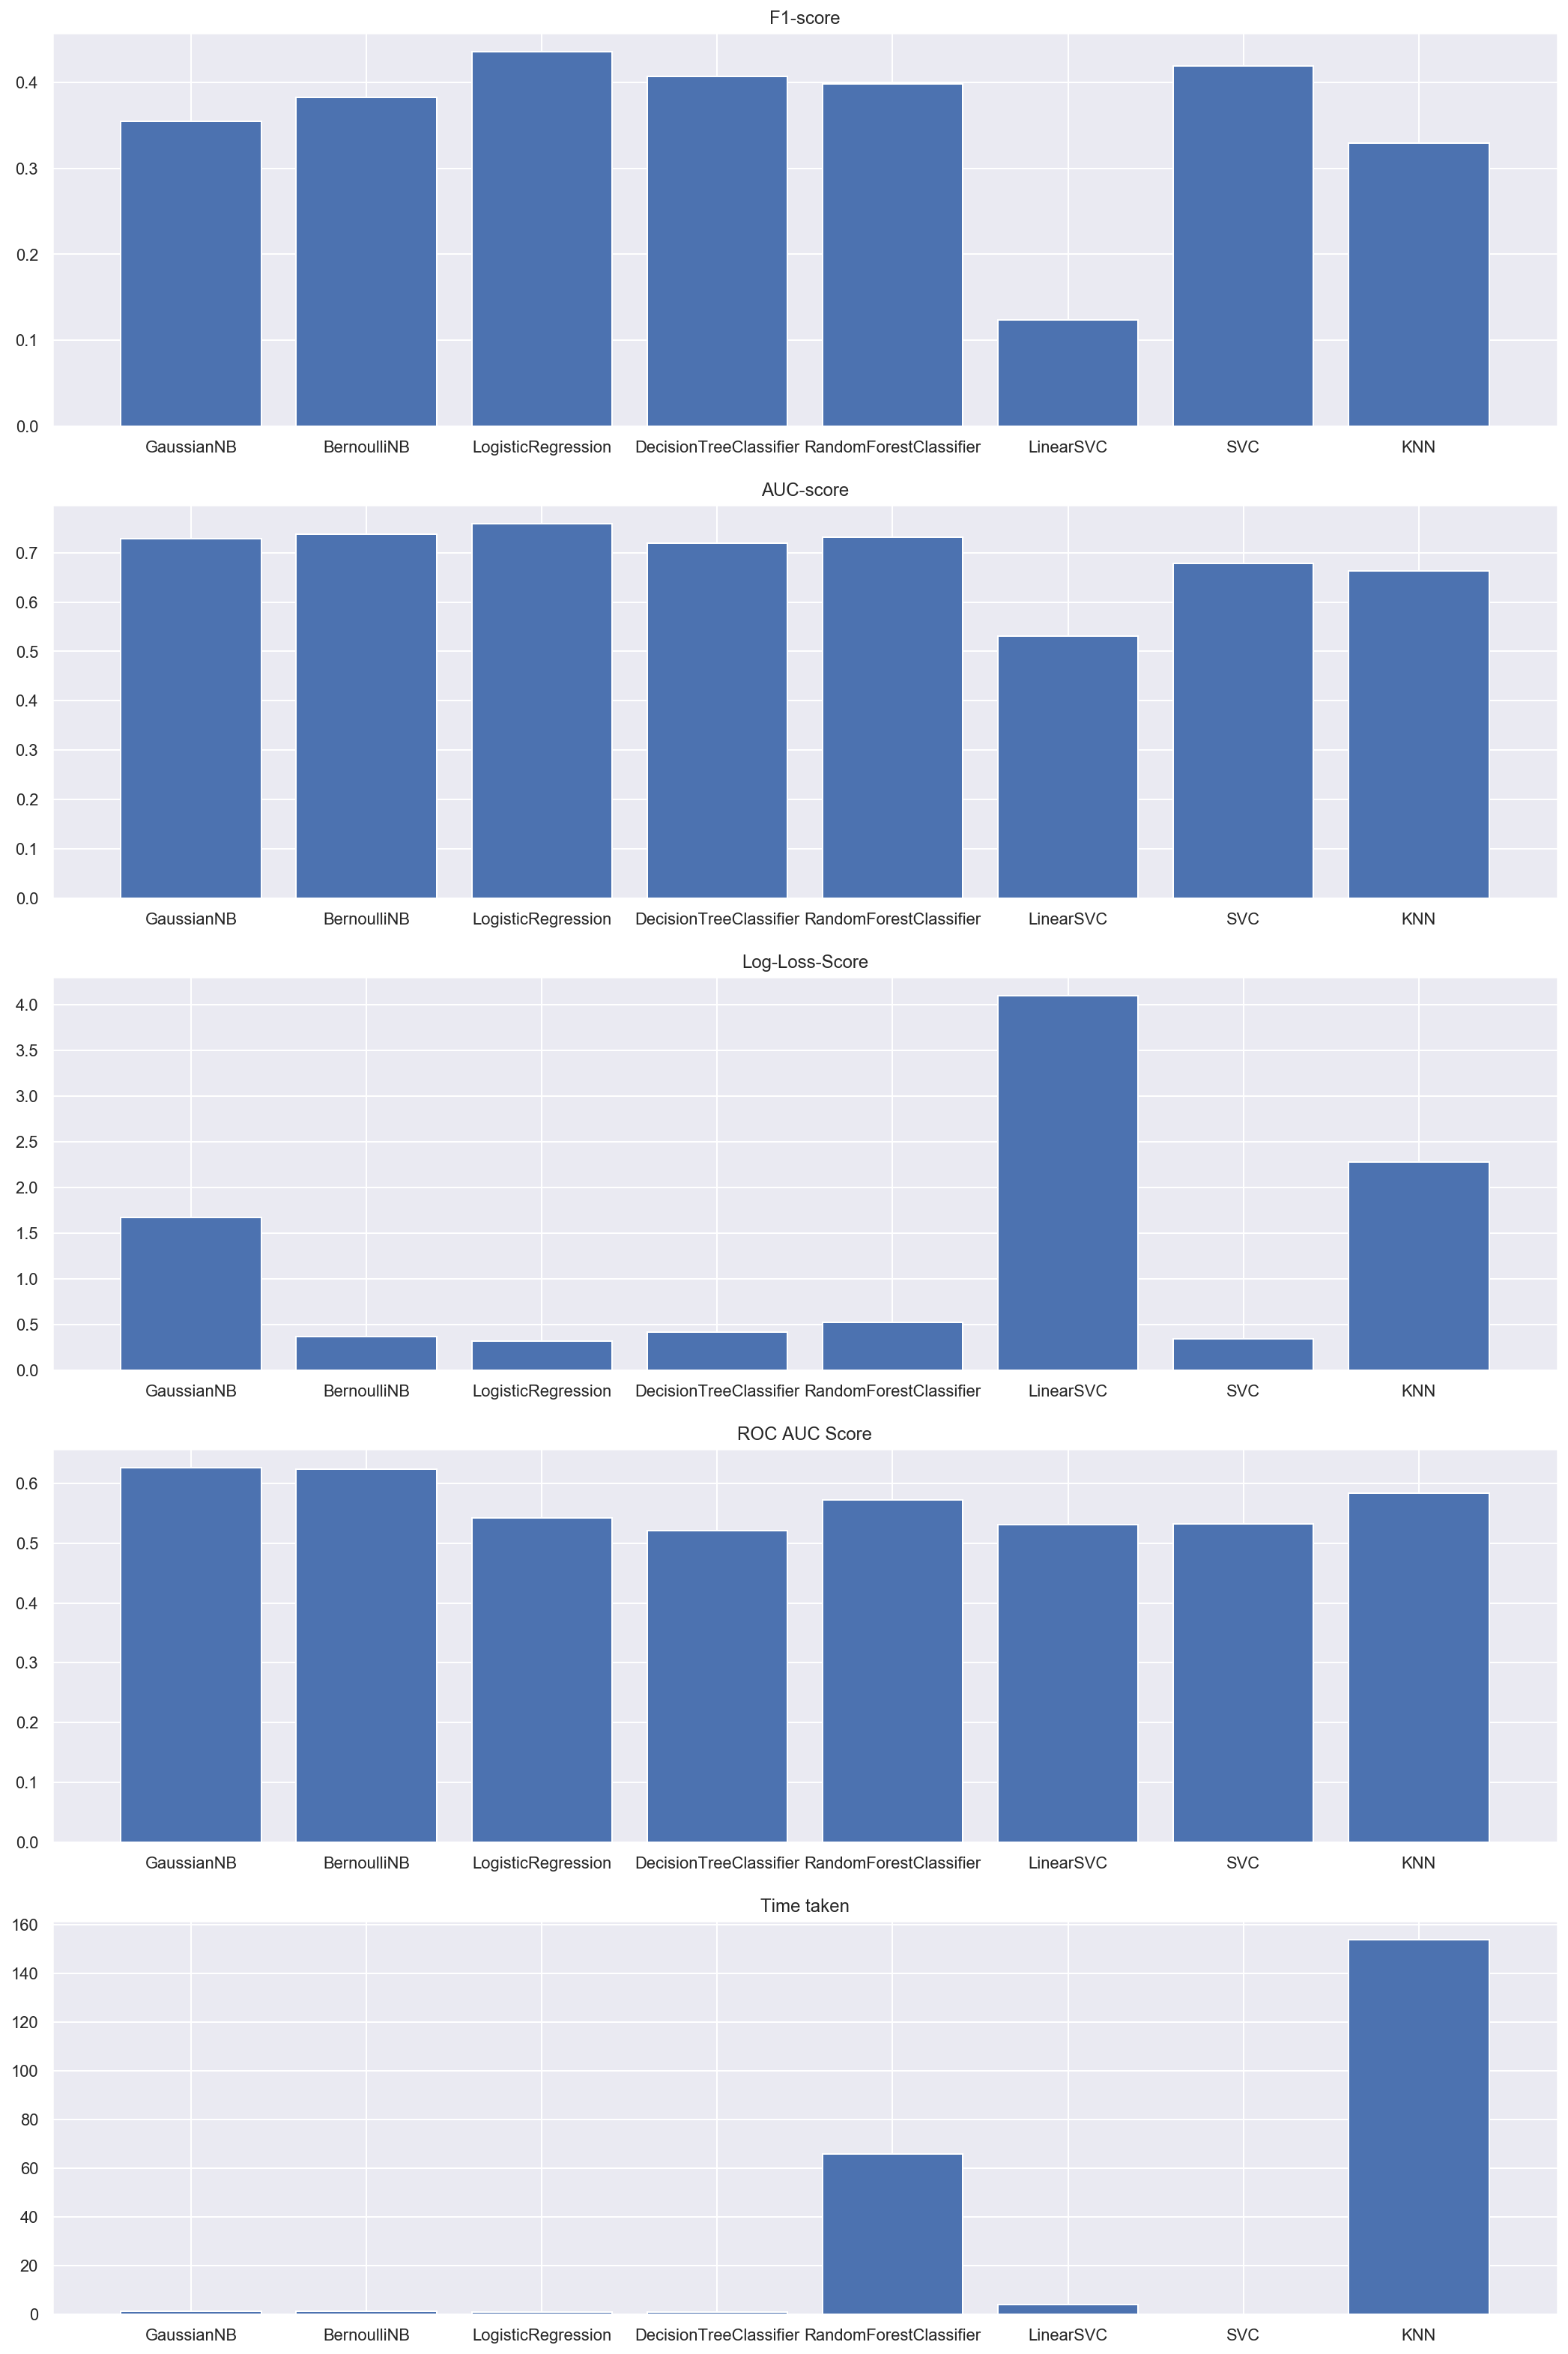

In [113]:
## plot the classification report scores
fig, ax = plt.subplots(5, 1, figsize=(18, 28))
# fig.set_figwidth(10)
# fig.set_figheight(6)
# fig.suptitle('Main Title',fontsize = 16)
ax[0].bar(model_list, f1_list)
ax[0].set_title('F1-score')
ax[1].bar(model_list, auc_list)
ax[1].set_title('AUC-score');
ax[2].bar(model_list, ll_list)
ax[2].set_title('Log-Loss-Score')
ax[3].bar(model_list, roc_auc_list)
ax[3].set_title('ROC AUC Score')
ax[4].bar(model_list, time_list)
ax[4].set_title('Time taken')
# Fine-tune figure; make subplots farther from each other, or nearer to each other.
fig.subplots_adjust(hspace=0.2, wspace=0.2)

In [114]:
model_list

['GaussianNB',
 'BernoulliNB',
 'LogisticRegression',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'LinearSVC',
 'SVC',
 'KNN']

### ROC curves

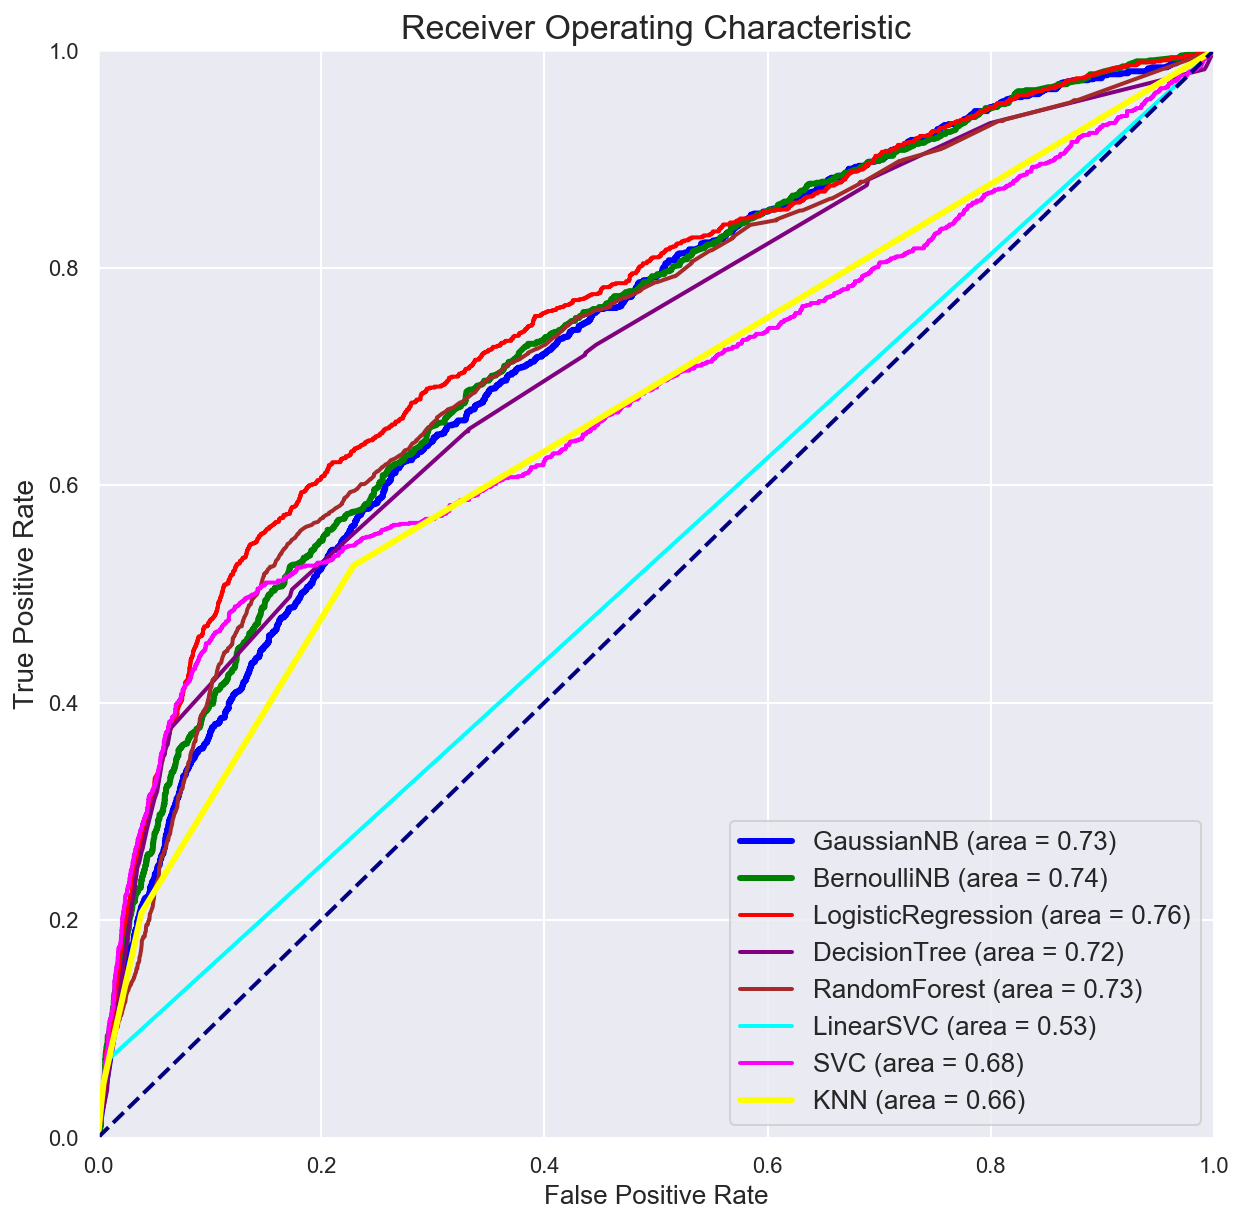

In [115]:
# plot the ROC curves
plt.figure(figsize=(10,10))

y_pred = gnb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='blue',
        lw=3, label='GaussianNB (area = %0.2f)' % auc_list[0])

y_pred = bnb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='green',
        lw=3, label='BernoulliNB (area = %0.2f)' % auc_list[1])

y_pred = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red',
        lw=2, label='LogisticRegression (area = %0.2f)' % auc_list[2])

y_pred = decisiontree.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='purple',
        lw=2, label='DecisionTree (area = %0.2f)' % auc_list[3])

y_pred = randomforest.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='brown',
        lw=2, label='RandomForest (area = %0.2f)' % auc_list[4])

y_pred = linearsvc.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='cyan',
        lw=2, label='LinearSVC (area = %0.2f)' % auc_list[5])

y_pred = svc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='magenta',
        lw=2, label='SVC (area = %0.2f)' % auc_list[6])

y_pred = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='yellow',
        lw=3, label='KNN (area = %0.2f)' % auc_list[7])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()